In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import glob
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

C:\Users\Prasoon\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Prasoon\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Prasoon\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Prasoon\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarnin

# Initializing the parameters

In [37]:
def placeholders(n_x,n_y):
    X = tf.placeholder(tf.float32,shape=[n_x,None],name='X')
    Y = tf.placeholder(tf.float32,shape=[n_y,None],name='Y')
    return (X,Y)

# Forward Propagation

In [38]:
def forward_propagation(X,layers_dims,param_normal, keep_prob=1.0):
    
    def sample_epsilons(param_normal):
        epsilons_W = []
        epsilons_b = []
        for i in range(len(layers_dims)-1):
            epsilons_W.append(tf.random_normal(shape=tf.shape(param_normal["mu_W"+str(i+1)]), mean=0., stddev=1.0))
            epsilons_b.append(tf.random_normal(shape=tf.shape(param_normal["mu_b"+str(i+1)]), mean=0., stddev=1.0))
        return epsilons_W,epsilons_b

    def transform_rhos(layers_dims,param_normal):
        for i in range(len(layers_dims)-1):
            param_normal["rho_W"+str(i+1)] = softplus(param_normal["rho_W"+str(i+1)])
            param_normal["rho_b"+str(i+1)] = softplus(param_normal["rho_b"+str(i+1)])
        return param_normal

    def make_gaussian_samples(param_normal,layers_dims,epsilons_W,epsilons_b):
        samples_W = []
        samples_b = []
        for i in range(len(layers_dims)-1):
            samples_W.append(tf.add(param_normal["mu_W"+str(i+1)],tf.multiply( param_normal["rho_W"+str(i+1)] , epsilons_W[i])))
            samples_b.append(tf.add(param_normal["mu_b"+str(i+1)] ,tf.multiply( param_normal["rho_b"+str(i+1)] , epsilons_b[i])))
        return samples_W, samples_b

    epsilons_W,epsilons_b = sample_epsilons(param_normal)
    param_normal = transform_rhos(layers_dims,param_normal)
    samples_W, samples_b =  make_gaussian_samples(param_normal,layers_dims,epsilons_W,epsilons_b)
    
    store = {}
    store['A0'] = X
    for l in range(len(layers_dims)-1):
        store["Z"+str(l+1)] = tf.add(tf.matmul(samples_W[l],store["A"+str(l)]),samples_b[l])
        if (l == len(layers_dims) - 2):
            return store["Z"+str(l+1)],samples_W,samples_b
        #store["Z"+str(l+1)] = tf.layers.batch_normalization(store["Z"+str(l+1)],axis=0)
        store["A"+str(l+1)] = tf.nn.sigmoid(store["Z"+str(l+1)])
        store["A"+str(l+1)] = tf.nn.dropout(store["A"+str(l+1)], keep_prob)

In [39]:
def initialization(layers_dims):
    param_normal = {}
    for l in range(len(layers_dims)-1):
        param_normal["mu_W"+str(l+1)] = tf.get_variable('mu_W'+str(l+1),[layers_dims[l+1],layers_dims[l]],initializer =  tf.random_normal_initializer(mean = 0.0,stddev = 0.1))
        param_normal["rho_W"+str(l+1)] = -15.5 + tf.get_variable("rho_W"+str(l+1),[layers_dims[l+1],layers_dims[l]],initializer = tf.zeros_initializer())
        param_normal["mu_b"+str(l+1)] = tf.get_variable('mu_b'+str(l+1),[layers_dims[l+1],1],initializer =  tf.random_normal_initializer(mean = 0.0,stddev = 0.1))
        param_normal["rho_b"+str(l+1)] =  -16.5 + tf.get_variable("rho_b"+str(l+1),[layers_dims[l+1],1],initializer = tf.zeros_initializer())
    return param_normal 

In [40]:
def softplus(x):
    return tf.log(1.0 + tf.exp(x))

In [41]:
def log_gaussian(x, mu,sigma):
    return -0.5 * tf.log(2.0 * tf.constant(math.pi)) - tf.log(sigma) - tf.truediv(tf.multiply((x-mu),(x-mu)), (2.0 * tf.multiply(sigma,sigma)))

In [42]:
def prior(x):
    mean_prior = tf.constant(0.0)
    sigma_prior = tf.constant(1.0)
    return tf.reduce_sum(log_gaussian(x,mean_prior,sigma_prior))

In [43]:
def gaussian(x,mu,sigma):
    scaling = tf.truediv(1.0,tf.sqrt(2.0 * tf.constant(math.pi) * tf.multiply(sigma,sigma)))
    bell = tf.exp(-1.0 * tf.truediv(tf.multiply((x-mu),(x-mu)), (2.0 * tf.multiply(sigma,sigma))))
    return tf.multiply(scaling,bell)

def scale_mixture_prior(x):
    sigma_p1 = tf.constant(0.2)
    sigma_p2 = tf.constant(0.8)
    pi = 0.15
    first_gaussian = tf.constant(pi) * gaussian(x,0.0,sigma_p1)
    second_gaussian = (1.0-tf.constant(pi)) * gaussian(x,0.0,sigma_p2)
    return tf.reduce_sum(tf.log(first_gaussian+second_gaussian))

In [44]:
def log_softmax_likelihood(ZL, y):
    return  -1 * tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=tf.transpose(y),logits=tf.transpose(ZL),))

In [45]:
def compute_cost(layers_dims,samples_W,samples_b,param_normal,ZL,label_one_hot):
    log_likelihood_sum = log_softmax_likelihood(ZL, label_one_hot)
    log_prior_list = []
    log_var_posterior_list = []
    for i in range(len(layers_dims)-1):
        log_prior_list.append(prior(samples_W[i]))
        log_prior_list.append(prior(samples_b[i]))
        log_var_posterior_list.append(tf.reduce_sum(log_gaussian(samples_W[i],param_normal["mu_W"+str(i+1)],param_normal["rho_W"+str(i+1)])))
        log_var_posterior_list.append( tf.reduce_sum(log_gaussian(samples_b[i],param_normal["mu_b"+str(i+1)],param_normal["rho_b"+str(i+1)])))
    log_prior_sum = sum(log_prior_list)
    log_var_posterior_sum = sum(log_var_posterior_list)
    return 1/(X_train.shape[1]) * (log_var_posterior_sum - log_prior_sum -  log_likelihood_sum)

In [46]:
def model(X_train,Y_train,X_test,Y_test,learning_rate,num_epochs,print_cost,layers_dims):
    tf.reset_default_graph()
    tf.set_random_seed(1234)
    n_x = X_train.shape[0]
    m = X_train.shape[1]
    n_y = Y_train.shape[0]
    costs =[]
    (X,Y) = placeholders(n_x,n_y)
    param_normal = initialization(layers_dims)
    ZL,samples_W,samples_b = forward_propagation(X,layers_dims,param_normal)
    loss = compute_cost(layers_dims,samples_W,samples_b,param_normal,ZL,Y_train)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss) 
    init = tf.global_variables_initializer()
    #num_minibatches = int(m/minibatch_size)
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            _,epoch_cost = sess.run([optimizer,loss],feed_dict={X : X_train, Y : Y_train})
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
        logit_final_temp = tf.nn.softmax(ZL,axis=0)
        list_logit_train = []
        list_logit_test = []
        list_Z = []
        #grad_val = []
        for pred in range(0,500):
            logit_final_test = logit_final_temp.eval(feed_dict={X: X_test})
            logit_final_train = logit_final_temp.eval(feed_dict = {X: X_train})
            Z = ZL.eval(feed_dict={X: X_test})
            list_logit_train.append(logit_final_train)
            list_logit_test.append(logit_final_test)
            list_Z.append(Z)
            if pred == 0:
                arr_pred_train = np.argmax(logit_final_train, axis= 0)
                arr_pred_test = np.argmax(logit_final_test,axis=0)
                train_accuracy =  np.sum(arr_pred_train == Ytrain) / len(arr_pred_train)
                test_accuracy = np.sum(arr_pred_test == Ytest) / len(arr_pred_test)
                grad = tf.gradients(logit_final_temp,X)
                grad_val = sess.run(grad, feed_dict = {X:X_train})
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
    return [train_accuracy,test_accuracy,list_logit_test,list_logit_train,arr_pred_test,arr_pred_train,grad_val]

In [47]:
df_pca2 = pd.read_csv('D:/New folder/100_genes_pca2_new.csv')

In [50]:
def split_train_test(df_pca2,rs):
    for l in range(31):
        df_temp = df_pca2.loc[df_pca2['label'] == l]
        if l == 0:
            X_train, X_test, y_train, y_test = train_test_split(df_temp.iloc[:,:-1],df_temp.iloc[:,-1], test_size=0.20, random_state=rs)
        else:
            X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(df_temp.iloc[:,:-1],df_temp.iloc[:,-1], test_size=0.20, random_state=rs)
            X_train = pd.concat([X_train,X_train_temp])
            X_test = pd.concat([X_test,X_test_temp])
            y_train = pd.concat([y_train,y_train_temp])
            y_test = pd.concat([y_test,y_test_temp])
    return (X_train, X_test, y_train, y_test)

In [51]:
np.random.seed(0)
r = np.random.randint(500)

In [52]:
(X_train_val, X_test_val, y_train_val, y_test_val) = split_train_test(df_pca2,r)

# Test

In [53]:
np.random.seed(0)
r = np.random.randint(500)
(X_train, X_test, y_train, y_test) = split_train_test(df_pca2,r)

In [54]:
Ytrain = np.array(y_train).reshape(len(y_train),)
X_train = np.array(X_train.T.reset_index(drop=True))
Y_train = tf.Session().run(tf.one_hot(Ytrain,len(set(Ytrain)),axis=1)).reshape(len(Ytrain),len(set(Ytrain))).T
Ytest = np.array(y_test).reshape(len(y_test),)
X_test = np.array(X_test.T.reset_index(drop=True))
Y_test = tf.Session().run(tf.one_hot(Ytest,len(set(Ytest)),axis=1)).reshape(len(Ytest),len(set(Ytest))).T

In [55]:
layers_dims = [X_train.shape[0],250,95,31]
[_,_,logits,logits_train,arr_pred_test,arr_pred_train,grad_val] = model(X_train=X_train,Y_train=Y_train,X_test =X_test,Y_test = Y_test, learning_rate=0.0005,num_epochs=3500,print_cost=True,layers_dims = layers_dims)

Cost after epoch 0: 100.214638
Cost after epoch 100: 98.668396
Cost after epoch 200: 97.784966
Cost after epoch 300: 97.394218
Cost after epoch 400: 97.209717
Cost after epoch 500: 97.043793
Cost after epoch 600: 96.973923
Cost after epoch 700: 96.903824
Cost after epoch 800: 96.873451
Cost after epoch 900: 94.251862
Cost after epoch 1000: 94.231339
Cost after epoch 1100: 94.145981
Cost after epoch 1200: 94.149834
Cost after epoch 1300: 94.132957
Cost after epoch 1400: 94.144089
Cost after epoch 1500: 94.114418
Cost after epoch 1600: 92.242096
Cost after epoch 1700: 92.206703
Cost after epoch 1800: 92.249779
Cost after epoch 1900: 92.191315
Cost after epoch 2000: 92.212646
Cost after epoch 2100: 90.734207
Cost after epoch 2200: 90.751938
Cost after epoch 2300: 90.727829
Cost after epoch 2400: 90.691910
Cost after epoch 2500: 89.541817
Cost after epoch 2600: 89.578423
Cost after epoch 2700: 89.524017
Cost after epoch 2800: 88.507179
Cost after epoch 2900: 88.540108
Cost after epoch 3000

In [45]:
c = Counter(list(y_test))

In [61]:
Counter(y_test)

Counter({0: 35,
         1: 16,
         2: 86,
         3: 106,
         4: 244,
         5: 62,
         6: 9,
         7: 66,
         8: 41,
         9: 40,
         10: 35,
         11: 114,
         12: 122,
         13: 65,
         14: 85,
         15: 116,
         16: 111,
         17: 10,
         18: 18,
         19: 62,
         20: 37,
         21: 38,
         22: 110,
         23: 21,
         24: 95,
         25: 90,
         26: 32,
         27: 25,
         28: 115,
         29: 12,
         30: 16})

In [68]:
np.mean(grad_val[0][:,0:35],axis=1).shape

(103,)

In [66]:
grad_val[0][:,0:35].shape

(103, 35)

In [71]:
start_index = 0
grad_mean = []
for i in range(31):
    temp_index = Counter(y_test)[i]
    end_index = start_index+temp_index
    grad_mean.append(np.mean(grad_val[0][:,start_index:end_index],axis=1))
    start_index=end_index

In [92]:
sort_index = np.argsort(np.abs(grad_mean[0]))

In [93]:
l_pca2 = list(df_pca2.columns[:-1])

In [94]:
sorted_genes= []
for i in sort_index:
    sorted_genes.append(l_pca2[i])

In [122]:
sns.set_style()

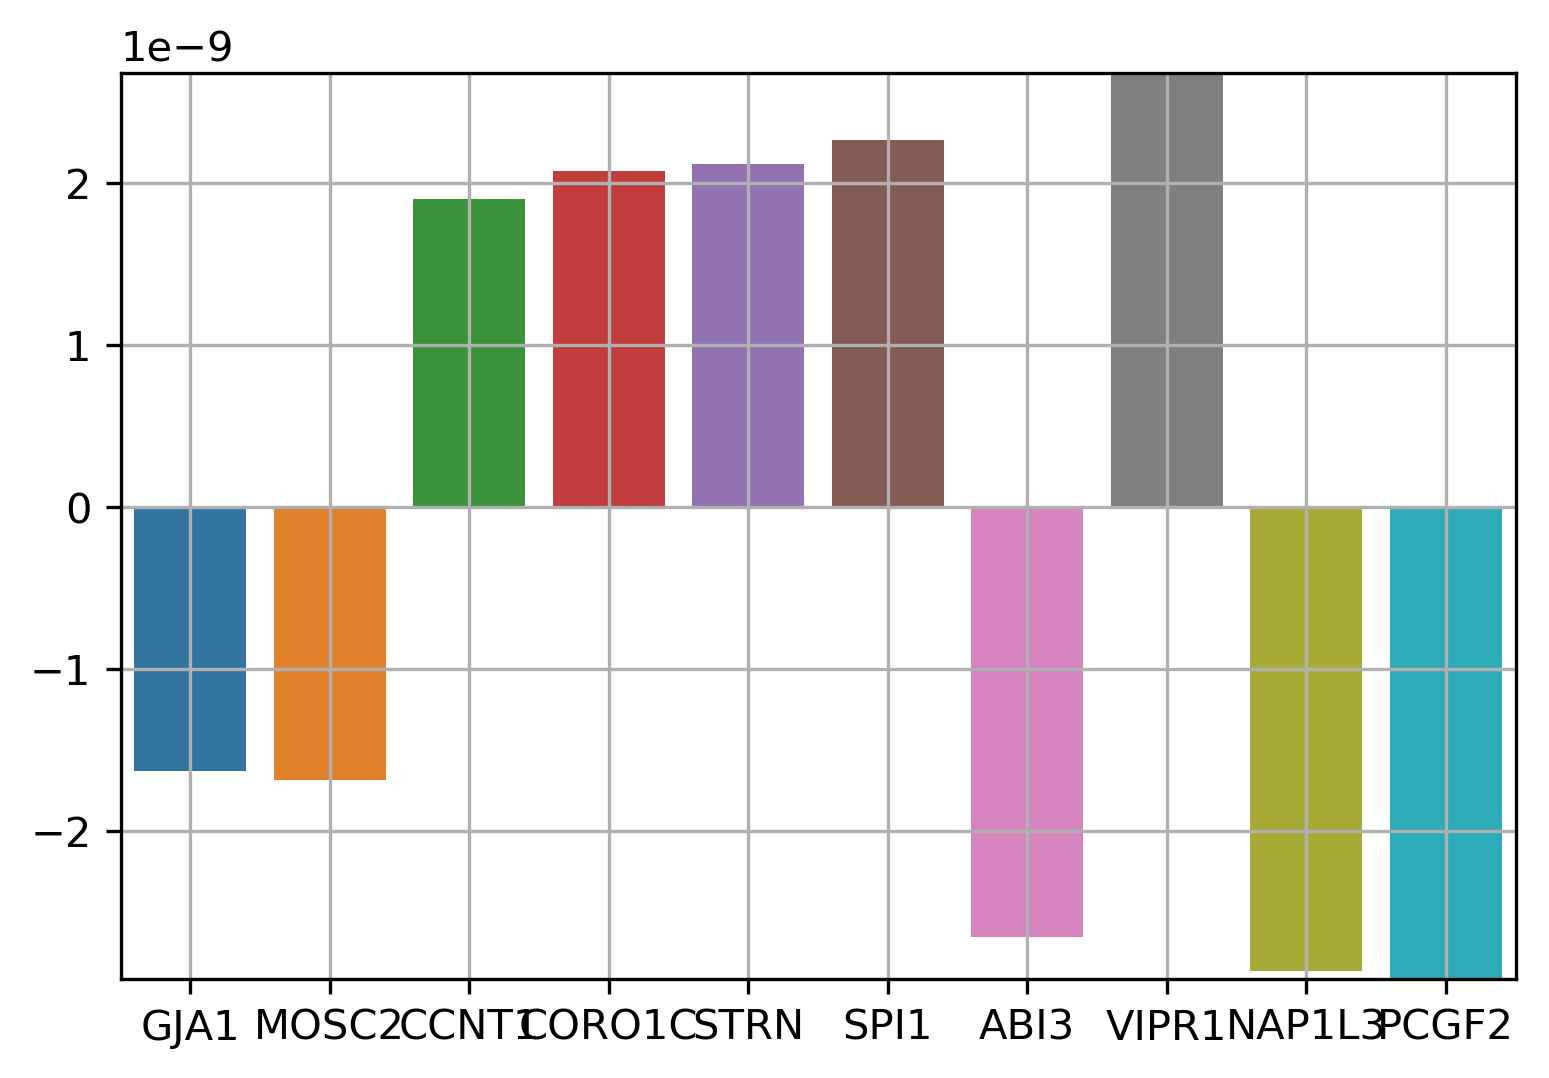

In [124]:
from matplotlib.pyplot import figure
figure(num=None, dpi=300, facecolor='w', edgecolor='r')
sns.barplot(y=grad_mean[0][sort_index][-10:], x = sorted_genes[-10:])
plt.grid()
plt.show()

In [120]:
sorted_genes

['ASNSD1',
 'PARVA',
 'TBC1D16',
 'ARHGAP9',
 'RASAL3',
 'C1orf21',
 'GOLGA2B',
 'MYO1F',
 'TRIM31',
 'RTDR1',
 'ITGB2',
 'TMPRSS11D',
 'ATP1B2',
 'CD37',
 'LASS3',
 'SBNO1',
 'FOXE1',
 'CAPNS2',
 'PRSS3',
 'CABLES1',
 'STMN1',
 'MNT',
 'C12orf54',
 'TGM1',
 'PSMA6',
 'GDA',
 'JMJD7-PLA2G4B',
 'PIGT',
 'CREB3L4',
 'PTPN23',
 'HCST',
 'ATP6V1G2',
 'SIDT1',
 'MAGI2',
 'USH1C',
 'ANTXR1',
 'MUC13',
 'TECTA',
 'PAX8',
 'SGMS2',
 'CBFA2T3',
 'MAP3K2',
 'GTF2IRD1',
 'IVL',
 'KIAA1211',
 'KCNJ16',
 'RASA2',
 'PLEKHM1',
 'LST1',
 'PLOD3',
 'TARP',
 'SLC4A2',
 'ZNF814',
 'EFNA2',
 'OFD1',
 'KLHL38',
 'ZDHHC12',
 'HGD',
 'HAUS1',
 'DEFB132',
 'NOP56',
 'COL16A1',
 'PCP2',
 'EPS8L3',
 'TIPRL',
 'LATS1',
 'KCP',
 'DNAJC18',
 'CYTH4',
 'FASN',
 'SERPINB13',
 'REST',
 'TMEM54',
 'BHMT2',
 'BLM',
 'EFCAB4A',
 'ABI2',
 'FMNL1',
 'ASXL2',
 'WAS',
 'PLCH2',
 'RNF169',
 'GPN3',
 'C19orf46',
 'CAMTA2',
 'GLTP',
 'SRP9',
 'ZDHHC20',
 'LCOR',
 'EFS',
 'DDR1',
 'RAI1',
 'BAG3',
 'GJA1',
 'MOSC2',
 'CCNT1',
 

In [40]:
grad_val[0][:,0].shape

(103,)

In [ ]:
layers_dims = [X_train.shape[0],250,95,31]
[_,_,logits,logits_train,arr_pred_test,arr_pred_train] = model(X_train=X_train,Y_train=Y_train,X_test =X_test,Y_test = Y_test, learning_rate=0.0005,num_epochs=3500,print_cost=True,layers_dims = layers_dims)

Cost after epoch 0: 100.214638
Cost after epoch 100: 98.668396
Cost after epoch 200: 97.784966
Cost after epoch 300: 97.394218
Cost after epoch 400: 97.209717
Cost after epoch 500: 97.043793
Cost after epoch 600: 96.973923
Cost after epoch 700: 96.903824
Cost after epoch 800: 96.873451
Cost after epoch 900: 94.251862
Cost after epoch 1000: 94.231339
Cost after epoch 1100: 94.145981
Cost after epoch 1200: 94.149834
Cost after epoch 1300: 94.132957
Cost after epoch 1400: 94.144089
Cost after epoch 1500: 94.114418
Cost after epoch 1600: 92.242096
Cost after epoch 1700: 92.206703
Cost after epoch 1800: 92.249779
Cost after epoch 1900: 92.191315
Cost after epoch 2000: 92.212646
Cost after epoch 2100: 90.734207
Cost after epoch 2200: 90.751938
Cost after epoch 2300: 90.727829
Cost after epoch 2400: 90.691910
Cost after epoch 2500: 89.541817
Cost after epoch 2600: 89.578423
Cost after epoch 2700: 89.524017
Cost after epoch 2800: 88.507179
Cost after epoch 2900: 88.540108
Cost after epoch 3000

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#xData = numpy.array([5.0, 6.1, 7.2, 8.3, 9.4])
#yData = numpy.array([ 10.0,  18.4,  20.8,  23.2,  35.0])


def standardFunc(data, a, b, c):
    return a * data + b * data + c


# some initial parameter values - must be within bounds
initialParameters = numpy.array([np.random, 0.001, 0.001])

# bounds on parameters - initial parameters must be within these
lowerBounds = (-numpy.Inf, -np.Inf, -np.Inf)
upperBounds = (numpy.Inf, 100.0, 5.0)
parameterBounds = [lowerBounds, upperBounds]

fittedParameters, pcov = curve_fit(standardFunc, xData, yData, initialParameters, bounds = parameterBounds)

# values for display of fitted function
a, b, c = fittedParameters

# for plotting the fitting results
xPlotData = numpy.linspace(min(xData), max(xData), 50)
y_plot = standardFunc(xPlotData, a, b, c)

plt.plot(xData, yData, 'D') # plot the raw data as a scatterplot
plt.plot(xPlotData, y_plot) # plot the equation using the fitted parameters
plt.show()

print('fitted parameters:', fittedParameters)

In [48]:
np.argmax((sum(logits)/len(logits))[:,0])

0

In [56]:
def com_al_un(logits,arg_passed='argmax'):
    aleo_list = []
    for j in range(len(logits)):
        prob_list = []
        for i in range(logits[j].shape[1]):
            if arg_passed=='argmax':
                arg = np.argmax(logits[j][:,i])
            else:
                arg = arg_passed   
            prob = logits[j][:,i][arg]
            prob_list.append(prob)
        aleo = list(np.array(prob_list) - np.square(np.array(prob_list)))
        aleo_list.append(aleo)
        
    aleatoric_uncertainty = np.mean(np.array(aleo_list),axis=0)
    
    return aleatoric_uncertainty

def com_ep_un(logits,arg_passed='argmax'):        
    epi_list = []
    for j in range(len(logits)):
        prob_list = []
        for i in range(logits[j].shape[1]):
            if arg_passed=='argmax':
                arg = np.argmax(logits[j][:,i])
            else:
                arg = arg_passed
            prob = logits[j][:,i][arg]
            prob_list.append(prob)
        epi_list.append(np.array(prob_list))
        
    epistemic_uncertainty = np.mean(np.square((np.array(epi_list)-np.mean(np.array(epi_list),axis=0))),axis=0)
    
    return epistemic_uncertainty

In [57]:
def uncertainty(test_logits,y_test):
    
    adjusted_logits_complete = []
    #mean_test_logits = sum(Z)/len(Z)
    #func_mean_test_logits = mean_test_logits
    #mean_train_logits = sum(train_logits)/len(logits)
    mean_test_logits = sum(test_logits)/len(test_logits)
    func_mean_test_logits = np.log(np.array(mean_test_logits)/(1-np.array(mean_test_logits)))
    #func_mean_test_logits = mean_test_logits
    
    #y_train_ols = []
    
    #for i in range(len(y_train)):
        #if np.argmax(mean_train_logits)[:,i] == y_test[i]:
           # y_train_ols.append(1)
        #else:
            #y_train_ols.appendd(0)
            
    #y_test_ols = []
    #for i in range(len(y_test)):
        #if np.argmax(mean_test_logits)[:,i] == y_test[i]:
            #y_test_ols.append(1)
        #else:
            #y_test_ols.append(0)
    
    
    for index in range(31):
    
        aleatoric_test = com_al_un(test_logits,index)
        aleatoric_test_norm = (aleatoric_test-np.min(aleatoric_test))/(np.max(aleatoric_test)-np.min(aleatoric_test))
        epistemic_test = com_ep_un(test_logits,index)
        epistemic_test_norm = (epistemic_test-np.min(epistemic_test))/(np.max(epistemic_test)-np.min(epistemic_test))

        #X = epistemic_test_norm
        X = np.vstack((aleatoric_test_norm,epistemic_test_norm)).T
        Y = list(func_mean_test_logits[index,:])
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        adj_logits = func_mean_test_logits[index,:]-model.params[1]*aleatoric_test_norm-model.params[2]*epistemic_test_norm
        #adj_logits = func_mean_test_logits[index,:]-model.params[1]*epistemic_test_norm
        func_inv_adj_logits = np.exp(adj_logits)/(1+np.exp(adj_logits))
        #func_inv_adj_logits = adj_logits
        adjusted_logits_complete.append(func_inv_adj_logits)

    return adjusted_logits_complete

In [61]:
list_temp = []
for i in range(31):
    list_temp.append(com_ep_un(logits,0))

In [69]:
np.max(com_ep_un(logits,'argmax'))

1.7023138e-09

In [67]:
com_ep_un(logits,1)

array([7.3364934e-19, 2.5281869e-20, 2.3049155e-19, ..., 3.2739409e-16,
       3.0948251e-17, 2.2689876e-15], dtype=float32)

In [63]:
com_ep_un(logits,1)

array([7.3364934e-19, 2.5281869e-20, 2.3049155e-19, ..., 3.2739409e-16,
       3.0948251e-17, 2.2689876e-15], dtype=float32)

In [84]:
import statsmodels.api as sm

In [55]:
norm_list_temp = []
for j in range(np.array(list_temp).shape[1]):
    norm_matrix = np.array(list_temp)[:,i]/np.max(np.array(list_temp)[:,i])
    norm_list_temp.append(norm_matrix)

In [77]:
logits[0][0:100,].shape

(31, 2034)

In [89]:
np.concatenate((logits[0][:,0:100],logits[0][:,100:200]),axis=1).shape

(31, 200)

In [86]:
logits[0][:,0:100].shape

(31, 100)

In [58]:
def uncertainty(test_logits,y_test):
    
    adjusted_logits_complete = []
    #mean_test_logits = sum(Z)/len(Z)
    #func_mean_test_logits = mean_test_logits
    #mean_train_logits = sum(train_logits)/len(logits)
    mean_test_logits = sum(test_logits)/len(test_logits)
    func_mean_test_logits = np.log(np.array(mean_test_logits)/(1-np.array(mean_test_logits)))
    #func_mean_test_logits = mean_test_logits
    
    #y_train_ols = []
    
    #for i in range(len(y_train)):
        #if np.argmax(mean_train_logits)[:,i] == y_test[i]:
           # y_train_ols.append(1)
        #else:
            #y_train_ols.appendd(0)
            
    #y_test_ols = []
    #for i in range(len(y_test)):
        #if np.argmax(mean_test_logits)[:,i] == y_test[i]:
            #y_test_ols.append(1)
        #else:
            #y_test_ols.append(0)
    
    
    for index in range(31):
    
    #aleatoric_test = com_al_un(test_logits,index)
    #aleatoric_test_norm = aleatoric_test/np.max(aleatoric_test)
        epistemic_test = np.sqrt(com_ep_un(test_logits,index))
        epistemic_test_norm = epistemic_test/np.max(epistemic_test)

        X = epistemic_test_norm
        #X = np.vstack((aleatoric_test_norm,epistemic_test_norm)).T
        Y = list(func_mean_test_logits[index,:])
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        #adj_logits = func_mean_test_logits[index,:]-model.params[1]*aleatoric_test_norm-model.params[2]*epistemic_test_norm
        adj_logits = func_mean_test_logits[index,:]-model.params[1]*epistemic_test_norm
        func_inv_adj_logits = np.exp(adj_logits)/(1+np.exp(adj_logits))
        #func_inv_adj_logits = adj_logits
        adjusted_logits_complete.append(func_inv_adj_logits)

    return adjusted_logits_complete

In [62]:
def uncertainty(test_logits,y_test):
    
    adjusted_logits_complete = []
    #mean_test_logits = sum(Z)/len(Z)
    #func_mean_test_logits = mean_test_logits
    #mean_train_logits = sum(train_logits)/len(logits)
    mean_test_logits = sum(test_logits)/len(test_logits)
    func_mean_test_logits = np.log(np.array(mean_test_logits)/(1-np.array(mean_test_logits)))
    #func_mean_test_logits = mean_test_logits
    
    #y_train_ols = []
    
    #for i in range(len(y_train)):
        #if np.argmax(mean_train_logits)[:,i] == y_test[i]:
           # y_train_ols.append(1)
        #else:
            #y_train_ols.appendd(0)
            
    #y_test_ols = []
    #for i in range(len(y_test)):
        #if np.argmax(mean_test_logits)[:,i] == y_test[i]:
            #y_test_ols.append(1)
        #else:
            #y_test_ols.append(0)
    
    
    for index in range(31):
    
        aleatoric_test = np.sqrt(com_al_un(test_logits,index))
        aleatoric_test_norm = aleatoric_test/np.max(aleatoric_test)
        epistemic_test = np.sqrt(com_ep_un(test_logits,index))
        epistemic_test_norm = epistemic_test/np.max(epistemic_test)

        #X = epistemic_test_norm
        X = np.vstack((aleatoric_test_norm,epistemic_test_norm)).T
        Y = list(func_mean_test_logits[index,:])
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        #adj_logits = func_mean_test_logits[index,:]-model.params[1]*aleatoric_test_norm-model.params[2]*epistemic_test_norm
        adj_logits = func_mean_test_logits[index,:]-model.params[1]*aleatoric_test_norm-model.params[2]*epistemic_test_norm
        func_inv_adj_logits = np.exp(adj_logits)/(1+np.exp(adj_logits))
        #func_inv_adj_logits = adj_logits
        adjusted_logits_complete.append(func_inv_adj_logits)

    return adjusted_logits_complete

In [121]:
def uncertainty(test_logits,y_test):
    
    adjusted_logits_complete = []
    #mean_test_logits = sum(Z)/len(Z)
    #func_mean_test_logits = mean_test_logits
    #mean_train_logits = sum(train_logits)/len(logits)
    mean_test_logits = sum(test_logits)/len(test_logits)
    func_mean_test_logits = np.log(np.array(mean_test_logits)/(1-np.array(mean_test_logits)))
    #func_mean_test_logits = mean_test_logits
    
    #y_train_ols = []
    
    #for i in range(len(y_train)):
        #if np.argmax(mean_train_logits)[:,i] == y_test[i]:
           # y_train_ols.append(1)
        #else:
            #y_train_ols.appendd(0)
            
    #y_test_ols = []
    #for i in range(len(y_test)):
        #if np.argmax(mean_test_logits)[:,i] == y_test[i]:
            #y_test_ols.append(1)
        #else:
            #y_test_ols.append(0)
    
    
    for index in range(31):
    
        aleatoric_test = com_al_un(test_logits,index)
        aleatoric_test_norm = aleatoric_test/np.max(aleatoric_test)
        epistemic_test = com_ep_un(test_logits,index)
        epistemic_test_norm = epistemic_test/np.max(epistemic_test)

        #X = epistemic_test_norm
        X = np.vstack((aleatoric_test_norm,epistemic_test_norm)).T
        Y = list(func_mean_test_logits[index,:])
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        #adj_logits = func_mean_test_logits[index,:]-model.params[1]*aleatoric_test_norm-model.params[2]*epistemic_test_norm
        adj_logits = func_mean_test_logits[index,:]-model.params[1]*aleatoric_test_norm-model.params[2]*epistemic_test_norm
        func_inv_adj_logits = np.exp(adj_logits)/(1+np.exp(adj_logits))
        #func_inv_adj_logits = adj_logits
        adjusted_logits_complete.append(func_inv_adj_logits)

    return adjusted_logits_complete

In [48]:
start_index = 0
for i in range(31):
    print(i)
    temp_index = Counter(y_test)[i]
    end_index = start_index+temp_index
    logits_temp = list(np.array(logits)[:,:,start_index:end_index])
    adjusted_logits_temp = uncertainty(logits_temp,list(y_test)[start_index:end_index])
    print(np.array(adjusted_logits_temp).shape)
    if i == 0:
        adjusted_logits_complete = np.array(adjusted_logits_temp)
    else:
        adjusted_logits_complete = np.concatenate((adjusted_logits_complete,np.array(adjusted_logits_temp)),axis=1)
    start_index = end_index

0
(31, 35)
1
(31, 16)
2
(31, 86)
3
(31, 106)
4
(31, 244)
5
(31, 62)
6
(31, 9)
7
(31, 66)
8
(31, 41)
9
(31, 40)
10
(31, 35)
11
(31, 114)
12
(31, 122)
13
(31, 65)
14
(31, 85)
15
(31, 116)
16
(31, 111)
17
(31, 10)
18
(31, 18)
19
(31, 62)
20
(31, 37)
21
(31, 38)
22
(31, 110)
23
(31, 21)
24
(31, 95)
25
(31, 90)
26
(31, 32)
27
(31, 25)
28
(31, 115)
29
(31, 12)
30
(31, 16)


In [49]:
res = adjusted_logits_complete

In [133]:
res.shape

(31, 2034)

In [134]:
np.vstack(([1,2],[4,5])).T

array([[1, 4],
       [2, 5]])

In [50]:
arr_pred_test_new = []
counter = 0
for i in range(logits[0].shape[1]):
    if np.argmax(np.array(res)[:,i]) == list(y_test)[i]:
        counter = counter+1
    arr_pred_test_new.append(np.argmax(np.array(res)[:,i]))

In [51]:
len(arr_pred_test_new)

2034

In [52]:
counter/2034

0.9827925270403146

In [68]:
taken_pred = []
considered_pred = []
for i in range(len(arr_pred_test_new)):
    if (arr_pred_test_new[i] == arr_pred_test[i]):
        taken_pred.append(arr_pred_test_new[i])
        if arr_pred_test_new[i]  == list(y_test)[i]:
            considered_pred.append(1)
        else:
            considered_pred.append(0)

In [69]:
len(considered_pred)

1922

In [70]:
sum(considered_pred)/len(considered_pred)

0.9890738813735692

In [43]:
precision = precision_recall_fscore_support(np.array(y_test),np.array(arr_pred_test))[0]
recall = precision_recall_fscore_support(np.array(y_test),np.array(arr_pred_test))[1]
fscore = precision_recall_fscore_support(np.array(y_test),np.array(arr_pred_test))[2]
support = precision_recall_fscore_support(np.array(y_test),np.array(arr_pred_test))[3]

In [359]:
df_temp = pd.DataFrame()
df_temp['precision'] = list(precision)
df_temp['recall'] = list(recall)
df_temp['fscore'] = list(fscore)
df_temp['support'] = list(support)
df_temp.to_csv('Desktop/paper_tables/bnn_results.csv')

C:\Users\Prasoon\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


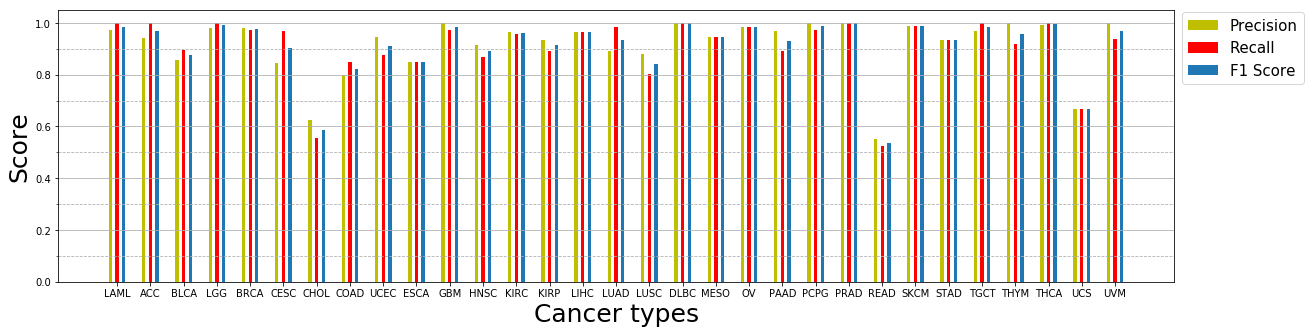

In [44]:
fig = plt.figure(figsize=(20,5))
plt.bar(np.arange(0,len(precision))-0.2,precision,width=0.1,label = 'Precision',color='y')
plt.bar(np.arange(0,len(recall)),recall,width=0.1,label='Recall',color='r')
#plt.plot(['1','2','3','4','5','6','7','8'],list_recall)
plt.bar(np.arange(0,len(fscore))+0.2,fscore,width=0.1,label = 'F1 Score')
plt.ylabel('Score',fontsize=25)
plt.xlabel('Cancer types',fontsize=25)
plt.xticks(np.arange(0,len(precision)),label)

plt.legend(bbox_to_anchor=(1, 1.02),prop={'size':15})
#plt.grid()
ax = plt.axes()
ax.set_yticks([0.1,0.3,0.5,0.7,0.9], minor=True)
ax.yaxis.grid(True,which='major')
ax.yaxis.grid(True,which='minor',linestyle='--')
#fig.savefig('Desktop/paper_figures/'+str('BNN_results')+'.pdf', format='pdf', dpi=1200,bbox_inches='tight')
plt.show()

C:\Users\Prasoon\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


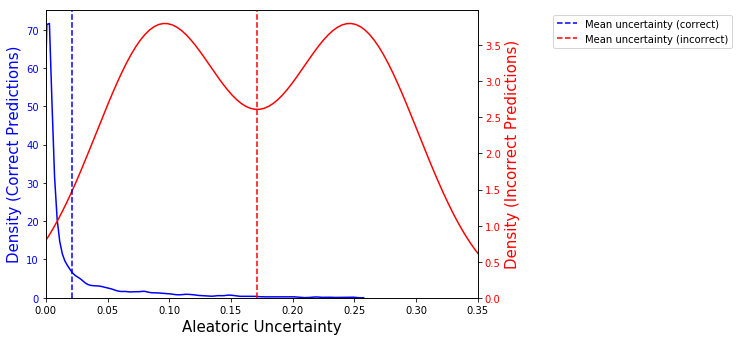

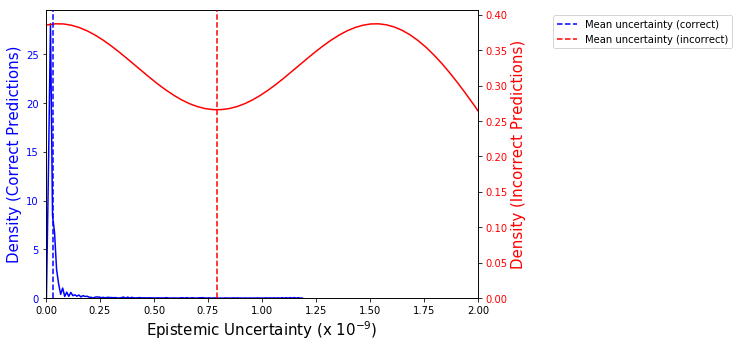

In [60]:
[al_train,mu_train_ac,mu_train_nac] = uncertainty_calculation(logits_train,y_train,arr_pred_train,'Aleatoric','Train',_,'aleatoric_train')
[ep_train,mu_train_ec,mu_train_nec] = uncertainty_calculation(logits_train,y_train,arr_pred_train,'Epistemic','Train',_,'epistemic_train')

In [127]:
arr_pred_test = np.array(arr_pred_test_new)

C:\Users\Prasoon\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


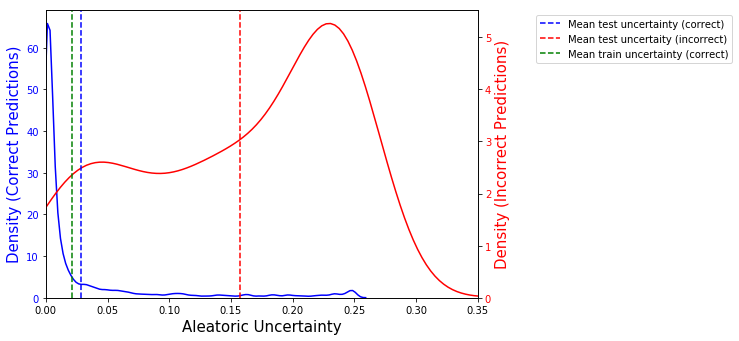

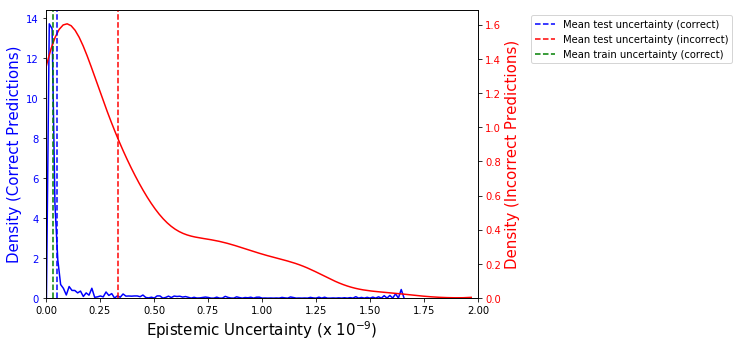

In [61]:
[al_test,mu_test_ac,mu_test_nac] = uncertainty_calculation(logits,y_test,arr_pred_test,'Aleatoric','Test',mu_train_ac,'aleatoric_test')
[ep_test,mu_test_ec,mu_test_nec] = uncertainty_calculation(logits,y_test,arr_pred_test,'Epistemic','Test',mu_train_ec,'epistemic_test')

In [129]:
mu_test_ec

6.711928e-11

In [130]:
mu_test_nec

1.3794481e-10

In [131]:
mu_train_ec

3.074685e-11

In [132]:
mu_test_ec

6.711928e-11

C:\Users\Prasoon\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


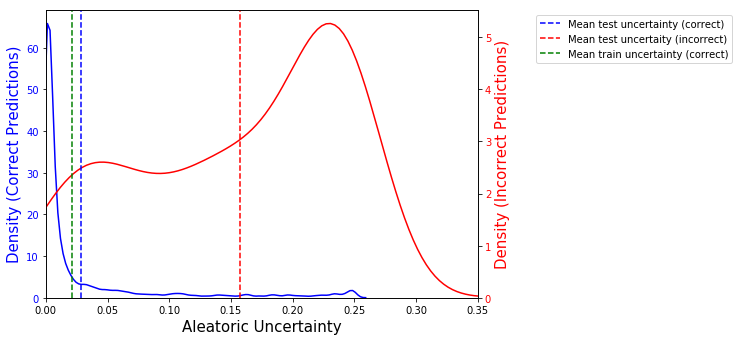

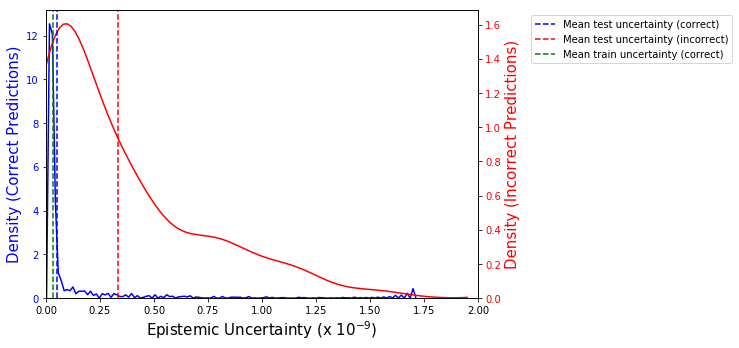

In [277]:
[al_test,mu_test_ac,mu_test_nac] = uncertainty_calculation(logits,y_test,arr_pred_test,'Aleatoric','Test',mu_train_ac,'aleatoric_test')
[ep_test,mu_test_ec,mu_test_nec] = uncertainty_calculation(logits,y_test,arr_pred_test,'Epistemic','Test',mu_train_ec,'epistemic_test')

C:\Users\Prasoon\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


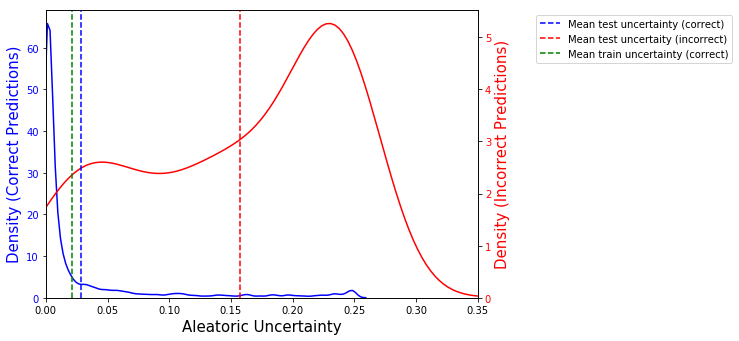

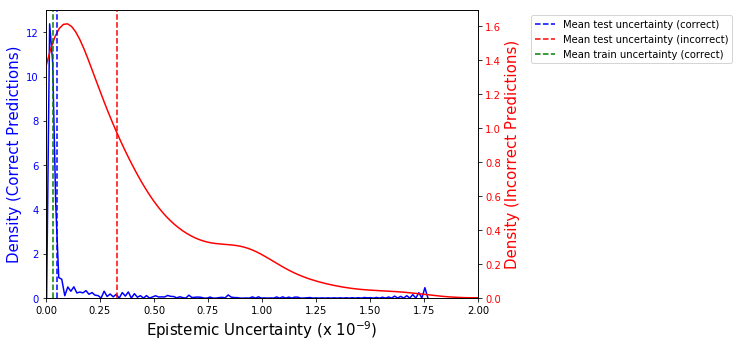

In [46]:
[al_test,mu_test_ac,mu_test_nac] = uncertainty_calculation(logits,y_test,arr_pred_test,'Aleatoric','Test',mu_train_ac,'aleatoric_test')
[ep_test,mu_test_ec,mu_test_nec] = uncertainty_calculation(logits,y_test,arr_pred_test,'Epistemic','Test',mu_train_ec,'epistemic_test')

plt.plot(np.arange(0,5,1),label='Correct Predictions')
plt.plot(np.arange(0,10,1),c='r',label='Incorrect Predictions')
plt.plot(np.arange(0,20,1),c='y',label='Mean uncertainty for correct predictions (test)')
plt.plot(np.arange(0,20,1),c='m',label='Mean uncertainty for incorrect predictions (test)')
plt.plot(np.arange(0,20,1),c='g',label='Mean uncertainty for correct predictions (train)')
plt.legend(bbox_to_anchor=(1,1))

plt.plot(np.arange(0,5,1),label='Correct Predictions')
plt.plot(np.arange(0,10,1),c='r',label='Incorrect Predictions')
plt.plot(np.arange(0,20,1),c='g',label='Mean uncertainty for correct predictions')
plt.plot(np.arange(0,20,1),c='m',label='Mean uncertainty for incorrect predictions')
#plt.plot(np.arange(0,20,1),c='m',label='Mean uncertainty for correct predictions (train)')
plt.legend(bbox_to_anchor=(1,1))

In [122]:
certain_pred = []
certain_test = []
uncer_pred = []
for i in range(len(list(arr_pred_test))):
    if (ep_test[i] <= mu_train_ec) and (al_test[i] <= mu_train_ac):
        certain_pred.append(arr_pred_test[i])
        certain_test.append(np.array(y_test)[i])
    else:
        uncer_pred.append(i)

In [123]:
len(certain_test)

1279

In [124]:
len(certain_pred)

1279

In [125]:
c=0
for i in range(len(certain_test)):
    if certain_pred[i] == certain_test[i]:
        c = c+1

In [126]:
c/len(certain_test)

0.9937451133698202

mu_train_ec

In [48]:
from sklearn.metrics import classification_report

df_overall = pd.DataFrame()
df_specific = pd.DataFrame()
df_original = pd.DataFrame()

df_overall['pred'] = certain_pred
df_overall['test'] = certain_test
df_specific['pred'] = list_final_pred
df_specific['test'] = list_final_test
df_original['pred'] = list(arr_pred_test)
df_original['test'] = list(y_test)

df_overall.to_csv('D:/New Folder/overall.csv')
df_specific.to_csv('D:/New Folder/specific.csv')
df_original.to_csv('D:/New Folder/original.csv')

In [49]:
precision_recall_fscore_support(np.array(y_test),np.array(arr_pred_test),average='micro')

(0.9365781710914455, 0.9365781710914455, 0.9365781710914455, None)

In [50]:
precision_recall_fscore_support(np.array(y_test),np.array(arr_pred_test),average='macro')

(0.9145896359904171, 0.9087614893519588, 0.9110151930472365, None)

In [117]:
label_new = []
for key in Counter(np.array(certain_test)).keys():
    label_new.append(label[key])

In [118]:
precision = precision_recall_fscore_support(np.array(certain_test),np.array(certain_pred))[0]
recall = precision_recall_fscore_support(np.array(certain_test),np.array(certain_pred))[1]
fscore = precision_recall_fscore_support(np.array(certain_test),np.array(certain_pred))[2]
support = precision_recall_fscore_support(np.array(certain_test),np.array(certain_pred))[3]

In [119]:
df_temp = pd.DataFrame()
df_temp['precision'] = list(precision)
df_temp['recall'] = list(recall)
df_temp['fscore'] = list(fscore)
df_temp['support'] = list(support)
#df_temp.to_csv('Desktop/paper_tables/bnn_results_method1.csv')

C:\Users\Prasoon\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


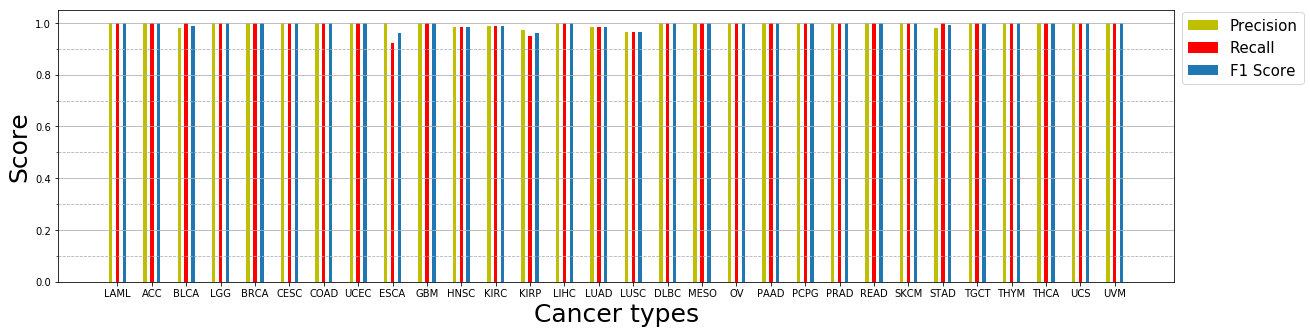

In [53]:
fig = plt.figure(figsize=(20,5))
plt.bar(np.arange(0,len(precision))-0.2,precision,width=0.1,label = 'Precision',color='y')
plt.bar(np.arange(0,len(recall)),recall,width=0.1,label='Recall',color='r')
#plt.plot(['1','2','3','4','5','6','7','8'],list_recall)
plt.bar(np.arange(0,len(fscore))+0.2,fscore,width=0.1,label = 'F1 Score')
plt.ylabel('Score',fontsize=25)
plt.xlabel('Cancer types',fontsize=25)
plt.xticks(np.arange(0,len(precision)),label_new)

plt.legend(bbox_to_anchor=(1, 1.02),prop={'size':15})
#plt.grid()
ax = plt.axes()
ax.set_yticks([0.1,0.3,0.5,0.7,0.9], minor=True)
ax.yaxis.grid(True,which='major')
ax.yaxis.grid(True,which='minor',linestyle='--')
#fig.savefig('Desktop/paper_figures/'+str('train_uncertainty_filtering')+'.pdf', format='pdf', dpi=1200,bbox_inches='tight')
plt.show()

In [68]:
dict_numtrain_samples = Counter(np.array(y_train))
dict_numtest_samples = Counter(np.array(y_test))

In [69]:
dict_result_train = type_wise_results(dict_numtrain_samples,np.array(y_train),arr_pred_train,al_train,ep_train)
dict_result_test = type_wise_results(dict_numtest_samples,np.array(y_test),arr_pred_test,al_test,ep_test)

In [70]:
#detailed_plot(dict_result_train,dict_result_test,uncertainty_type='Aleatoric')
#detailed_plot(dict_result_train,dict_result_test,uncertainty_type='Epistemic')

In [71]:
#dict_mean_al = detailed_plot_new(dict_result_train,'Aleatoric',np.array(y_test),arr_pred_test,al_test)
#dict_mean_ep = detailed_plot_new(dict_result_train,'Epistemic',np.array(y_test),arr_pred_test,ep_test,'temp')

C:\Users\Prasoon\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Prasoon\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


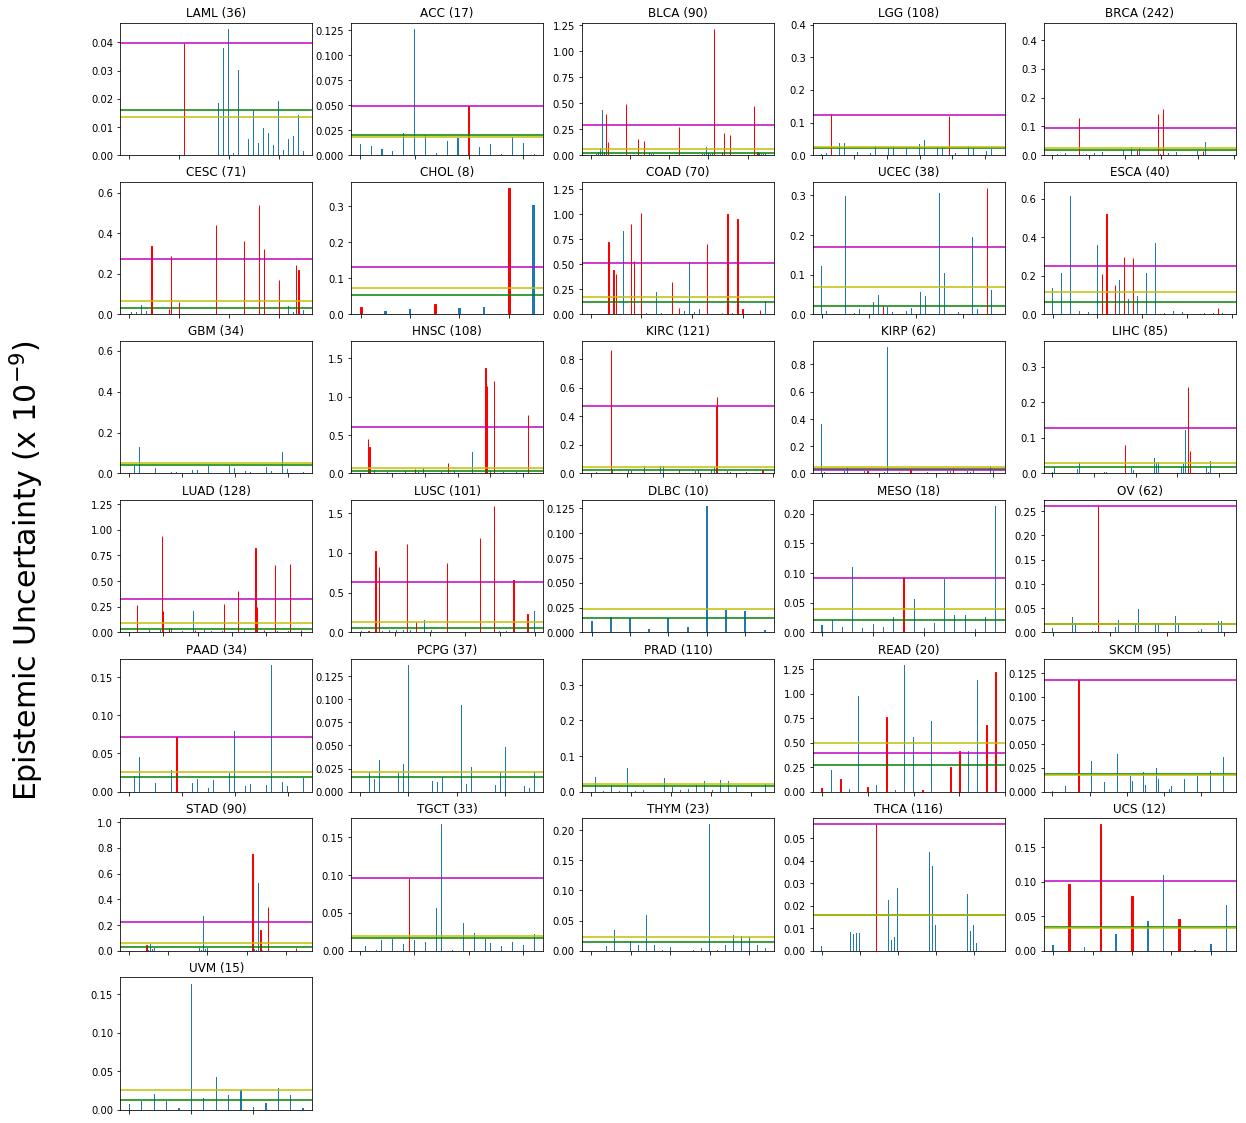

In [72]:
dict_mean_ep,dict_mean_test_corr,dict_mean_test_incorr = detailed_plot_new(dict_result_train,'Epistemic',np.array(y_test),arr_pred_test,ep_test,'epistemic_uncertainty_cancer_wise')

In [ ]:
dict_mean_ep,dict_mean_test_corr,dict_mean_test_incorr = detailed_plot_new(dict_result_train,'Epistemic',np.array(y_test),arr_pred_test,ep_test,'epistemic_uncertainty_cancer_wise')

In [218]:
df_temp = pd.DataFrame()
df_temp['train_mean'] = list(dict_mean_ep.values())
df_temp['test_mean_correct'] = list(dict_mean_test_corr.values())
df_temp['test_mean_incorrect'] = list(dict_mean_test_incorr.values())
df_temp.to_csv('Desktop/paper_tables/detailed_uncertainty_epistemic.csv')

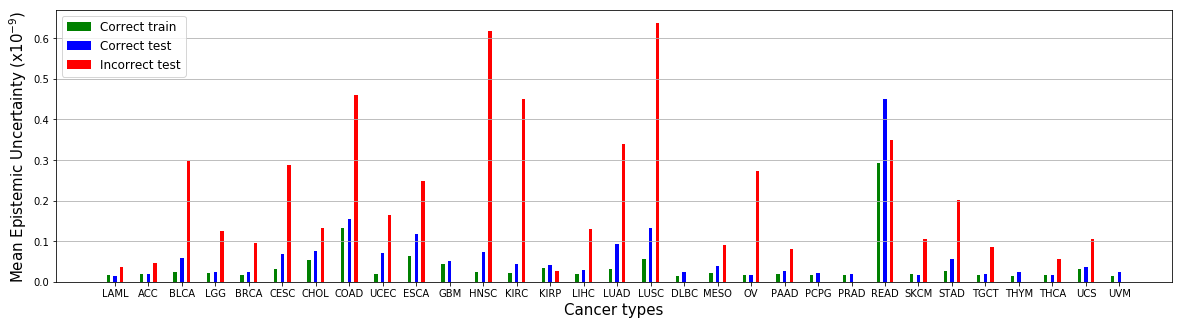

In [59]:
fig = plt.figure(figsize=(20,5))
for key in dict_mean_test_corr.keys():
    plt.bar(key-0.2,dict_mean_ep[key],width=0.1,color='green')
    plt.bar(key,dict_mean_test_corr[key],width=0.1,color='blue')
    plt.bar(key+0.2,dict_mean_test_incorr[key],width=0.1,color='red')
    if key == 30:
        plt.bar(key-0.2,dict_mean_ep[key],width=0.1,color='green',label='Correct train')
        plt.bar(key,dict_mean_test_corr[key],width=0.1,color='blue',label='Correct test')
        plt.bar(key+0.2,dict_mean_test_incorr[key],width=0.1,color='red',label = 'Incorrect test')
plt.ylabel('Mean Epistemic Uncertainty (x'+str(r'$10^{-9}$')+')',fontsize=15)
plt.xlabel('Cancer types',fontsize=15)
plt.xticks(np.arange(0,31),label)
plt.legend(prop={'size':12})
ax = plt.gca()
ax.yaxis.grid(True,which='major')
#ax.yaxis.grid(True,which='minor',linestyle='--')
#fig.savefig('Desktop/paper_figures/'+str('epistemic_uncertainty_results')+'.pdf', format='pdf', dpi=1200,bbox_inches='tight')
plt.show()

C:\Users\Prasoon\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Prasoon\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Prasoon\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:718: RuntimeWarning: invalid value encountered in less
  scaley = (yy < ymin) or (yy > ymax)
C:\Users\Prasoon\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:718: RuntimeWarning: invalid value encountered in greater
  scaley = (yy < ymin) or (yy > ymax)


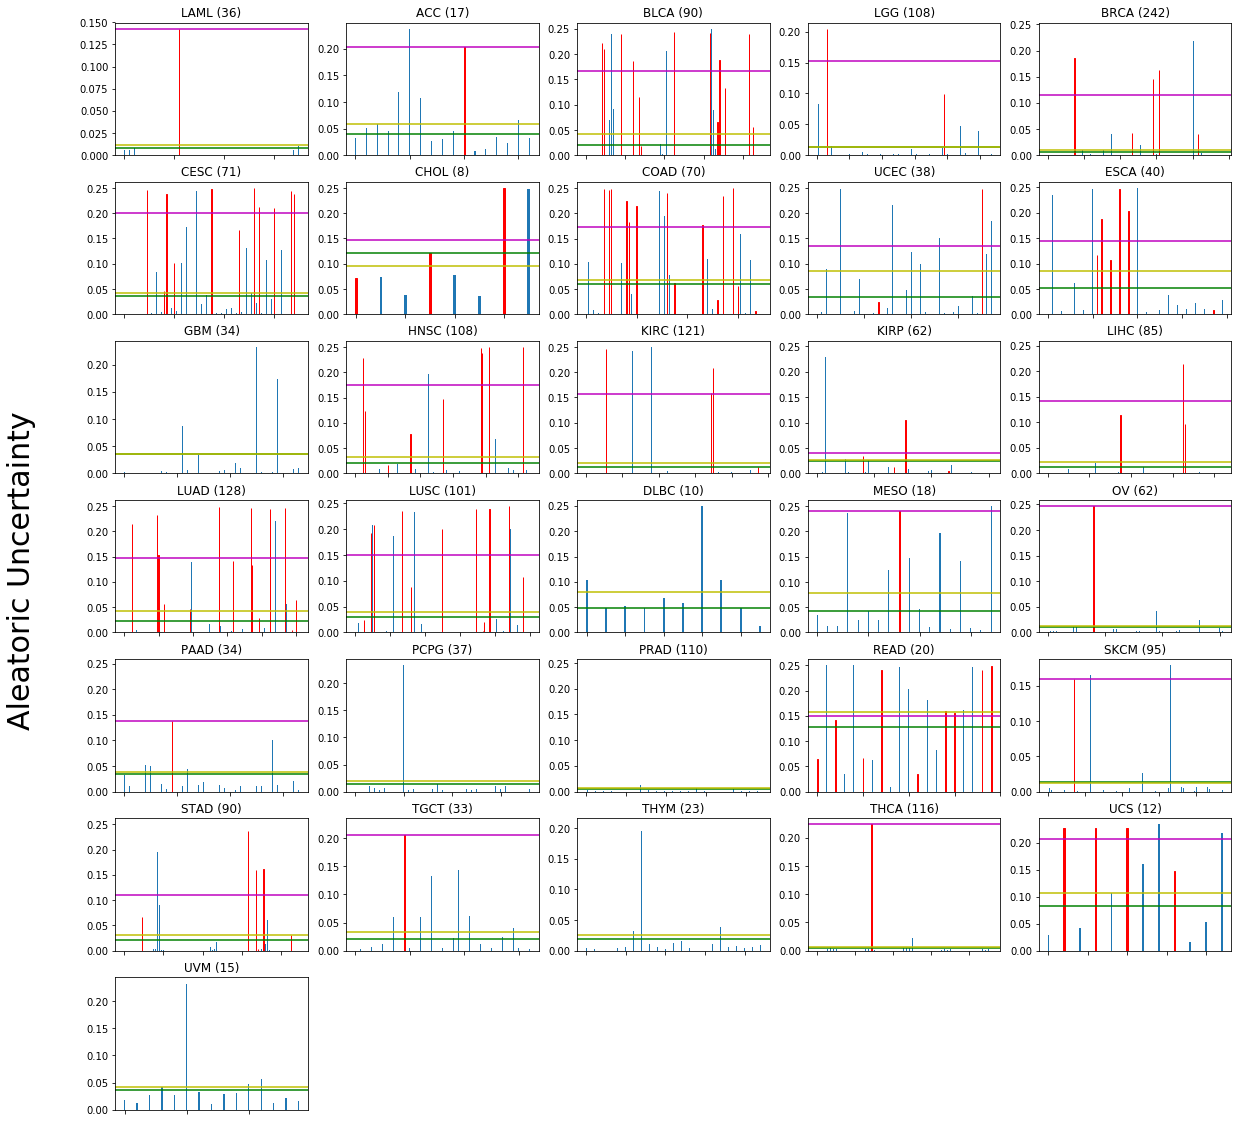

In [73]:
dict_mean_al,dict_mean_test_corr,dict_mean_test_incorr = detailed_plot_new(dict_result_train,'Aleatoric',np.array(y_test),arr_pred_test,al_test,'test1')

C:\Users\Prasoon\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Prasoon\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Prasoon\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:718: RuntimeWarning: invalid value encountered in less
  scaley = (yy < ymin) or (yy > ymax)
C:\Users\Prasoon\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:718: RuntimeWarning: invalid value encountered in greater
  scaley = (yy < ymin) or (yy > ymax)


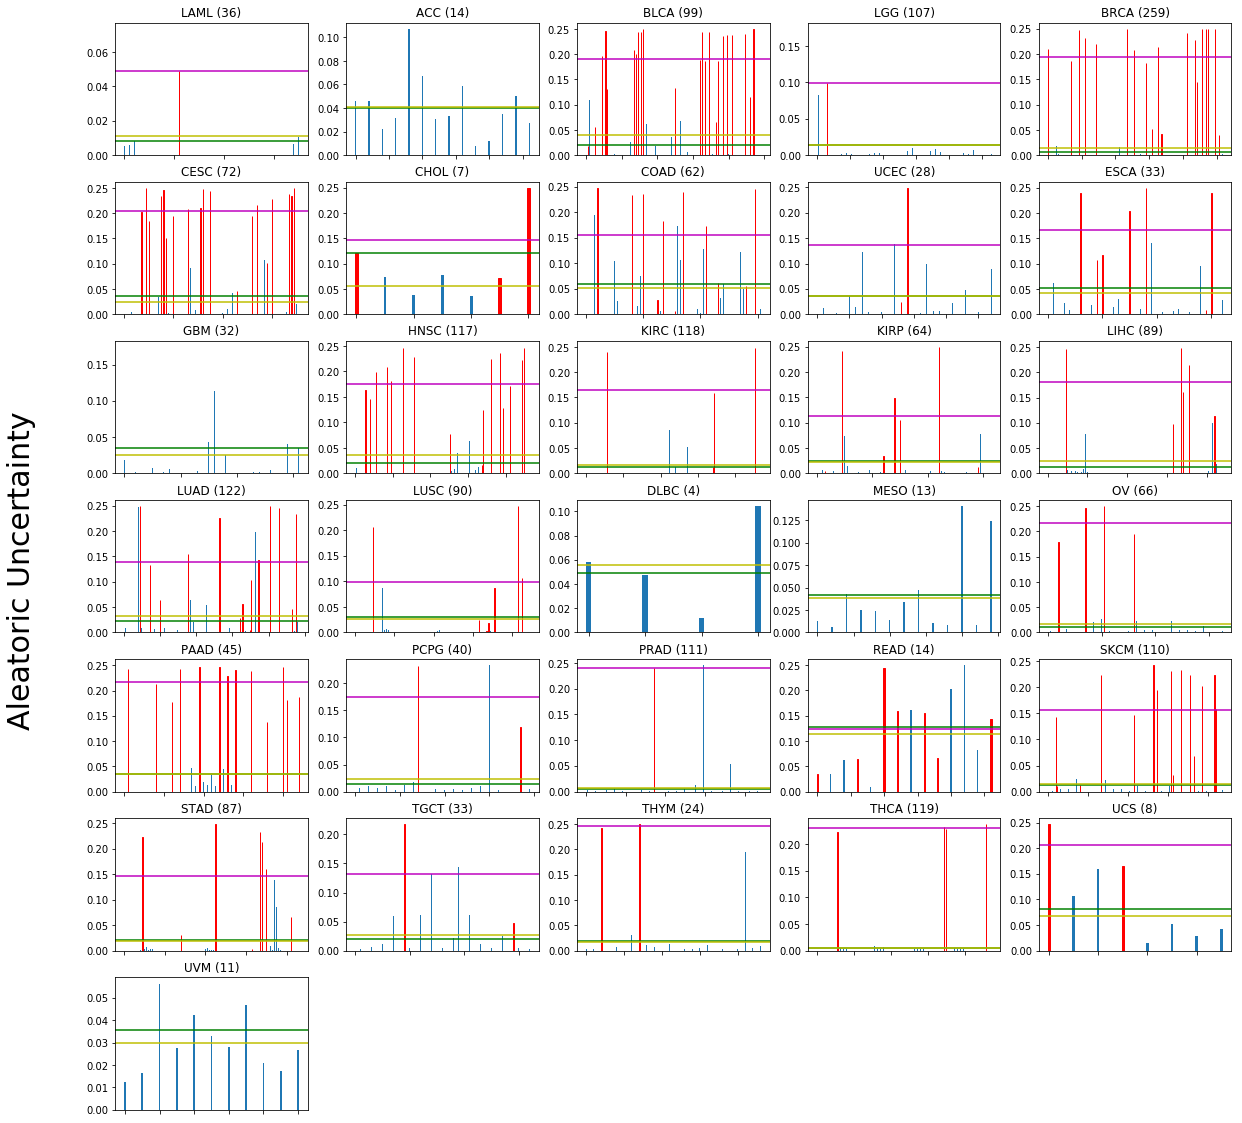

In [134]:
dict_mean_al,dict_mean_test_corr,dict_mean_test_incorr = detailed_plot_new(dict_result_train,'Aleatoric',np.array(y_test),arr_pred_test,al_test,'test1')

In [221]:
df_temp = pd.DataFrame()
df_temp['train_mean'] = list(dict_mean_al.values())
df_temp['test_mean_correct'] = list(dict_mean_test_corr.values())
df_temp['test_mean_incorrect'] = list(dict_mean_test_incorr.values())
df_temp.to_csv('Desktop/paper_tables/detailed_uncertainty_aleatoric.csv')

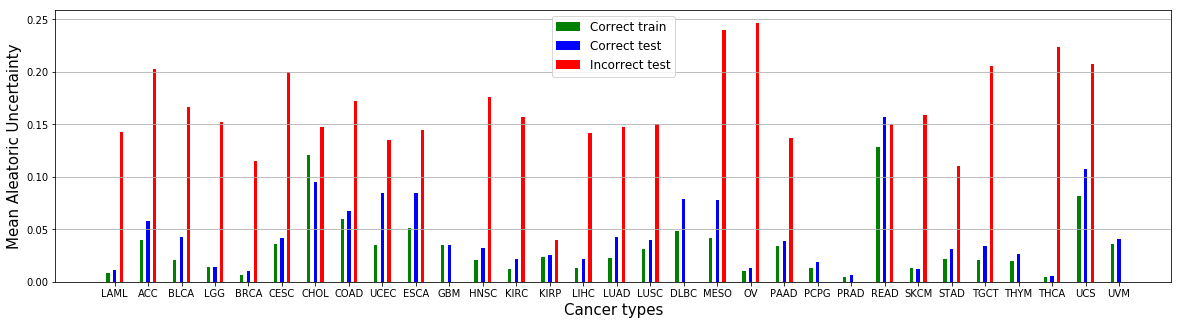

In [61]:
fig = plt.figure(figsize=(20,5))
for key in dict_mean_test_corr.keys():
    plt.bar(key-0.2,dict_mean_al[key],width=0.1,color='green')
    plt.bar(key,dict_mean_test_corr[key],width=0.1,color='blue')
    plt.bar(key+0.2,dict_mean_test_incorr[key],width=0.1,color='red')
    if key == 30:
        plt.bar(key-0.2,dict_mean_al[key],width=0.1,color='green',label='Correct train')
        plt.bar(key,dict_mean_test_corr[key],width=0.1,color='blue',label='Correct test')
        plt.bar(key+0.2,dict_mean_test_incorr[key],width=0.1,color='red',label = 'Incorrect test')
plt.ylabel('Mean Aleatoric Uncertainty',fontsize=15)
plt.xlabel('Cancer types',fontsize=15)
plt.xticks(np.arange(0,31),label)
plt.legend(prop={'size':12})
ax = plt.gca()
ax.yaxis.grid(True,which='major')
#ax.yaxis.grid(True,which='minor',linestyle='--')
#fig.savefig('Desktop/paper_figures/'+str('aleatoric_uncertainty_results')+'.pdf', format='pdf', dpi=1200,bbox_inches='tight')
plt.show()

In [127]:
list_final_pred = []
list_final_test = []
uncertain = []
for i in range(len(arr_pred_test)):
    if (al_test[i] <= dict_mean_al[arr_pred_test[i]]) and (ep_test[i]*1e9 <= dict_mean_ep[arr_pred_test[i]]):
        list_final_test.append(np.array(y_test)[i])
        list_final_pred.append(arr_pred_test[i])
    #if (ep_test[i]*1e9 <= dict_mean_ep[arr_pred_test[i]]):
        #list_final_test.append(np.array(y_test)[i])
        #list_final_pred.append(arr_pred_test[i])
    
    else:
        uncertain.append(i)

In [128]:
start_index = 0
#for i in range(2):
    #print(i)
    #temp_index = Counter(y_test)[i]
#end_index = start_index+temp_index
logits_temp = np.array(logits)[:,:,np.array(uncertain)]
adjusted_logits_temp = uncertainty(logits_temp,0)
print(np.array(adjusted_logits_temp).shape)
#if i == 0:
    #adjusted_logits_complete = np.array(adjusted_logits_temp)
#else:
    #adjusted_logits_complete = np.concatenate((adjusted_logits_complete,np.array(adjusted_logits_temp)),axis=1)
#start_index = end_index

(31, 1008)


In [129]:
res = adjusted_logits_temp

In [95]:
np.array(y_test)[[np.array(uncertain)]]

C:\Users\Prasoon\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,
        7,  7,  7,  7,  7

In [98]:
np.argmax(np.array(res)[:,i])

IndexError: index 801 is out of bounds for axis 1 with size 801

In [105]:
np.array(res)[:,0].shape

(31,)

In [109]:
res

[array([5.44069662e-05, 1.31143679e-06, 5.10810532e-05, 4.14229609e-04,
        1.32401561e-04, 8.45764407e-06, 3.71481583e-04, 8.14966334e-04,
        1.65947620e-03, 2.48233573e-06, 6.59715079e-05, 1.05684635e-03,
        1.29598571e-04, 2.75223487e-04, 3.57320960e-06, 2.08145895e-04,
        4.39361742e-07, 1.47285746e-07, 1.06545340e-03, 4.69500752e-04,
        4.99686459e-04, 7.62502241e-05, 6.17539081e-06, 8.86396228e-05,
        7.16581999e-04, 2.71222118e-04, 3.28140413e-05, 7.77390142e-07,
        1.51133427e-05, 1.24085018e-05, 3.31593328e-04, 1.77987837e-04,
        2.95650239e-06, 6.17414989e-05, 2.77057727e-04, 1.26960324e-04,
        7.00386081e-05, 1.40182372e-08, 1.23962076e-04, 1.79021139e-04,
        8.35241423e-08, 2.50289362e-04, 2.33880593e-03, 9.11984301e-08,
        1.00290322e-06, 1.07080943e-07, 2.67490890e-07, 2.73633027e-03,
        2.70811797e-05, 3.00956344e-05, 8.41418339e-04, 1.97254427e-04,
        6.84371025e-06, 1.02561364e-06, 2.27027522e-05, 9.780935

In [130]:
arr_pred_test_new = []
counter = 0
for i in range(np.array(res).shape[1]):
    if np.argmax(np.array(res)[:,i]) == list(np.array(y_test)[np.array(uncertain)])[i]:
        counter = counter+1
    arr_pred_test_new.append(np.argmax(np.array(res)[:,i]))

In [131]:
counter/len(arr_pred_test_new)

0.6934523809523809

In [112]:
res = logits[0]

In [114]:
res.shape

(31, 2034)

In [118]:
arr_pred_test_new = []
counter = 0
for i in range(801):
    if np.argmax(np.array(res)[:,uncertain[i]]) == list(np.array(y_test)[np.array(uncertain)])[i]:
        counter = counter+1
    arr_pred_test_new.append(np.argmax(np.array(res)[:,i]))

In [119]:
counter/len(arr_pred_test_new)

0.8751560549313359

In [81]:
logits_temp = np.array(logits)[:,:,np.array(uncertain)]

(500, 31, 801)

In [79]:
np.array(logits).shape

(500, 31, 2034)

In [78]:
len(list_final_pred)

1233

In [138]:
len(list_final_pred)

1028

In [136]:
accuracy_score(list_final_test,list_final_pred)

0.9834630350194552

In [64]:
precision = precision_recall_fscore_support(np.array(list_final_test),np.array(list_final_pred))[0]
recall = precision_recall_fscore_support(np.array(list_final_test),np.array(list_final_pred))[1]
fscore = precision_recall_fscore_support(np.array(list_final_test),np.array(list_final_pred))[2]
support = precision_recall_fscore_support(np.array(list_final_test),np.array(list_final_pred))[3]

In [340]:
df_temp = pd.DataFrame()
df_temp['precision'] = list(precision)
df_temp['recall'] = list(recall)
df_temp['fscore'] = list(fscore)
df_temp['support'] = list(support)
df_temp.to_csv('Desktop/paper_tables/bnn_results_method2.csv')

C:\Users\Prasoon\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


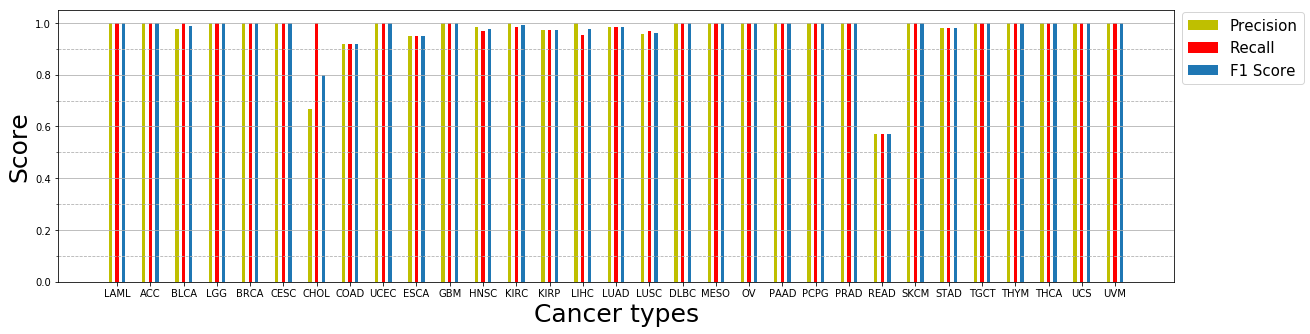

In [65]:
fig = plt.figure(figsize=(20,5))
plt.bar(np.arange(0,len(precision))-0.2,precision,width=0.1,label = 'Precision',color='y')
plt.bar(np.arange(0,len(recall)),recall,width=0.1,label='Recall',color='r')
#plt.plot(['1','2','3','4','5','6','7','8'],list_recall)
plt.bar(np.arange(0,len(fscore))+0.2,fscore,width=0.1,label = 'F1 Score')
plt.ylabel('Score',fontsize=25)
plt.xlabel('Cancer types',fontsize=25)
plt.xticks(np.arange(0,len(precision)),label)

plt.legend(bbox_to_anchor=(1, 1.02),prop={'size':15})
#plt.grid()
ax = plt.axes()
ax.set_yticks([0.1,0.3,0.5,0.7,0.9], minor=True)
ax.yaxis.grid(True,which='major')
ax.yaxis.grid(True,which='minor',linestyle='--')
#fig.savefig('Desktop/paper_figures/'+str('cancer_type_uncertainty_filtering')+'.pdf', format='pdf', dpi=1200,bbox_inches='tight')
plt.show()

In [326]:
acc_1= []
sam_1 = []
list_temp = np.arange(0.1,5.1,0.1)
for j in list_temp:
    certain_pred = []
    certain_test = []
    for i in range(len(list(arr_pred_test))):
        if (ep_test[i] <= j * mu_train_ec) and (al_test[i] <= j* mu_train_ac):
            certain_pred.append(arr_pred_test[i])
            certain_test.append(np.array(y_test)[i])
    acc_1.append(accuracy_score(certain_test,certain_pred))
    sam_1.append(len(certain_pred))

In [327]:
acc_2 = []
l_temp = np.arange(0.1,5.1,0.1)
sam_2 = []
for j in l_temp:
    list_final_pred = []
    list_final_test = []
    for i in range(len(arr_pred_test)):
        if (al_test[i] <= j* dict_mean_al[arr_pred_test[i]]) and (ep_test[i]*1e9 <= j* dict_mean_ep[arr_pred_test[i]]):
            list_final_test.append(np.array(y_test)[i])
            list_final_pred.append(arr_pred_test[i])
    acc_2.append(accuracy_score(list_final_test,list_final_pred))
    sam_2.append(len(list_final_test))

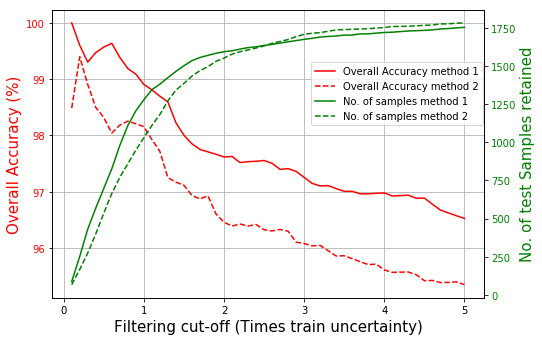

In [329]:
fig = plt.figure()
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes()
ax2 = ax1.twinx()
l1 = ax1.plot(l_temp,np.array(acc_2)*100,c='r',linestyle='--',label='Overall Accuracy method 2')
l2 = ax1.plot(l_temp,np.array(acc_1)*100,c='r',label='Overall Accuracy method 1')
ax1.tick_params(axis='y', labelcolor='r')
l3 = ax2.plot(l_temp,sam_2,c='g',linestyle = '--',label = 'No. of samples method 2' )
l4 = ax2.plot(l_temp,sam_1,c='g',label='No. of samples method 1')
ax2.tick_params(axis='y', labelcolor='g')
leg = l2+l1+l4+l3
ax1.set_ylabel('Overall Accuracy (%)', color='r',fontsize=15)
ax2.set_ylabel('No. of test Samples retained', color='g',fontsize=15)
ax1.set_xlabel('Filtering cut-off (Times train uncertainty)',fontsize=15)
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc=(0.6,0.6))
#ax2.set_yticks(np.arange(0,2000,225))
#ax1.set_yticks(np.arange(0.96*100,1.005*100,0.005*100))
#ax1.legend(bbox_to_anchor=(1,0.65))
#ax2.legend(bbox_to_anchor=(0.99,0.80))
#ax2.grid(None)
#ax2.set_yticks(np.linspace(ax2.get_yticks()[0],ax2.get_yticks()[-1],len(ax1.get_yticks())))
ax1.grid()
#fig.savefig('Desktop/paper_figures/'+str('times_train_uncertainty_plot')+'.pdf', format='pdf', dpi=1200,bbox_inches='tight')
plt.show()

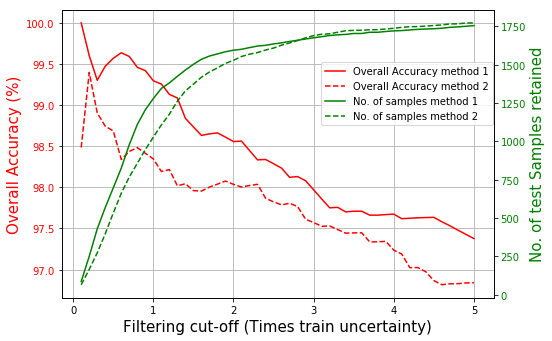

In [146]:
fig = plt.figure()
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes()
ax2 = ax1.twinx()
l1 = ax1.plot(l_temp,np.array(acc_2)*100,c='r',linestyle='--',label='Overall Accuracy method 2')
l2 = ax1.plot(l_temp,np.array(acc_1)*100,c='r',label='Overall Accuracy method 1')
ax1.tick_params(axis='y', labelcolor='r')
l3 = ax2.plot(l_temp,sam_2,c='g',linestyle = '--',label = 'No. of samples method 2' )
l4 = ax2.plot(l_temp,sam_1,c='g',label='No. of samples method 1')
ax2.tick_params(axis='y', labelcolor='g')
leg = l2+l1+l4+l3
ax1.set_ylabel('Overall Accuracy (%)', color='r',fontsize=15)
ax2.set_ylabel('No. of test Samples retained', color='g',fontsize=15)
ax1.set_xlabel('Filtering cut-off (Times train uncertainty)',fontsize=15)
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc=(0.6,0.6))
#ax2.set_yticks(np.arange(0,2000,225))
#ax1.set_yticks(np.arange(0.96*100,1.005*100,0.005*100))
#ax1.legend(bbox_to_anchor=(1,0.65))
#ax2.legend(bbox_to_anchor=(0.99,0.80))
#ax2.grid(None)
#ax2.set_yticks(np.linspace(ax2.get_yticks()[0],ax2.get_yticks()[-1],len(ax1.get_yticks())))
ax1.grid()
#fig.savefig('Desktop/paper_figures/'+str('times_train_uncertainty_plot')+'.pdf', format='pdf', dpi=1200,bbox_inches='tight')
plt.show()

In [351]:
precision = precision_recall_fscore_support(np.array(y_test),np.array(arr_pred_test))[0]
recall = precision_recall_fscore_support(np.array(y_test),np.array(arr_pred_test))[1]
fscore_1 = precision_recall_fscore_support(np.array(y_test),np.array(arr_pred_test))[2]
support = precision_recall_fscore_support(np.array(y_test),np.array(arr_pred_test))[3]

In [352]:
precision = precision_recall_fscore_support(np.array(certain_test),np.array(certain_pred))[0]
recall = precision_recall_fscore_support(np.array(certain_test),np.array(certain_pred))[1]
fscore_2 = precision_recall_fscore_support(np.array(certain_test),np.array(certain_pred))[2]
support = precision_recall_fscore_support(np.array(certain_test),np.array(certain_pred))[3]

In [353]:
precision = precision_recall_fscore_support(np.array(list_final_test),np.array(list_final_pred))[0]
recall = precision_recall_fscore_support(np.array(list_final_test),np.array(list_final_pred))[1]
fscore_3 = precision_recall_fscore_support(np.array(list_final_test),np.array(list_final_pred))[2]
support = precision_recall_fscore_support(np.array(list_final_test),np.array(list_final_pred))[3]

In [354]:
label_new_adjusted = []
fscore_adjusted = []
for i in range(31):
    if i == 6:
        fscore_adjusted.append(0)
        label_new_adjusted.append('CHOL')
    if i>6:
        fscore_adjusted.append(fscore_2[i-1])
        label_new_adjusted.append(label_new[i-1])
    if i<6:
        fscore_adjusted.append(fscore_2[i])
        label_new_adjusted.append(label_new[i])

C:\Users\Prasoon\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


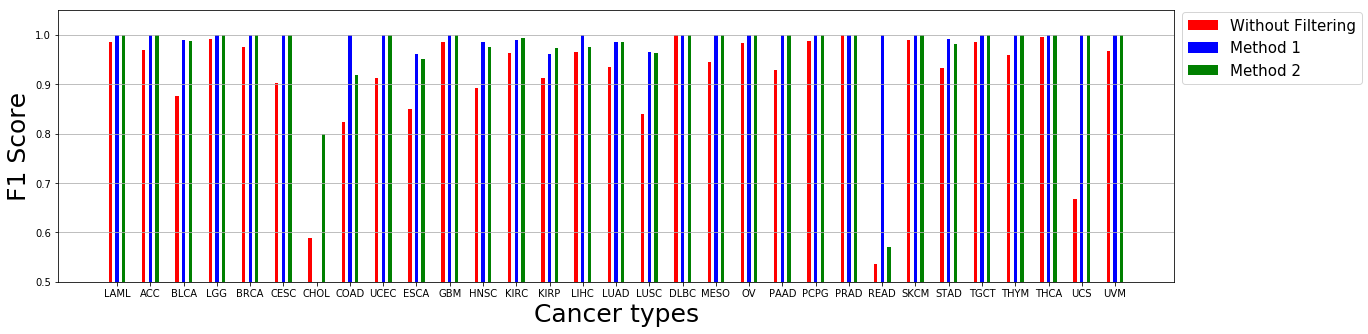

In [355]:
fig = plt.figure(figsize=(20,5))
plt.bar(np.arange(0,len(fscore_1))-0.2,fscore_1,label = 'Without Filtering',color='r',width=0.1)
#plt.bar(np.arange(0,len(fscore_1)),fscore_1,width=0.1,label = '1')
plt.bar(np.arange(0,len(fscore_adjusted)),np.array(fscore_adjusted),label='Method 1',color='b',width=0.1)
#plt.plot(['1','2','3','4','5','6','7','8'],list_recall)
plt.bar(np.arange(0,len(fscore_3))+0.2,fscore_3,label = 'Method 2',color='g',width=0.1)
plt.ylabel('F1 Score',fontsize=25)
plt.xlabel('Cancer types',fontsize=25)
plt.xticks(np.arange(0,len(precision)),label)
plt.ylim((0.5,1.05))
plt.legend(bbox_to_anchor=(1, 1.02),prop={'size':15})
ax = plt.axes()
#ax.set_yticks([0.1,0.3,0.5,0.7,0.9], minor=True)
ax.yaxis.grid(True,which='major')
#ax.yaxis.grid(True,which='minor',linestyle='--')
#fig.savefig('Desktop/paper_figures/'+str('criteria_comparison')+'.pdf', format='pdf', dpi=1200,bbox_inches='tight')
plt.show()
#plt.grid()
#ax = plt.axes()
#ax.set_yticks([0.1,0.3,0.5,0.7,0.9], minor=True)
#ax.yaxis.grid(True,which='major')
#ax.yaxis.grid(True,which='minor',linestyle='--')

C:\Users\Prasoon\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


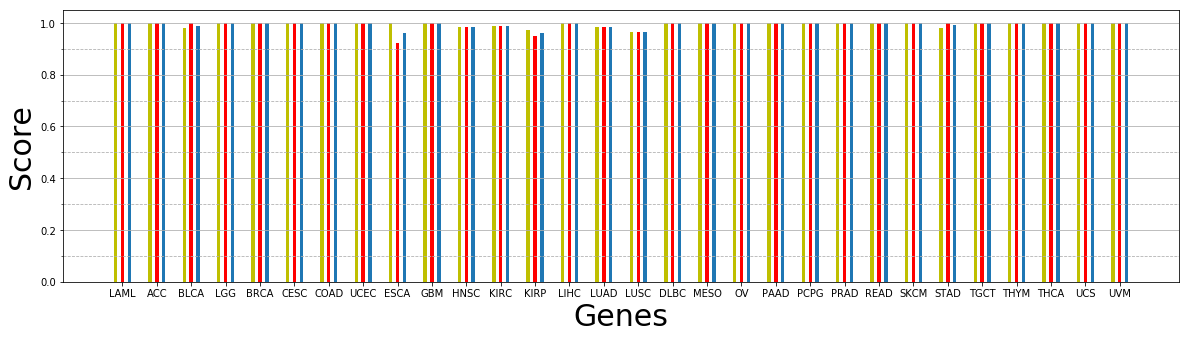

In [400]:
plt.figure(figsize=(20,5))
plt.bar(np.arange(0,len(precision))-0.2,precision,width=0.1,label = 'Precision',color='y')
plt.bar(np.arange(0,len(recall)),recall,width=0.1,label='Recall',color='red')
#plt.plot(['1','2','3','4','5','6','7','8'],list_recall)
plt.bar(np.arange(0,len(fscore))+0.2,fscore,width=0.1,label = 'F1-Score')
plt.ylabel('Score',fontsize=30)
plt.xlabel('Genes',fontsize=30)
plt.xticks(np.arange(0,len(precision)),label_new)

#plt.legend(bbox_to_anchor=(1, 1.02),fontsize=15)
#plt.grid()
ax = plt.axes()
ax.set_yticks([0.1,0.3,0.5,0.7,0.9], minor=True)
ax.yaxis.grid(True,which='major')
ax.yaxis.grid(True,which='minor',linestyle='--')

C:\Users\Prasoon\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


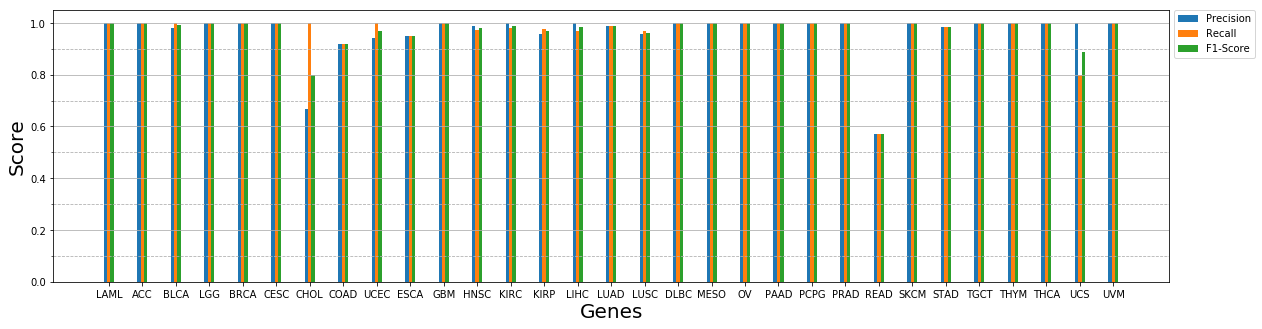

In [301]:
plt.figure(figsize=(20,5))
plt.bar(np.arange(0,len(precision))-0.1,precision,width=0.1,label = 'Precision')
plt.bar(np.arange(0,len(recall)),recall,width=0.1,label='Recall')
#plt.plot(['1','2','3','4','5','6','7','8'],list_recall)
plt.bar(np.arange(0,len(fscore))+0.1,fscore,width=0.1,label = 'F1-Score')
plt.ylabel('Score',fontsize=20)
plt.xlabel('Genes',fontsize=20)
plt.xticks(np.arange(0,len(precision)),label)

plt.legend(bbox_to_anchor=(1, 1.02))
#plt.grid()
ax = plt.axes()
ax.set_yticks([0.1,0.3,0.5,0.7,0.9], minor=True)
ax.yaxis.grid(True,which='major')
ax.yaxis.grid(True,which='minor',linestyle='--')

In [35]:
entropy_list_test = []
for i in range(logits[0].shape[1]):
    entropy = np.sum(-1 * np.multiply(logits[0][:,i],np.log2(logits[0][:,i])))
    entropy_list_test.append(entropy)

In [36]:
entropy_list_train = []
for i in range(logits_train[0].shape[1]):
    entropy = np.sum(-1 * np.multiply(logits_train[0][:,i],np.log2(logits_train[0][:,i])))
    entropy_list_train.append(entropy)

In [37]:
d_train = pd.DataFrame(entropy_list_train)
d_test = pd.DataFrame(entropy_list_test)

In [38]:
d_train.to_csv('Desktop/entropy_train.csv',index=False)
d_test.to_csv('Desktop/entropy_test.csv',index=False)

In [71]:
df_logits_test = pd.DataFrame(logits)
df_logits_train = pd.DataFrame(logits_train)

In [72]:
df_logits_test.to_csv('Desktop/logits_bnn_train.csv',index=False)
df_logits_test.to_csv('Desktop/logits_bnn_test.csv',index=False)

In [ ]:
accuracy = (np.sum(y_test == arr_pred_test) / len(y_test))*100

# External Validation for cancer types

In [360]:
np.random.seed(0)
r = np.random.randint(500)
(X_train, X_test, y_train, y_test) = split_train_test(df_pca2,r)

In [361]:
df_test = pd.read_csv('Desktop/combined_external.csv')

In [362]:
df_test = df_test[df_test['label'] == 4] 

In [363]:
X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]

In [364]:
Ytrain = np.array(y_train).reshape(len(y_train),)
X_train = np.array(X_train.T.reset_index(drop=True))
Y_train = tf.Session().run(tf.one_hot(Ytrain,len(set(Ytrain)),axis=1)).reshape(len(Ytrain),len(set(Ytrain))).T
Ytest = np.array(y_test).reshape(len(y_test),)
X_test = np.array(X_test.T.reset_index(drop=True))
Y_test = tf.Session().run(tf.one_hot(Ytest,len(set(Ytest)),axis=1)).reshape(len(Ytest),len(set(Ytest))).T

In [408]:
entropy_list_external = []
for i in range(logits[0].shape[1]):
    entropy = np.sum(-1 * np.multiply(logits[0][:,i],np.log2(logits[0][:,i])))
    entropy_list_external.append(entropy)

In [47]:
d = pd.DataFrame(entropy_list_external)

In [48]:
d.to_csv('Desktop/entropy_external.csv',index=False)

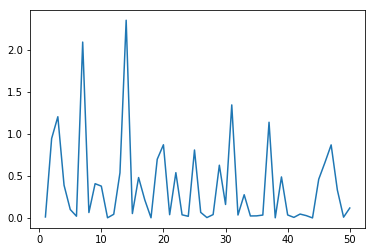

In [70]:
plt.plot(np.arange(1,51),np.array(entropy_list))

In [365]:
layers_dims = [X_train.shape[0],250,95,31]
[_,_,logits,logits_train,arr_pred_test,arr_pred_train] = model(X_train=X_train,Y_train=Y_train,X_test =X_test,Y_test = Y_test, learning_rate=0.0005,num_epochs=3500,print_cost=True,layers_dims = layers_dims)

Cost after epoch 0: 100.214638
Cost after epoch 100: 98.668396
Cost after epoch 200: 97.784966
Cost after epoch 300: 97.394218
Cost after epoch 400: 97.209717
Cost after epoch 500: 97.043793
Cost after epoch 600: 96.973923
Cost after epoch 700: 96.903824
Cost after epoch 800: 96.873451
Cost after epoch 900: 94.251862
Cost after epoch 1000: 94.231339
Cost after epoch 1100: 94.145981
Cost after epoch 1200: 94.149834
Cost after epoch 1300: 94.132957
Cost after epoch 1400: 94.144089
Cost after epoch 1500: 94.114418
Cost after epoch 1600: 92.242096
Cost after epoch 1700: 92.206703
Cost after epoch 1800: 92.249779
Cost after epoch 1900: 92.191315
Cost after epoch 2000: 92.212646
Cost after epoch 2100: 90.734207
Cost after epoch 2200: 90.751938
Cost after epoch 2300: 90.727829
Cost after epoch 2400: 90.691910
Cost after epoch 2500: 89.541817
Cost after epoch 2600: 89.578423
Cost after epoch 2700: 89.524017
Cost after epoch 2800: 88.507179
Cost after epoch 2900: 88.540108
Cost after epoch 3000

In [417]:
#arr_pred_test

In [418]:
#y_test

C:\Users\Prasoon\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


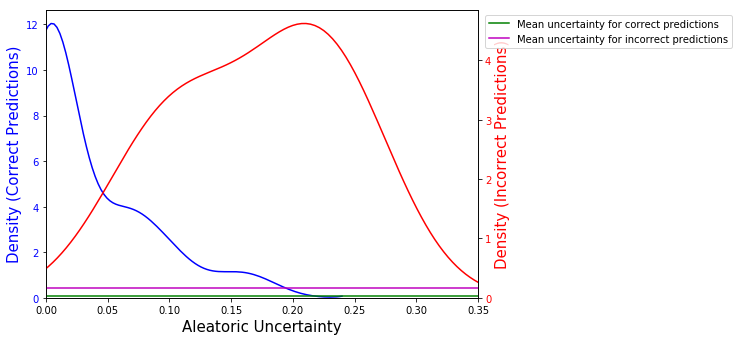

In [366]:
[al_val,mu_val_ac,mu_val_nac] = uncertainty_calculation(logits,y_test,arr_pred_test,'Aleatoric','Validation',_,'validation_uncertainty')

In [367]:
#[al_val,mu_val_ac,mu_val_nac] = uncertainty_calculation(logits,y_test,arr_pred_test,'Aleatoric','Train',_)

C:\Users\Prasoon\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


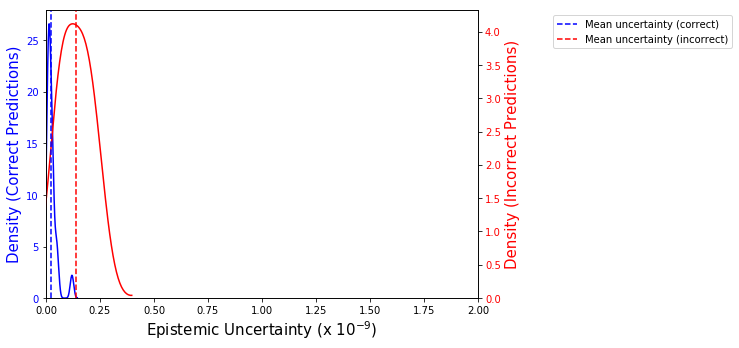

In [368]:
[ep_val,mu_val_ec,mu_val_nec] = uncertainty_calculation(logits,y_test,arr_pred_test,'Epistemic','Train',_,'temp')

In [369]:
list_final_pred_val = []
list_final_test_val = []
for i in range(len(arr_pred_test)):
    if (al_val[i] <= mu_train_ac) and (ep_val[i] <= mu_train_ec):
        list_final_test_val.append(np.array(y_test)[i])
        list_final_pred_val.append(arr_pred_test[i])

In [372]:
list_final_pred_val = []
list_final_test_val = []
for i in range(len(arr_pred_test)):
    if (al_val[i] <= dict_mean_al[arr_pred_test[i]]) and (ep_val[i]*1e9 <= dict_mean_ep[arr_pred_test[i]]):
        list_final_test_val.append(np.array(y_test)[i])
        list_final_pred_val.append(arr_pred_test[i])

In [373]:
len(list_final_test_val)

14

In [374]:
accuracy_score(list_final_test_val,list_final_pred_val)

1.0

In [437]:
certain_pred_val = []
certain_test_val = []
for i in range(len(list(arr_pred_test))):
    if (ep_val[i] <= mu_train_ec) and (al_val[i] <= mu_train_ac):
        certain_pred_val.append(arr_pred_test[i])
        certain_test_val.append(np.array(y_test)[i])

In [439]:
accuracy_score(certain_test_val,certain_pred_val)

1.0

In [66]:
df_logits = pd.DataFrame(logits)

In [67]:
df_logits.to_csv('Desktop/logits_bnn_external.csv',index=False)

In [68]:
clf_log = LogisticRegression().fit(X_train,y_train)

In [69]:
clf_log.score(X_test,y_test)

0.76

In [23]:
np.random.seed(0)
r = np.random.randint(500)
(X_train, X_test, y_train, y_test) = split_train_test(df_pca2,r)

In [24]:
df_test = pd.read_csv('Desktop/OV_AU.csv')

In [25]:
X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]

In [26]:
Ytrain = np.array(y_train).reshape(len(y_train),)
X_train = np.array(X_train.T.reset_index(drop=True))
Y_train = tf.Session().run(tf.one_hot(Ytrain,len(set(Ytrain)),axis=1)).reshape(len(Ytrain),len(set(Ytrain))).T
Ytest = np.array(y_test).reshape(len(y_test),)
X_test = np.array(X_test.T.reset_index(drop=True))
Y_test = tf.Session().run(tf.one_hot(Ytest,len(set(Ytest)),axis=1)).reshape(len(Ytest),len(set(Ytest))).T

In [27]:
layers_dims = [X_train.shape[0],250,95,31]
[_,_,logits,arr_pred_test,arr_pred_train] = model(X_train=X_train,Y_train=Y_train,X_test =X_test,Y_test = Y_test, learning_rate=0.0005,num_epochs=3500,print_cost=True,layers_dims = layers_dims)

Cost after epoch 0: 100.214638
Cost after epoch 100: 98.668396
Cost after epoch 200: 97.784966
Cost after epoch 300: 97.394218
Cost after epoch 400: 97.209717
Cost after epoch 500: 97.043793
Cost after epoch 600: 96.973923
Cost after epoch 700: 96.903824
Cost after epoch 800: 96.873451
Cost after epoch 900: 94.251862
Cost after epoch 1000: 94.231339
Cost after epoch 1100: 94.145981
Cost after epoch 1200: 94.149834
Cost after epoch 1300: 94.132957
Cost after epoch 1400: 94.144089
Cost after epoch 1500: 94.114418
Cost after epoch 1600: 92.242096
Cost after epoch 1700: 92.206703
Cost after epoch 1800: 92.249779
Cost after epoch 1900: 92.191315
Cost after epoch 2000: 92.212646
Cost after epoch 2100: 90.734207
Cost after epoch 2200: 90.751938
Cost after epoch 2300: 90.727829
Cost after epoch 2400: 90.691910
Cost after epoch 2500: 89.541817
Cost after epoch 2600: 89.578423
Cost after epoch 2700: 89.524017
Cost after epoch 2800: 88.507179
Cost after epoch 2900: 88.540108
Cost after epoch 3000

# Cancer vs non-cancer

In [75]:
np.random.seed(0)
r = np.random.randint(500)

In [76]:
df_pca2 = pd.read_csv('D:/New folder/100_genes_pca2_new.csv')
#df_pca2.drop('MNT.1',axis=1,inplace=True)
#df_pca2.drop('PLOD3.1',axis=1,inplace=True)
#df_pca2.drop('C1orf21.1',axis=1,inplace=True)
 #df_pca2.drop('label',axis=1,inplace=True)
(X_train, X_test, y_train, y_test) = split_train_test(df_pca2,r)
y_train_cancer = []
y_test_cancer = []
for j in range(len(X_train)):
    y_train_cancer.append(1)
for j in range(len(X_test)):
    y_test_cancer.append(1)
X_train.drop('C19orf46',axis=1,inplace=True)
X_train.drop('MOSC2',axis=1,inplace=True)
X_train.drop('LASS3',axis=1,inplace=True)
X_train.drop('TARP',axis=1,inplace=True)
X_train.drop('GOLGA2B',axis=1,inplace=True)
X_train.drop('EFCAB4A',axis=1,inplace=True)
X_train.drop('RTDR1',axis=1,inplace=True)
X_test.drop('C19orf46',axis=1,inplace=True)
X_test.drop('MOSC2',axis=1,inplace=True)
X_test.drop('LASS3',axis=1,inplace=True)
X_test.drop('TARP',axis=1,inplace=True)
X_test.drop('GOLGA2B',axis=1,inplace=True)
X_test.drop('EFCAB4A',axis=1,inplace=True)
X_test.drop('RTDR1',axis=1,inplace=True)
df_normal = pd.read_csv('Desktop/normal_data_new.csv')
df_normal['label'] = 0
(X_train_normal, X_test_normal, y_train_normal, y_test_normal) = train_test_split(df_normal.iloc[:,:-1],df_normal.iloc[:,-1], test_size=0.20, random_state=r)
#y_train_cancer = list(y_train)
y_train_normal = list(y_train_normal)
#y_test_cancer = list(y_test)
y_test_normal = list(y_test_normal)
y_train_cancer.extend(y_train_normal)
y_test_cancer.extend(y_test_normal)
y_train_combined =  np.array(y_train_cancer)
y_test_combined =  np.array(y_test_cancer)
X_train_combined = pd.concat([X_train, X_train_normal])
X_test_combined = pd.concat([X_test,X_test_normal])
clf_log = LogisticRegression(solver='lbfgs').fit(X_train_combined,y_train_combined)
clf_log.score(X_test_combined,y_test_combined)

1.0

# Cancer vs Non-cancer individual gene types

In [31]:
np.random.seed(0)
r = np.random.randint(500)

In [32]:
df_pca2 = pd.read_csv('D:/New folder/100_genes_pca2_new.csv')

In [34]:
df_pca2 = pd.read_csv('D:/New folder/100_genes_pca2_new.csv')
df_pca2 = df_pca2[['ARHGAP9','label']]
#df_pca2.drop('MNT.1',axis=1,inplace=True)
#df_pca2.drop('PLOD3.1',axis=1,inplace=True)
#df_pca2.drop('C1orf21.1',axis=1,inplace=True)
 #df_pca2.drop('label',axis=1,inplace=True)
(X_train, X_test, y_train, y_test) = split_train_test(df_pca2,r)
y_train_cancer = []
y_test_cancer = []
for j in range(len(X_train)):
    y_train_cancer.append(1)
for j in range(len(X_test)):
    y_test_cancer.append(1)
#X_train.drop('C19orf46',axis=1,inplace=True)
#X_train.drop('MOSC2',axis=1,inplace=True)
#X_train.drop('LASS3',axis=1,inplace=True)
#X_train.drop('TARP',axis=1,inplace=True)
#X_train.drop('GOLGA2B',axis=1,inplace=True)
#X_train.drop('EFCAB4A',axis=1,inplace=True)
#X_train.drop('RTDR1',axis=1,inplace=True)
#X_test.drop('C19orf46',axis=1,inplace=True)
#X_test.drop('MOSC2',axis=1,inplace=True)
#X_test.drop('LASS3',axis=1,inplace=True)
#X_test.drop('TARP',axis=1,inplace=True)
#X_test.drop('GOLGA2B',axis=1,inplace=True)
#X_test.drop('EFCAB4A',axis=1,inplace=True)
#X_test.drop('RTDR1',axis=1,inplace=True)
df_normal = pd.read_csv('Desktop/normal_data_new.csv')
df_normal = df_normal[['ARHGAP9']]
df_normal['label'] = 0
(X_train_normal, X_test_normal, y_train_normal, y_test_normal) = train_test_split(df_normal.iloc[:,:-1],df_normal.iloc[:,-1], test_size=0.20, random_state=r)
#y_train_cancer = list(y_train)
y_train_normal = list(y_train_normal)
#y_test_cancer = list(y_test)
y_test_normal = list(y_test_normal)
y_train_cancer.extend(y_train_normal)
y_test_cancer.extend(y_test_normal)
y_train_combined =  np.array(y_train_cancer)
y_test_combined =  np.array(y_test_cancer)
X_train_combined = pd.concat([X_train, X_train_normal])
X_test_combined = pd.concat([X_test,X_test_normal])
clf_log = LogisticRegression(solver='lbfgs').fit(X_train_combined,y_train_combined)
clf_log.score(X_test_combined,y_test_combined)

0.6524271844660194

# External Validation cancer vs non cancer

In [77]:
df_test = pd.read_csv('Desktop/combined_external.csv')
df_test = df_test[df_test['label'] == 4] 
X_test_external_validation = df_test.iloc[:,:-1]
y_test_external_validation = []
for i in range(len(X_test_external_validation)):
    y_test_external_validation.append(1)
#y_test_cancer.extend(y_temp)
#y_test_external_validation = np.array(y_test_cancer)

In [78]:
X_test_external_validation.drop('C19orf46',axis=1,inplace=True)
X_test_external_validation.drop('MOSC2',axis=1,inplace=True)
X_test_external_validation.drop('LASS3',axis=1,inplace=True)
X_test_external_validation.drop('TARP',axis=1,inplace=True)
X_test_external_validation.drop('GOLGA2B',axis=1,inplace=True)
X_test_external_validation.drop('EFCAB4A',axis=1,inplace=True)
X_test_external_validation.drop('RTDR1',axis=1,inplace=True)

In [85]:
X_train.shape

(96, 14349)

In [79]:
Ytrain = np.array(y_train_combined).reshape(len(y_train_combined),)
X_train = np.array(X_train_combined.T.reset_index(drop=True))
Y_train = tf.Session().run(tf.one_hot(Ytrain,len(set(Ytrain)),axis=1)).reshape(len(Ytrain),len(set(Ytrain))).T
Ytest = np.array(y_test_external_validation).reshape(len(y_test_external_validation),)
X_test = np.array(X_test_external_validation.T.reset_index(drop=True))
Y_test = tf.Session().run(tf.one_hot(Ytest,len(set(Ytest)),axis=1)).reshape(len(Ytest),len(set(Ytest))).T

In [80]:
layers_dims = [X_train.shape[0],250,95,2]
[_,_,logits,arr_pred_test,arr_pred_train] = model(X_train=X_train,Y_train=Y_train,X_test =X_test,Y_test = Y_test, learning_rate=0.0005,num_epochs=3500,print_cost=True,layers_dims = layers_dims)

Cost after epoch 0: 50.450909
Cost after epoch 100: 49.720104
Cost after epoch 200: 49.662746
Cost after epoch 300: 49.664764
Cost after epoch 400: 49.678642
Cost after epoch 500: 49.688778
Cost after epoch 600: 49.662621
Cost after epoch 700: 49.669197
Cost after epoch 800: 49.660679
Cost after epoch 900: 48.323044
Cost after epoch 1000: 48.296642
Cost after epoch 1100: 48.311501
Cost after epoch 1200: 48.295227
Cost after epoch 1300: 48.314972
Cost after epoch 1400: 48.307236
Cost after epoch 1500: 48.307491
Cost after epoch 1600: 47.311138
Cost after epoch 1700: 47.322826
Cost after epoch 1800: 47.307205
Cost after epoch 1900: 47.317463
Cost after epoch 2000: 47.333851
Cost after epoch 2100: 46.583195
Cost after epoch 2200: 46.574833
Cost after epoch 2300: 46.586746
Cost after epoch 2400: 46.578701
Cost after epoch 2500: 45.955132
Cost after epoch 2600: 45.977432
Cost after epoch 2700: 45.938690
Cost after epoch 2800: 45.451313
Cost after epoch 2900: 45.424252
Cost after epoch 3000:

In [81]:
clf_log.score(X_test_external_validation,y_test_external_validation)

0.52

# External Validation

In [ ]:
df_pca2 = pd.read_csv('D:/New folder/100_genes_pca2_new.csv')
#df_pca2.drop('MNT.1',axis=1,inplace=True)
#df_pca2.drop('PLOD3.1',axis=1,inplace=True)
#df_pca2.drop('C1orf21.1',axis=1,inplace=True)
 #df_pca2.drop('label',axis=1,inplace=True)
(X_train, X_test, y_train, y_test) = split_train_test(df_pca2,r)
y_train_cancer = []
y_test_cancer = []
for j in range(len(X_train)):
    y_train_cancer.append(1)
for j in range(len(X_test)):
    y_test_cancer.append(1)
X_train.drop('C19orf46',axis=1,inplace=True)
X_train.drop('MOSC2',axis=1,inplace=True)
X_train.drop('LASS3',axis=1,inplace=True)
X_train.drop('TARP',axis=1,inplace=True)
X_train.drop('GOLGA2B',axis=1,inplace=True)
X_train.drop('EFCAB4A',axis=1,inplace=True)
X_train.drop('RTDR1',axis=1,inplace=True)
X_test.drop('C19orf46',axis=1,inplace=True)
X_test.drop('MOSC2',axis=1,inplace=True)
X_test.drop('LASS3',axis=1,inplace=True)
X_test.drop('TARP',axis=1,inplace=True)
X_test.drop('GOLGA2B',axis=1,inplace=True)
X_test.drop('EFCAB4A',axis=1,inplace=True)
X_test.drop('RTDR1',axis=1,inplace=True)
df_normal = pd.read_csv('Desktop/normal_data_new.csv')
df_normal['label'] = 0
(X_train_normal, X_test_normal, y_train_normal, y_test_normal) = train_test_split(df_normal.iloc[:,:-1],df_normal.iloc[:,-1], test_size=0.20, random_state=r)
#y_train_cancer = list(y_train)
y_train_normal = list(y_train_normal)
#y_test_cancer = list(y_test)
y_test_normal = list(y_test_normal)
y_train_cancer.extend(y_train_normal)
y_test_cancer.extend(y_test_normal)
y_train_combined =  np.array(y_train_cancer)
y_test_combined =  np.array(y_test_cancer)
X_train_combined = pd.concat([X_train, X_train_normal])
X_test_combined = pd.concat([X_test,X_test_normal])
clf_log = LogisticRegression(solver='lbfgs').fit(X_train_combined,y_train_combined)
clf_log.score(X_test_combined,y_test_combined)

# Analysis of Test data

In [18]:
temp_prev = 0
list_accuracy = []
for i in range(31):
    temp = list_num_test_samples[i]
    sliced_y_pred = arr_pred_test[temp_prev:temp_prev+temp]
    sliced_y_test = y_test[temp_prev:temp_prev+temp]
    temp_prev = temp_prev+temp
    accuracy = (np.sum(sliced_y_pred == sliced_y_test) / len(sliced_y_test))*100
    list_accuracy.append(accuracy)

In [48]:
df_label = pd.read_csv('D:/New Folder/labels.csv',header=1)

In [49]:
df_label = pd.read_csv('D:/New Folder/labels.csv',header=1)
label = list(df_label['Abbreviation'])

In [50]:
label

['LAML',
 'ACC',
 'BLCA',
 'LGG',
 'BRCA',
 'CESC',
 'CHOL',
 'COAD',
 'UCEC',
 'ESCA',
 'GBM',
 'HNSC',
 'KIRC',
 'KIRP',
 'LIHC',
 'LUAD',
 'LUSC',
 'DLBC',
 'MESO',
 'OV',
 'PAAD',
 'PCPG',
 'PRAD',
 'READ',
 'SKCM',
 'STAD',
 'TGCT',
 'THYM',
 'THCA',
 'UCS',
 'UVM']

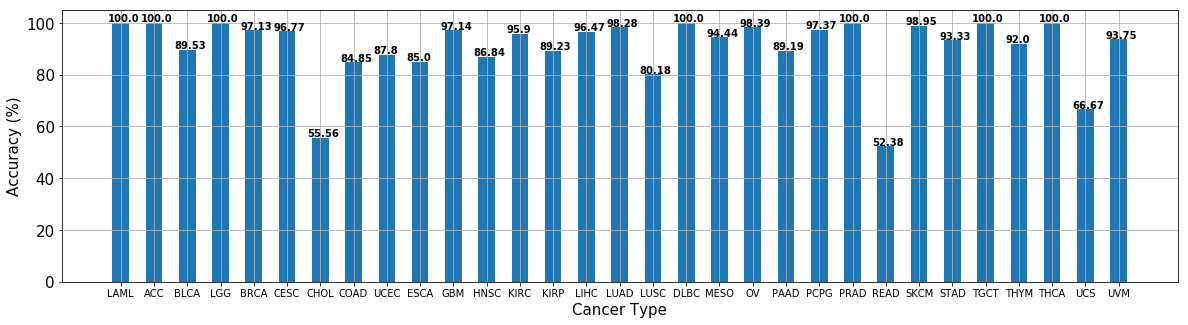

In [30]:
fig, ax = plt.subplots(figsize=(20,5))    
ax.bar(label,list_accuracy,width=0.5)
#plt.xticks(label,fontsize=15)
plt.yticks(fontsize=15)
for i in range(len(list_accuracy)):
    ax.text(i-0.4, float(list_accuracy[i]) + .5, str(round(list_accuracy[i],2)), color='black', fontweight='bold')
plt.grid()
plt.ylabel('Accuracy (%)',fontsize=15)
plt.xlabel('Cancer Type',fontsize=15)
plt.show()

In [74]:
pd.DataFrame(arr_pred_test).to_csv('Desktop/BNN_pred.csv')

In [75]:
pd.DataFrame(y_test).to_csv('Desktop/y_test.csv')

# Confusion Matrix test

In [453]:
list_normalized = []
df_confusion = confusion_matrix(y_test,arr_pred_test)
df_confusion_normalized = ((df_confusion.T/df_confusion.sum(axis=1)).T)  

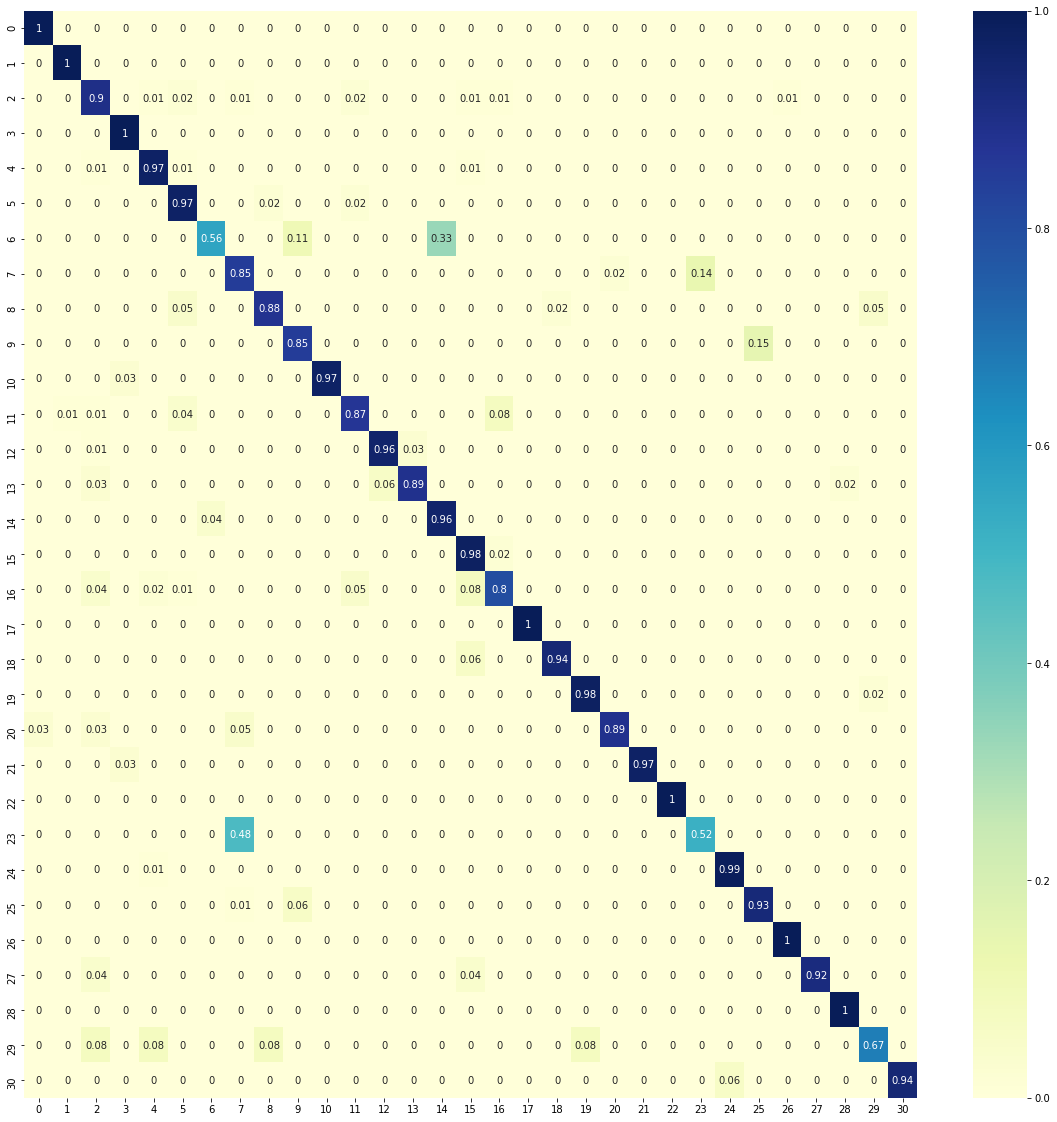

In [454]:
plt.figure(figsize=(20,20))
sns.heatmap(df_confusion_normalized.round(2),annot=True,cmap="YlGnBu")

In [37]:
pd.DataFrame(df_confusion_normalized).to_csv('Desktop/confusion_matrix_new.csv')

In [455]:
df_confusion = pd.read_csv('Desktop/New Folder/confusion_matrix_new.csv')

In [456]:
df_confusion_1 = df_confusion.drop('Unnamed: 0',axis=1)

In [457]:
df_confusion_1.columns = label

In [458]:
df_confusion_1.index = label

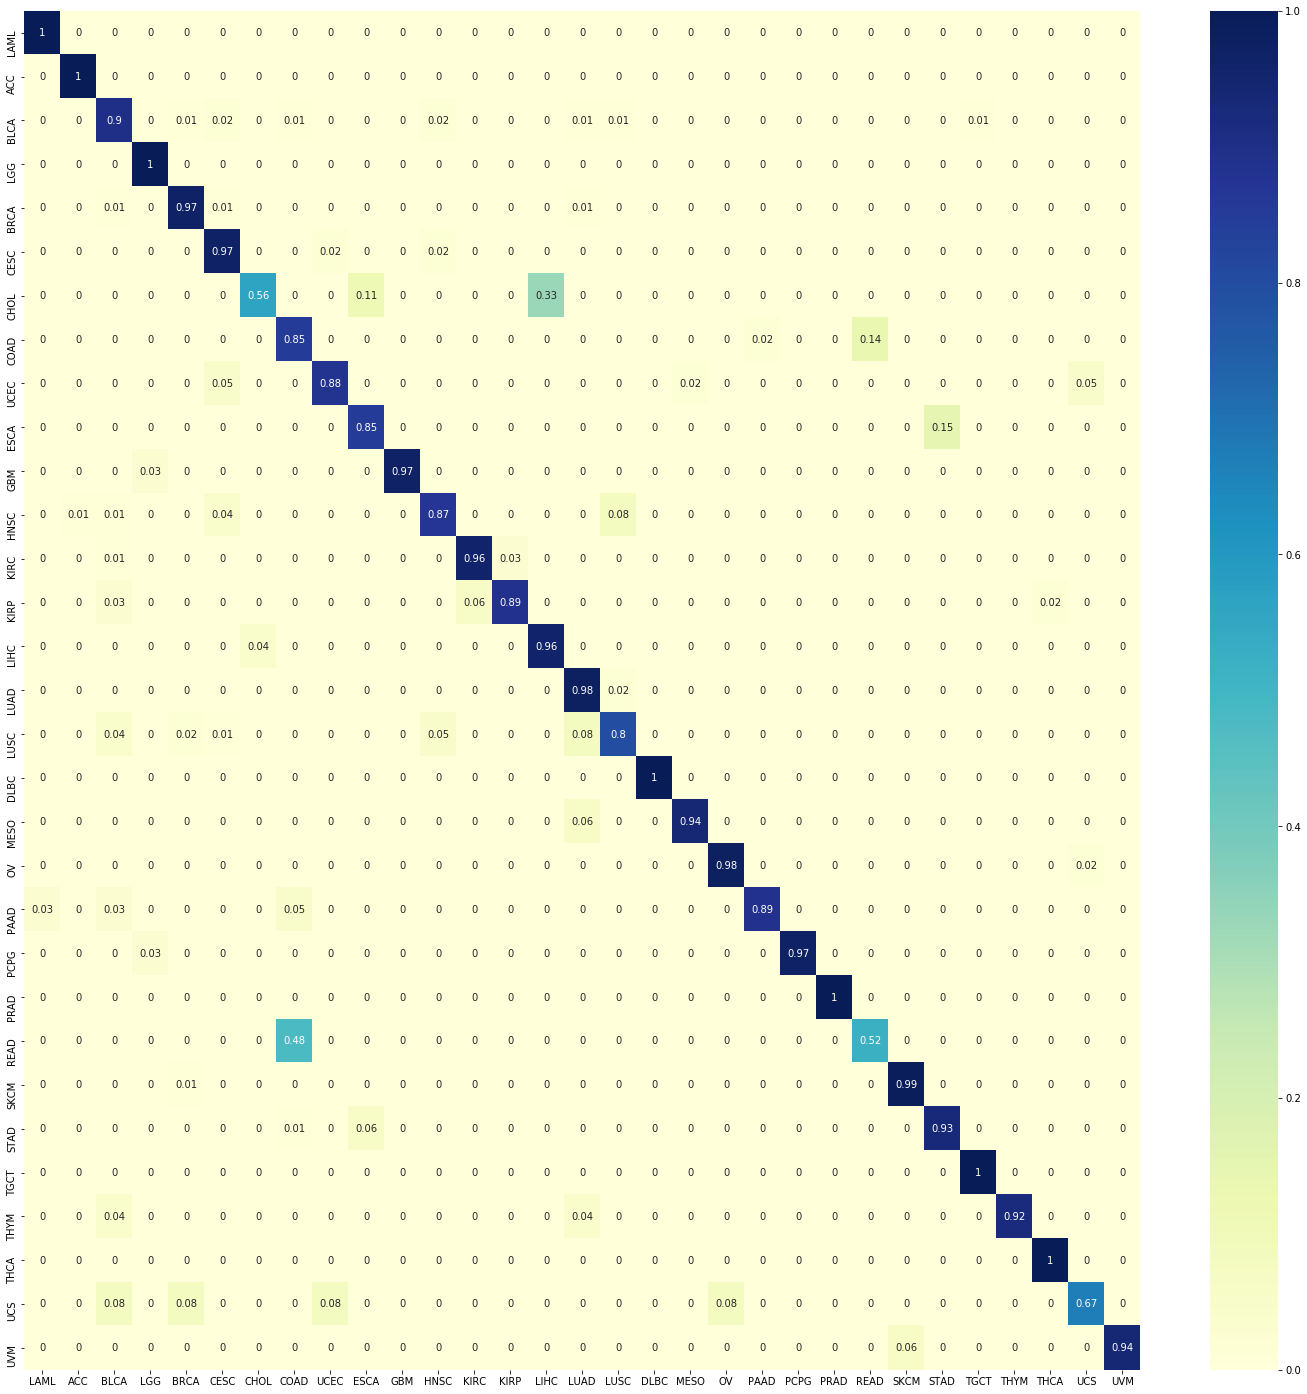

In [460]:
fig = plt.figure(figsize=(25,25))
sns.heatmap(df_confusion_1.round(2),annot=True,cmap="YlGnBu")
fig.savefig('Desktop/paper_figures/'+str('confusion_matrix')+'.pdf', format='pdf', dpi=1200,bbox_inches='tight')

# Individual Accuracies train

In [38]:
list_y_train = list(y_train)
list_num_train_samples = []
for i in range(31):
    c = 0
    for j in range(len(list_y_train)):
        if list_y_train[j] == i:
            c = c+1
    list_num_train_samples.append(c)

In [39]:
temp_prev = 0
list_accuracy = []
for i in range(31):
    temp = list_num_train_samples[i]
    sliced_y_pred = arr_pred_train[temp_prev:temp_prev+temp]
    sliced_y_train = y_train[temp_prev:temp_prev+temp]
    temp_prev = temp_prev+temp
    accuracy = (np.sum(sliced_y_pred == sliced_y_train) / len(sliced_y_train))*100
    list_accuracy.append(accuracy)

In [40]:
list_accuracy

[100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 97.22222222222221,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 98.80952380952381,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0]

# Gene Wise Accuracy

In [461]:
np.random.seed(0)
r = np.random.randint(500)

In [17]:
train_accuracy_list = []
test_accuracy_list = []
logits_list = []
arr_pred_test_list = []
y_test_list = []
y_train_list = []
for i in range(len(df_pca2.columns)-1):
    df  = df_pca2.iloc[:,i:i+1]
    df['label'] = list(df_pca2.iloc[:,-1])
    X_train, X_test, y_train, y_test = split_train_test(df,r)#train_test_split(df.iloc[:,:-1],df.iloc[:,-1], test_size=0.20, random_state=42)
    Ytrain = np.array(y_train).reshape(len(y_train),)
    X_train = np.array(X_train.T.reset_index(drop=True))
    Y_train = tf.Session().run(tf.one_hot(Ytrain,len(set(Ytrain)),axis=1)).reshape(len(Ytrain),len(set(Ytrain))).T
    Ytest = np.array(y_test).reshape(len(y_test),)
    X_test = np.array(X_test.T.reset_index(drop=True))
    Y_test = tf.Session().run(tf.one_hot(Ytest,len(set(Ytest)),axis=1)).reshape(len(Ytest),len(set(Ytest))).T
    layers_dims = [X_train.shape[0],250,95,31]
    [train_accuracy,test_accuracy,logits,logits_train,arr_pred_test,arr_pred_train] = model(X_train=X_train,Y_train=Y_train,X_test =X_test,Y_test = Y_test, learning_rate=0.0005,num_epochs=3500,print_cost=False,layers_dims = layers_dims)
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    logits_list.append(logits)
    arr_pred_test_list.append(arr_pred_test)
    y_test_list.append(Ytest)
    y_train_list.append(Ytrain)
    print(i)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Train Accuracy: 0.22357169413805925
Test Accuracy: 0.2222222222222222
0
Train Accuracy: 0.20337092576527452
Test Accuracy: 0.19321533923303835
1
Train Accuracy: 0.22394348742099393
Test Accuracy: 0.22517207472959685
2
Train Accuracy: 0.17970008675176602
Test Accuracy: 0.18682399213372664
3
Train Accuracy: 0.22530672945842112
Test Accuracy: 0.22566371681415928
4
Train Accuracy: 0.1976700954269426
Test Accuracy: 0.2030481809242871
5
Train Accuracy: 0.22084521006320484
Test Accuracy: 0.2222222222222222
6
Train Accuracy: 0.17647787829966538
Test Accuracy: 0.17305801376597837
7
Train Accuracy: 0.194447886974842
Test Accuracy: 0.18190757128810225
8
Train Accuracy: 0.23026397323088363
Test Accuracy: 0.23402163225172073
9
Train Accuracy: 0.19965299293592761
Test Accuracy: 0.20353982300884957
10
Train Accu

In [462]:
train_accuracy_list = []
test_accuracy_list = []
logits_list = []
arr_pred_test_list = []
y_test_list = []
y_train_list = []
for i in range(len(df_pca2.columns)-1):
    df  = df_pca2.iloc[:,i:i+1]
    df['label'] = list(df_pca2.iloc[:,-1])
    X_train, X_test, y_train, y_test = split_train_test(df,r)#train_test_split(df.iloc[:,:-1],df.iloc[:,-1], test_size=0.20, random_state=42)
    #Ytrain = np.array(y_train).reshape(len(y_train),)
    #X_train = np.array(X_train.T.reset_index(drop=True))
    #Y_train = tf.Session().run(tf.one_hot(Ytrain,len(set(Ytrain)),axis=1)).reshape(len(Ytrain),len(set(Ytrain))).T
    #Ytest = np.array(y_test).reshape(len(y_test),)
    #X_test = np.array(X_test.T.reset_index(drop=True))
    #Y_test = tf.Session().run(tf.one_hot(Ytest,len(set(Ytest)),axis=1)).reshape(len(Ytest),len(set(Ytest))).T
    #layers_dims = [X_train.shape[0],250,95,31]
    #[train_accuracy,test_accuracy,logits,logits_train,arr_pred_test,arr_pred_train] = model(X_train=X_train,Y_train=Y_train,X_test =X_test,Y_test = Y_test, learning_rate=0.0005,num_epochs=3500,print_cost=False,layers_dims = layers_dims)
    clf_log = LogisticRegression().fit(X_train,y_train)
    train_accuracy = clf_log.score(X_train,y_train)
    test_accuracy = clf_log.score(X_test,y_test)
    arr_pred_test = clf_log.predict(X_test)
    logits = clf_log.predict_proba(X_test)
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    logits_list.append(logits)
    arr_pred_test_list.append(arr_pred_test)
    y_test_list.append(y_test)
    y_train_list.append(y_train)
    print(i)
    print(train_accuracy)
    print(test_accuracy)

0
0.19754616433263106
0.19862340216322516
1
0.18998636757962573
0.18534906588003933
2
0.1994051307473045
0.19960668633235004
3
0.17052918577271037
0.17158308751229107
4
0.1986615441814351
0.18928220255653885
5
0.18688809022183667
0.18682399213372664
6
0.18787953897632917
0.1848574237954769
7
0.17090097905564505
0.17010816125860373
8
0.16730697732060973
0.16666666666666666
9
0.2070888585946214
0.21140609636184857
10
0.18986243648531417
0.18977384464110128
11
0.12888833808402528
0.12536873156342182
12
0.13037551121576405
0.12831858407079647
13
0.1304994423100756
0.12340216322517207
14
0.13570454827116124
0.1302851524090462
15
0.14140537860949312
0.13864306784660768
16
0.13124302887594497
0.12733529990167158
17
0.12764902714090964
0.12192723697148476
18
0.13458916842235716
0.13176007866273354
19
0.13620027264840748
0.13176007866273354
20
0.14561903581608626
0.14060963618485742
21
0.1328541331019953
0.12586037364798427
22
0.13334985747924155
0.13225172074729596
23
0.13967034328913125
0.145

In [463]:
from sklearn.metrics import precision_recall_fscore_support

In [464]:
dict_report = {}
for i in range(len(y_test_list)):
    matrix_temp = confusion_matrix(y_test_list[i], arr_pred_test_list[i])
    accuracy_temp = matrix_temp.diagonal()/matrix_temp.sum(axis=1)
    indices = list(np.where(accuracy_temp >= 0.75)[0])
    if len(indices) > 0:
        accuracy = accuracy_temp[indices]
        precision = precision_recall_fscore_support(y_test_list[i],arr_pred_test_list[i])[0][indices]
        recall = precision_recall_fscore_support(y_test_list[i],arr_pred_test_list[i])[1][indices]
        fscore = precision_recall_fscore_support(y_test_list[i],arr_pred_test_list[i])[2][indices]
        dict_report[i] = [indices,accuracy,precision,recall,fscore]

C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

In [166]:
#dict_report

In [465]:
dict_report_refined = {}
for key in dict_report.keys():
    report_index = dict_report[key][0]
    report_accuracy = dict_report[key][1]
    report_precision = dict_report[key][2]
    report_recall = dict_report[key][3]
    report_score = dict_report[key][4]
    list_index = []
    list_accuracy = []
    list_precision = []
    list_recall = []
    list_score = []
    for i in range(len(report_index)):
        if (report_precision[i] >= 0.75):
            list_index.append(report_index[i])
            list_accuracy.append(report_accuracy[i])
            list_precision.append(report_precision[i])
            list_recall.append(report_recall[i])
            list_score.append(report_score[i])
    if (len(list_index)>0):
        dict_report_refined[key] = [list_index,list_accuracy,list_precision,list_recall,list_score]

In [466]:
dict_report_refined

{23: [[0],
  [0.8857142857142857],
  [0.775],
  [0.8857142857142857],
  [0.8266666666666667]],
 52: [[22],
  [0.9818181818181818],
  [0.782608695652174],
  [0.9818181818181818],
  [0.8709677419354839]],
 64: [[0],
  [0.8571428571428571],
  [0.75],
  [0.8571428571428571],
  [0.7999999999999999]],
 65: [[0],
  [0.8571428571428571],
  [0.9090909090909091],
  [0.8571428571428571],
  [0.8823529411764706]],
 68: [[0],
  [0.9714285714285714],
  [0.918918918918919],
  [0.9714285714285714],
  [0.9444444444444445]],
 69: [[0],
  [0.8857142857142857],
  [0.96875],
  [0.8857142857142857],
  [0.9253731343283582]],
 72: [[0],
  [0.9142857142857143],
  [0.9411764705882353],
  [0.9142857142857143],
  [0.9275362318840579]]}

In [467]:
a = list(dict_report_refined.keys())

In [468]:
gene_list = []
for i in range(len(a)):
    gene = df_pca2.columns[a[i]]
    gene_list.append(gene)

In [469]:
gene_list

['MYO1F', 'TARP', 'COL16A1', 'ANTXR1', 'TMEM54', 'PCGF2', 'PARVA']

In [470]:
l_str_label = []
for key in dict_report_refined.keys():
    index = dict_report_refined[key][0][0]
    str_label = label[index]
    l_str_label.append(str_label)

In [471]:
gene_list

['MYO1F', 'TARP', 'COL16A1', 'ANTXR1', 'TMEM54', 'PCGF2', 'PARVA']

In [472]:
l_str_label

['LAML', 'PRAD', 'LAML', 'LAML', 'LAML', 'LAML', 'LAML']

In [473]:
l_str_new = []
for i in range(len(gene_list)):
    str_new = gene_list[i]+'\n'+'('+l_str_label[i]+')'
    l_str_new.append(str_new)

In [474]:
l_str_new

['MYO1F\n(LAML)',
 'TARP\n(PRAD)',
 'COL16A1\n(LAML)',
 'ANTXR1\n(LAML)',
 'TMEM54\n(LAML)',
 'PCGF2\n(LAML)',
 'PARVA\n(LAML)']

In [74]:
dict_report_refined

{23: [[0],
  [0.8857142857142857],
  [0.775],
  [0.8857142857142857],
  [0.8266666666666667]],
 52: [[22],
  [0.9818181818181818],
  [0.782608695652174],
  [0.9818181818181818],
  [0.8709677419354839]],
 64: [[0],
  [0.8571428571428571],
  [0.75],
  [0.8571428571428571],
  [0.7999999999999999]],
 65: [[0],
  [0.8571428571428571],
  [0.9090909090909091],
  [0.8571428571428571],
  [0.8823529411764706]],
 68: [[0],
  [0.9714285714285714],
  [0.918918918918919],
  [0.9714285714285714],
  [0.9444444444444445]],
 69: [[0],
  [0.8857142857142857],
  [0.96875],
  [0.8857142857142857],
  [0.9253731343283582]],
 72: [[0],
  [0.9142857142857143],
  [0.9411764705882353],
  [0.9142857142857143],
  [0.9275362318840579]]}

In [475]:
list_index = []
list_accuracy = []
list_precision = []
list_recall = []
list_fscore = []
for key in dict_report_refined.keys():
    index = dict_report_refined[key][0][0]
    accuracy = dict_report_refined[key][1][0]
    precision = dict_report_refined[key][2][0]
    recall = dict_report_refined[key][3][0]
    fscore = dict_report_refined[key][4][0]
    list_index.append(index)
    list_accuracy.append(accuracy)
    list_precision.append(precision)
    list_recall.append(recall)
    list_fscore.append(fscore)

In [476]:
list_index

[0, 22, 0, 0, 0, 0, 0]

In [477]:
df_pca2.columns

Index(['ATP6V1G2', 'TRIM31', 'DNAJC18', 'ZDHHC12', 'ABI2', 'MAGI2', 'NAP1L3',
       'TECTA', 'MUC13', 'ATP1B2',
       ...
       'PAX8', 'HAUS1', 'PLCH2', 'SLC4A2', 'CABLES1', 'PIGT', 'PRSS3', 'VIPR1',
       'CBFA2T3', 'label'],
      dtype='object', length=104)

In [478]:
list_recall

[0.8857142857142857,
 0.9818181818181818,
 0.8571428571428571,
 0.8571428571428571,
 0.9714285714285714,
 0.8857142857142857,
 0.9142857142857143]

C:\Users\Prasoon\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


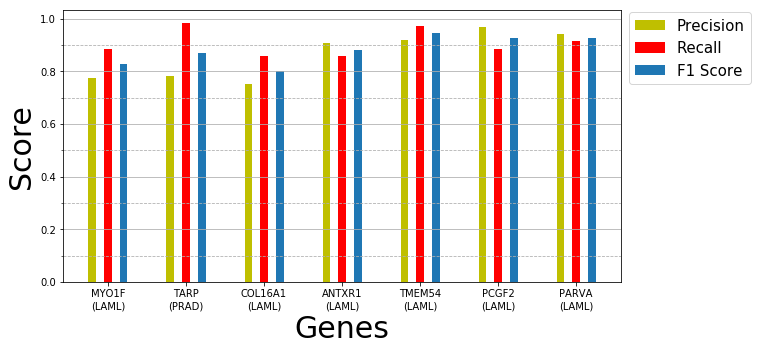

In [479]:
fig = plt.figure(figsize=(10,5))
plt.bar(np.arange(0,len(list_precision))-0.2,list_precision,width=0.1,label = 'Precision',color='y')
plt.bar(np.arange(0,len(list_recall)),list_recall,width=0.1,label='Recall',color='r')
#plt.plot(['1','2','3','4','5','6','7','8'],list_recall)
plt.bar(np.arange(0,len(list_fscore))+0.2,list_fscore,width=0.1,label = 'F1 Score')
plt.ylabel('Score',fontsize=30)
plt.xlabel('Genes',fontsize=30)
plt.xticks(np.arange(0,len(l_str_new)),l_str_new)

plt.legend(bbox_to_anchor=(1, 1.02),fontsize=15)
#plt.grid()
ax = plt.axes()
ax.set_yticks([0.1,0.3,0.5,0.7,0.9], minor=True)
ax.yaxis.grid(True,which='major')
ax.yaxis.grid(True,which='minor',linestyle='--')
plt.show()
fig.savefig('Desktop/paper_figures/'+str('gene_wise_accuracy')+'.pdf', format='pdf', dpi=1200,bbox_inches='tight')
#ax.xaxis.grid(True, which='minor')
#ax.set_facecolor('whitesmoke')

In [480]:
df_precision = pd.DataFrame(data = 0, index = list(df_pca2.columns[:-1]),columns = np.arange(0,len(set(y_test_list[0]))))
df_recall = pd.DataFrame(data = 0, index = list(df_pca2.columns[:-1]),columns = np.arange(0,len(set(y_test_list[0]))))
df_fscore = pd.DataFrame(data = 0, index = list(df_pca2.columns[:-1]),columns = np.arange(0,len(set(y_test_list[0]))))
for i in range(len(arr_pred_test_list)):
    precision = precision_recall_fscore_support(y_test_list[i],arr_pred_test_list[i])[0]
    recall = precision_recall_fscore_support(y_test_list[i],arr_pred_test_list[i])[1]
    fscore = precision_recall_fscore_support(y_test_list[i],arr_pred_test_list[i])[2]
    df_precision.iloc[i,:] = list(precision)
    df_recall.iloc[i,:] = list(recall)
    df_fscore.iloc[i,:] = list(fscore)
df_precision.index = genes
df_recall.index = genes
df_fscore.index = genes
df_precision.columns = label
df_recall.columns = label
df_fscore.columns = label

C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

NameError: name 'genes' is not defined

In [65]:
df_precision.to_csv('D:/New Folder/precision.csv')
df_recall.to_csv('D:/New Folder/recall.csv')
df_fscore.to_csv('D:/New Folder/fscore.csv')

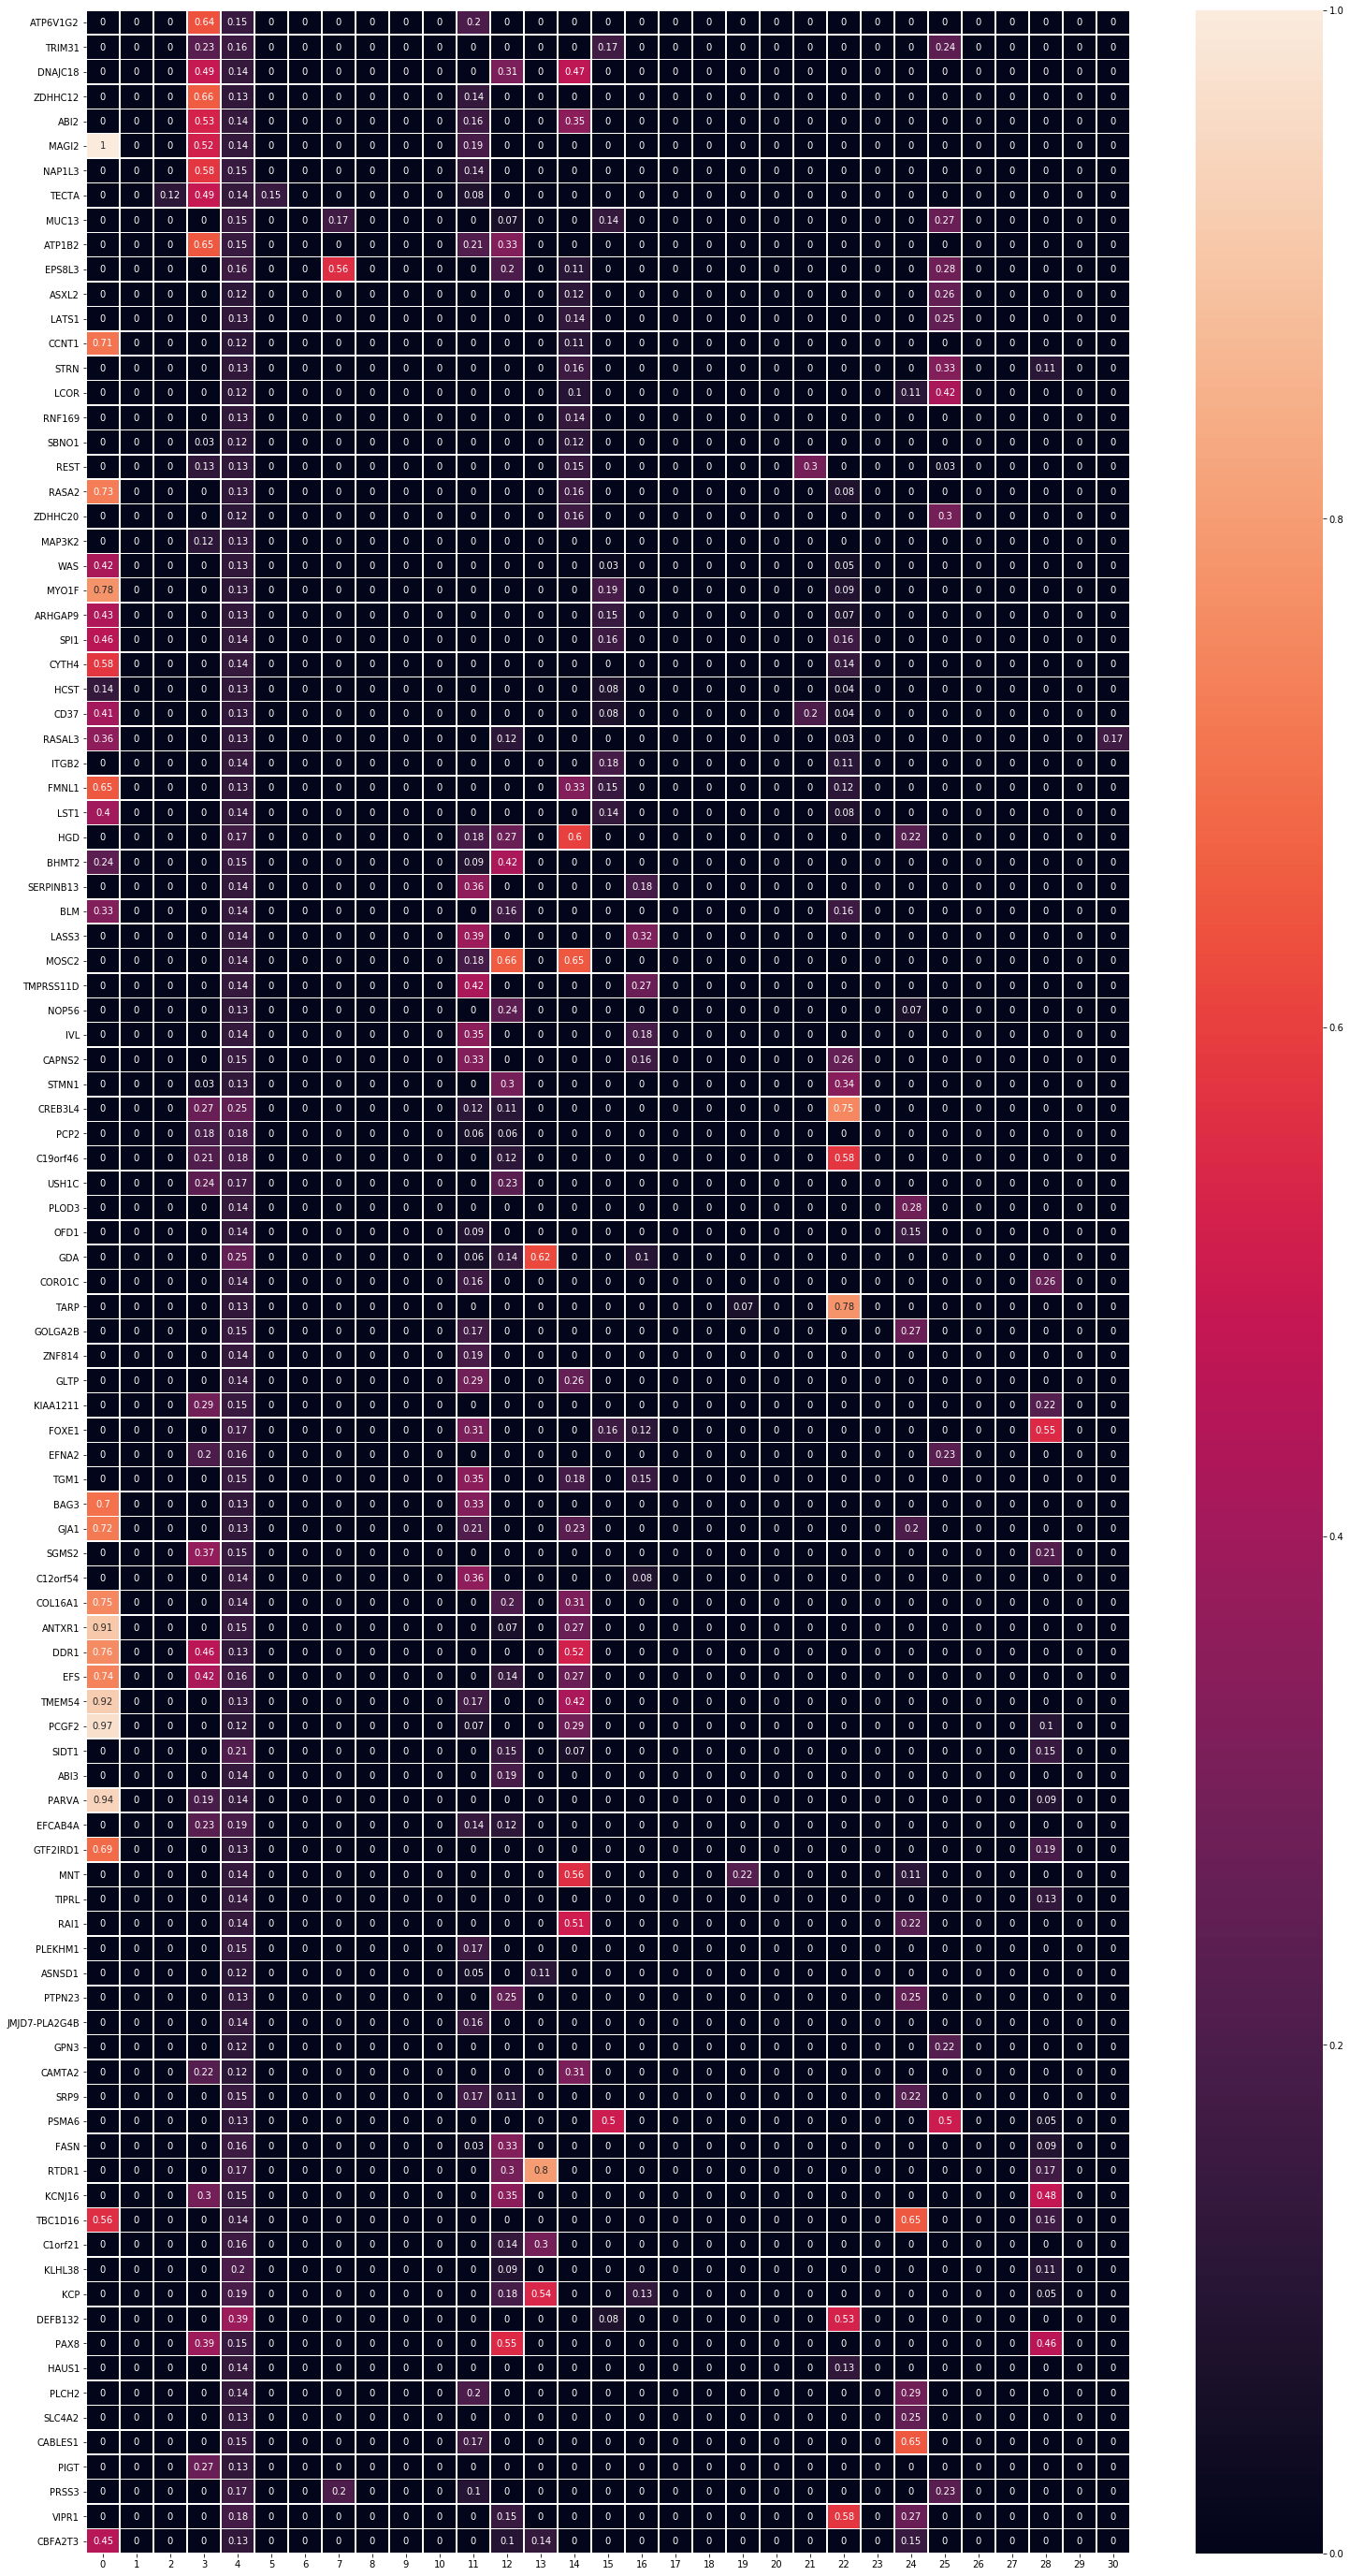

In [481]:
fig = plt.figure(figsize=(25,50))
sns.heatmap(df_precision.astype('float32').round(2),linewidths=.5,annot=True)
fig.savefig('Desktop/paper_figures/'+str('precision')+'.pdf', format='pdf', dpi=600,bbox_inches='tight')
plt.show()

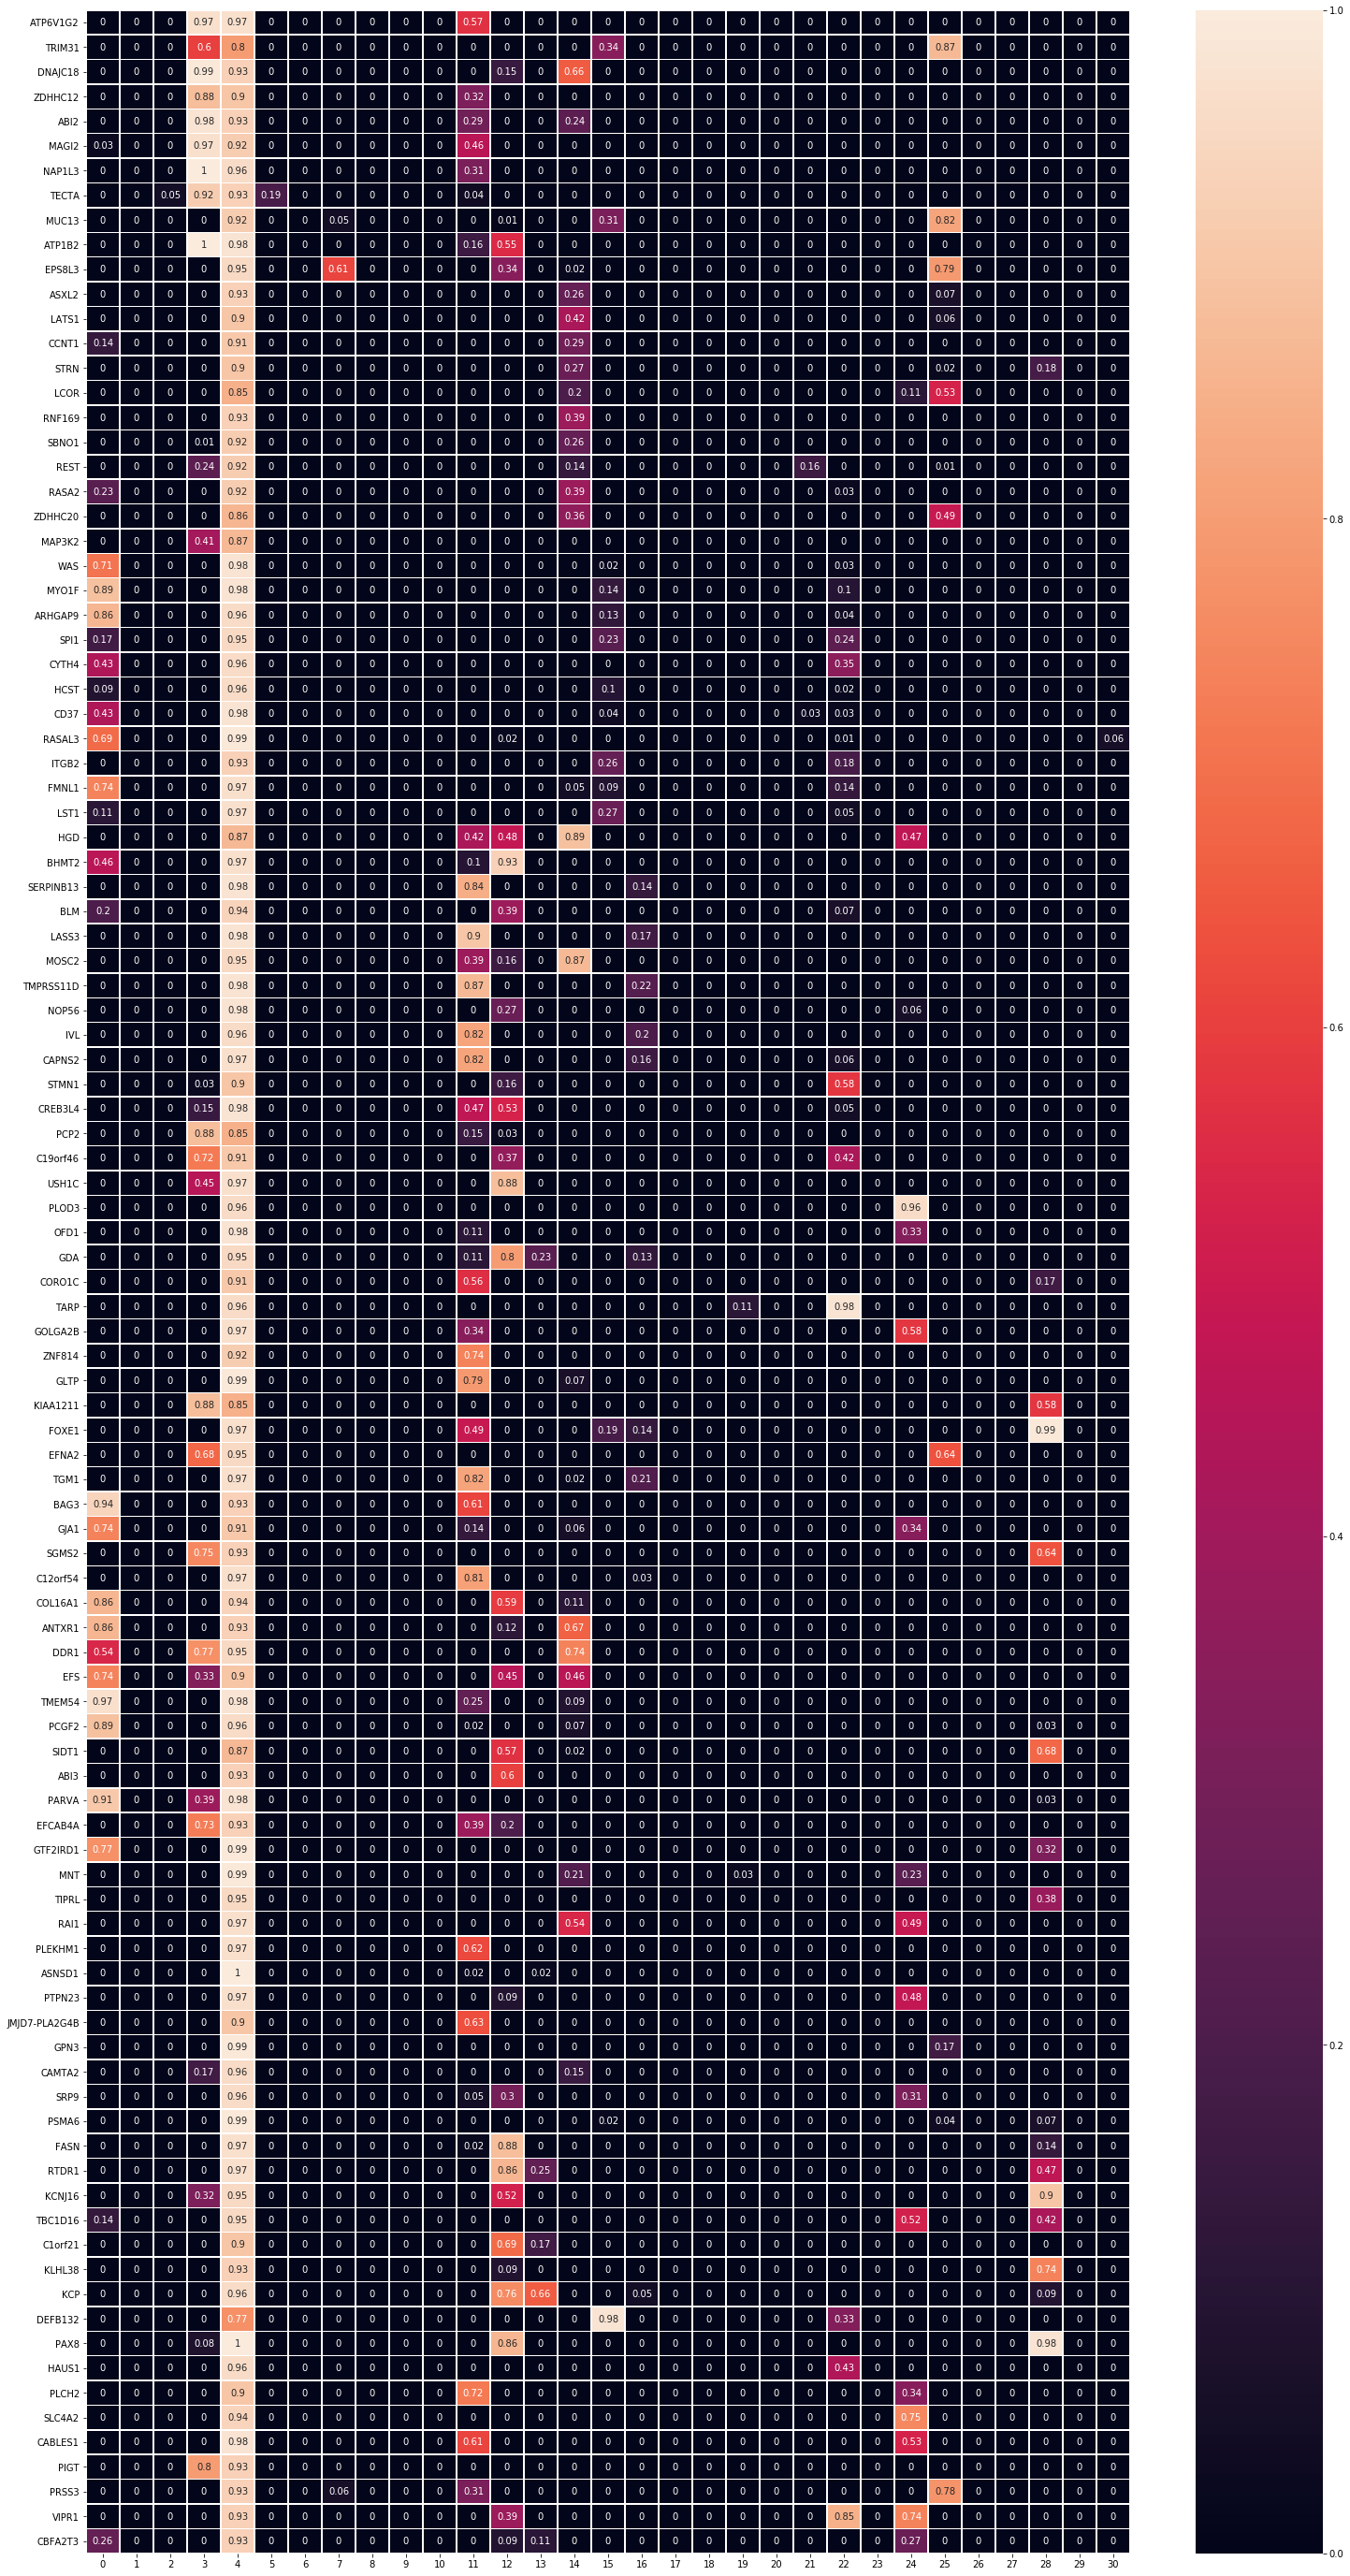

In [482]:
fig = plt.figure(figsize=(25,50))
sns.heatmap(df_recall.astype('float32').round(2),linewidths=.5,annot=True)
fig.savefig('Desktop/paper_figures/'+str('recall')+'.pdf', format='pdf', dpi=600,bbox_inches='tight')
plt.show()

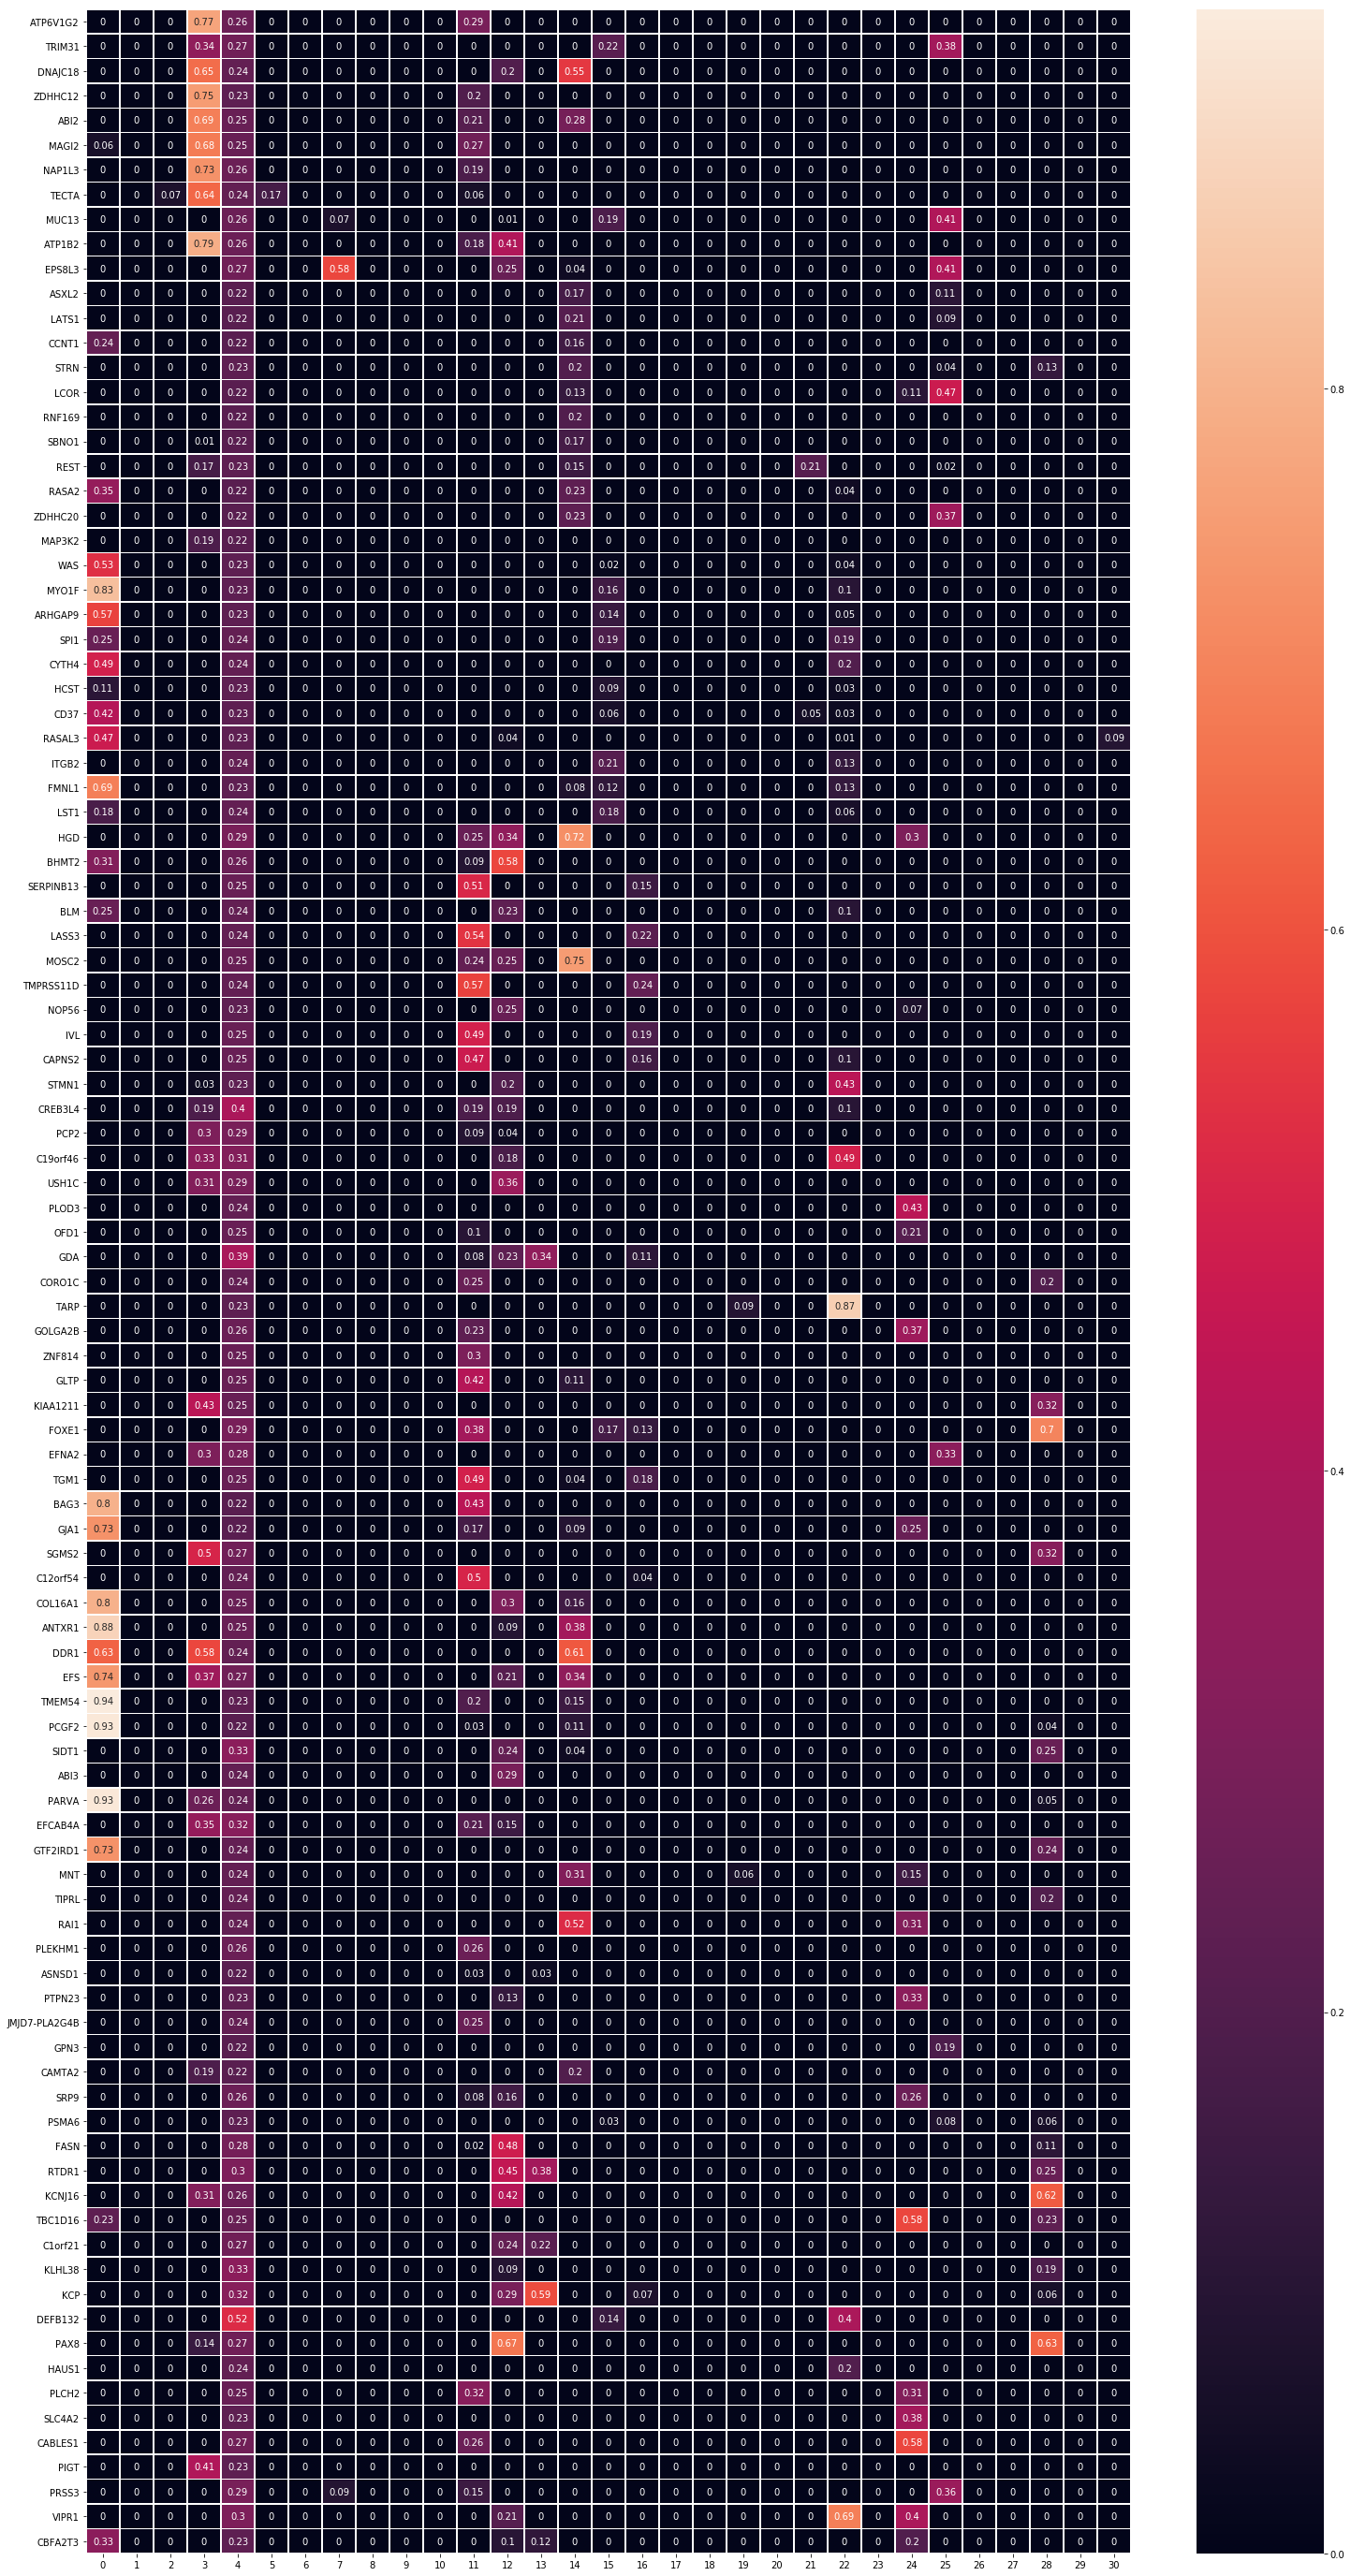

In [483]:
fig = plt.figure(figsize=(25,50))
sns.heatmap(df_fscore.astype('float32').round(2),linewidths=.5,annot=True)
fig.savefig('Desktop/paper_figures/'+str('fscore')+'.pdf', format='pdf', dpi=600,bbox_inches='tight')
plt.show()

In [44]:
genes = list(df_pca2.columns[:-1])

In [51]:
df = pd.DataFrame(data = 0, index = list(df_pca2.columns[:-1]),columns = np.arange(0,len(set(y_test_list[0]))))
for i in range(len(arr_pred_test_list)):
    list_correct_j = []
    for j in range(len(set(y_test_list[0]))):
        correct_j = 0
        j_true = 0
        for k in range(len(arr_pred_test_list[0])):
            if (y_test_list[i][k] == j):
                j_true = j_true + 1
            if ((arr_pred_test_list[i][k] == j) and (y_test_list[i][k] == j)):
                correct_j = correct_j + 1
        list_correct_j.append(correct_j/j_true)
    df.iloc[i,:] = list_correct_j

In [1]:
import pandas as pd

In [373]:
label

['LAML',
 'ACC',
 'BLCA',
 'LGG',
 'BRCA',
 'CESC',
 'CHOL',
 'COAD',
 'UCEC',
 'ESCA',
 'GBM',
 'HNSC',
 'KIRC',
 'KIRP',
 'LIHC',
 'LUAD',
 'LUSC',
 'DLBC',
 'MESO',
 'OV',
 'PAAD',
 'PCPG',
 'PRAD',
 'READ',
 'SKCM',
 'STAD',
 'TGCT',
 'THYM',
 'THCA',
 'UCS',
 'UVM']

In [52]:
df.to_csv('Desktop/gene_prediction_new.csv',index=False)

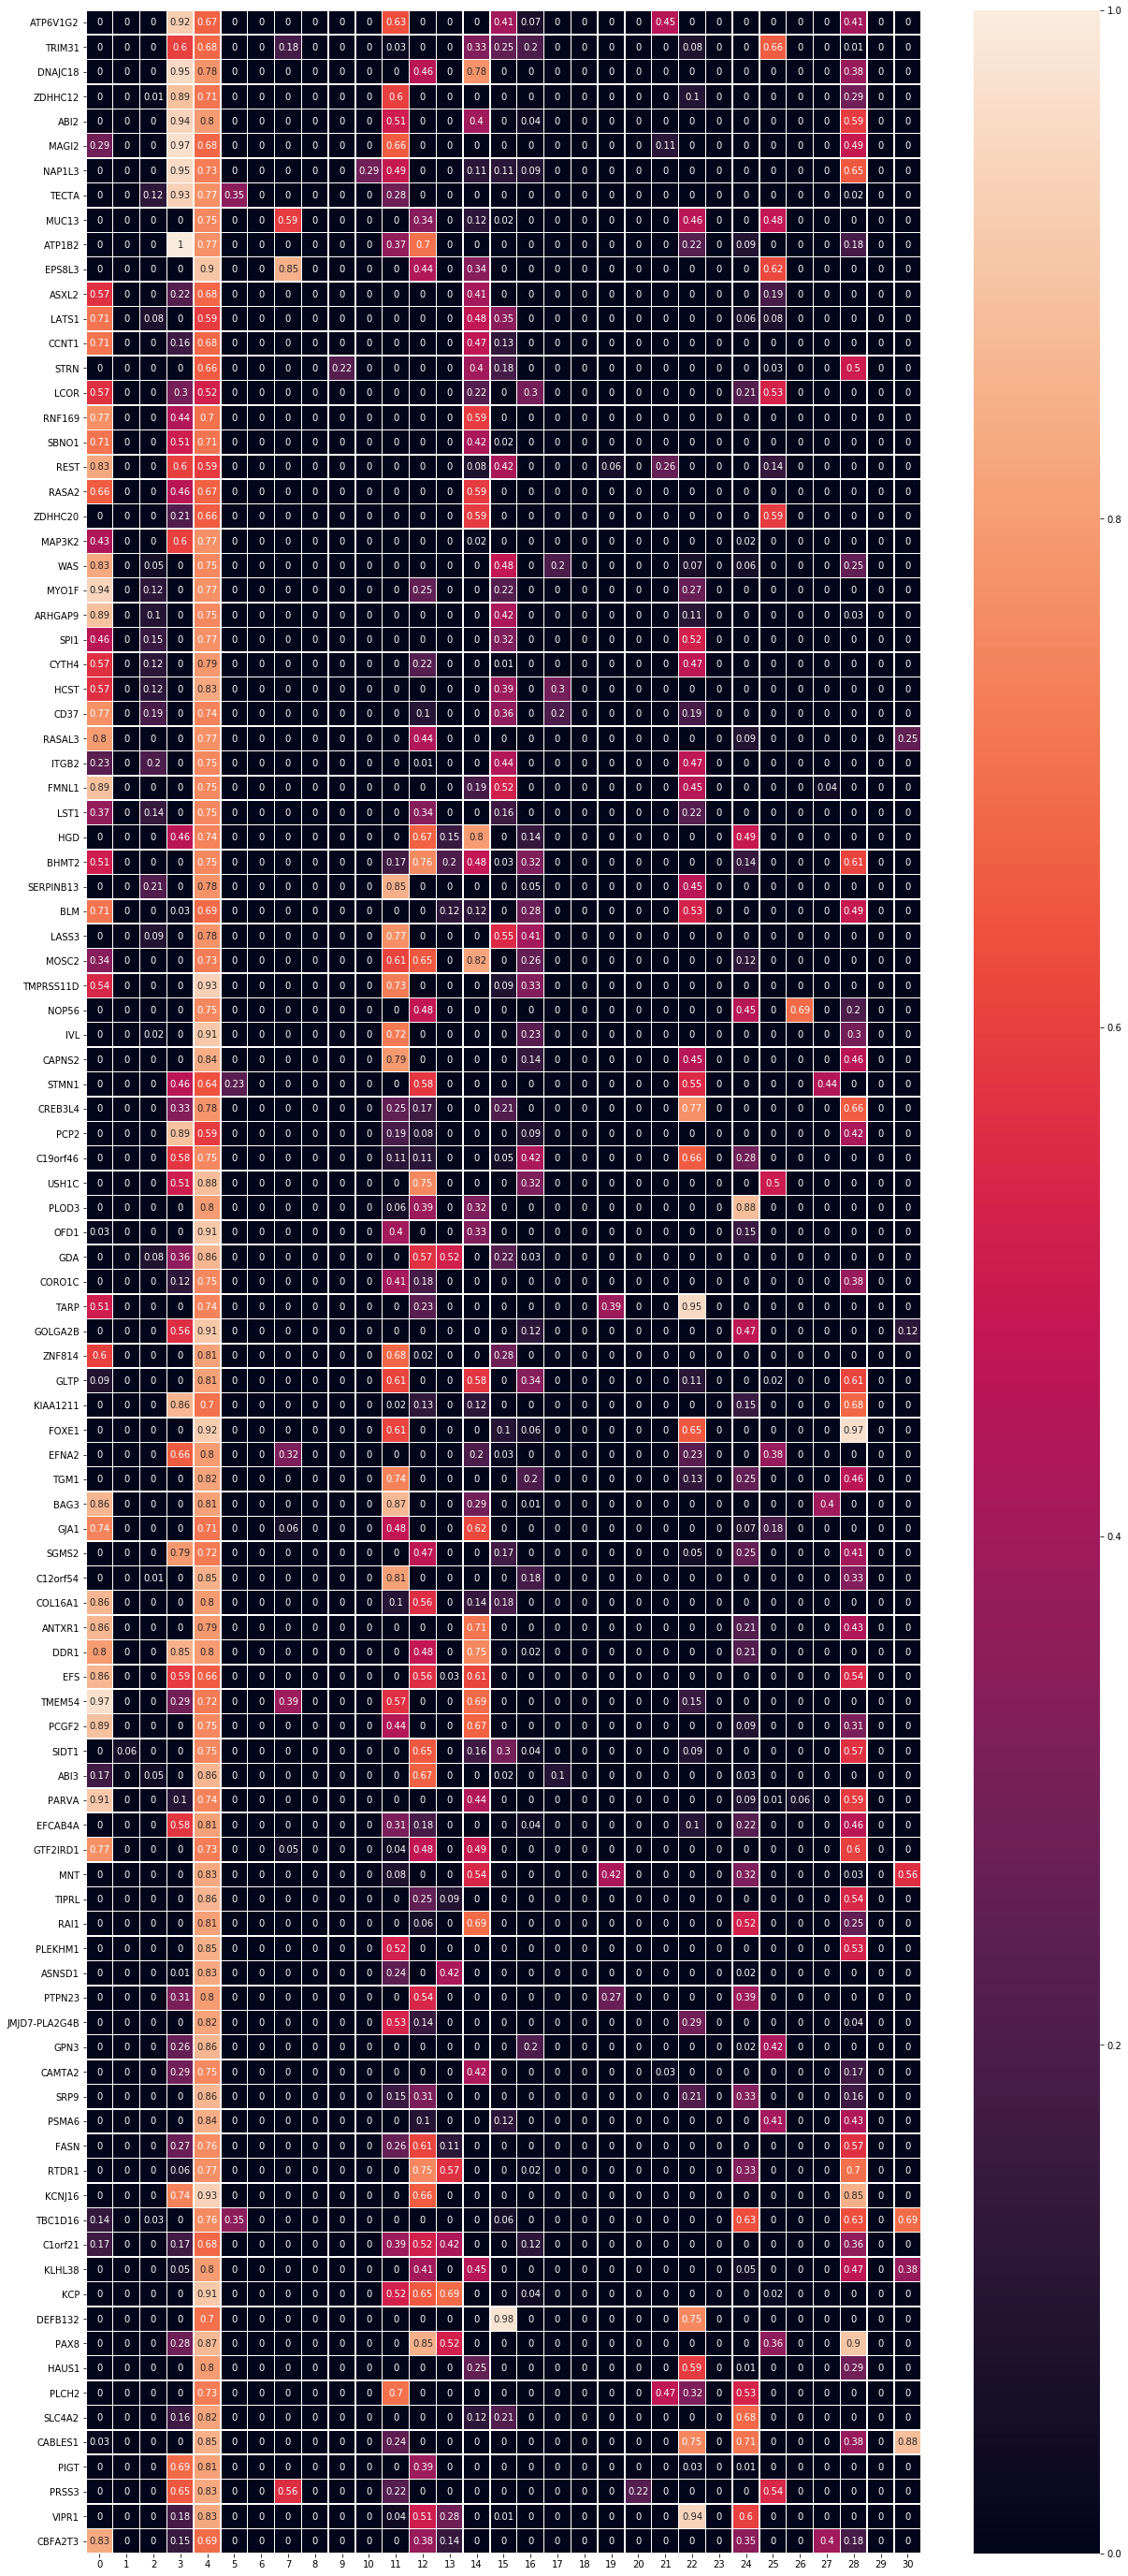

In [53]:
plt.figure(figsize=(20,50))
sns.heatmap(df.astype('float32').round(2),linewidths=.5,annot=True)

In [8]:
df_gene_wise = pd.read_csv('Desktop/New Folder/gene_prediction_new.csv')

In [11]:
df_gene_wise.index = genes

In [12]:
df_gene_wise.columns = label

In [17]:
list(df_gene_wise.iloc[0])

[0.0,
 0.0,
 0.0,
 0.9150943396226416,
 0.6680327868852459,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.631578947368421,
 0.0,
 0.0,
 0.0,
 0.4137931034482759,
 0.07207207207207207,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4473684210526316,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.40869565217391307,
 0.0,
 0.0]

In [28]:
l = []
for i in range(len(df_gene_wise)):
    if (max(list(df_gene_wise.iloc[0]))>=0.8):
        l.append(df_gene_wise.index[i])

In [31]:
df_gene_wise

LAML  ACC      BLCA       LGG      BRCA  CESC  CHOL      COAD  \
ATP6V1G2  0.000000  0.0  0.000000  0.915094  0.668033   0.0   0.0  0.000000   
TRIM31    0.000000  0.0  0.000000  0.603774  0.680328   0.0   0.0  0.181818   
DNAJC18   0.000000  0.0  0.000000  0.952830  0.782787   0.0   0.0  0.000000   
ZDHHC12   0.000000  0.0  0.011628  0.886792  0.709016   0.0   0.0  0.000000   
ABI2      0.000000  0.0  0.000000  0.943396  0.799180   0.0   0.0  0.000000   
...            ...  ...       ...       ...       ...   ...   ...       ...   
CABLES1   0.028571  0.0  0.000000  0.000000  0.852459   0.0   0.0  0.000000   
PIGT      0.000000  0.0  0.000000  0.688679  0.807377   0.0   0.0  0.000000   
PRSS3     0.000000  0.0  0.000000  0.650943  0.827869   0.0   0.0  0.560606   
VIPR1     0.000000  0.0  0.000000  0.179245  0.831967   0.0   0.0  0.000000   
CBFA2T3   0.828571  0.0  0.000000  0.150943  0.692623   0.0   0.0  0.000000   

          UCEC  ESCA  ...      PCPG      PRAD  READ      SKCM      STAD  TGCT  \
ATP6V1G2   0.0   0.0  ...  0.447368  0.000000   0.0  0.000000  0.000000   0.0   
TRIM31     0.0   0.0  ...  0.000000  0.081818   0.0  0.000000  0.655556   0.0   
DNAJC18    0.0   0.0  ...  0.000000  0.000000   0.0  0.000000  0.000000   0.0   
ZDHHC12    0.0   0.0  ...  0.000000  0.100000   0.0  0.000000  0.000000   0.0   
ABI2       0.0   0.0  ...  0.000000  0.000000   0.0  0.000000  0.000000   0.0   
...        ...   ...  ...       ...       ...   ...       ...       ...   ...   
CABLES1    0.0   0.0  ...  0.000000  0.745455   0.0  0.705263  0.000000   0.0   
PIGT       0.0   0.0  ...  0.000000  0.027273   0.0  0.010526  0.000000   0.0   
PRSS3      0.0   0.0  ...  0.000000  0.000000   0.0  0.000000  0.544444   0.0   
VIPR1      0.0   0.0  ...  0.000000  0.936364   0.0  0.600000  0.000000   0.0   
CBFA2T3    0.0   0.0  ...  0.000000  0.000000   0.0  0.347368  0.000000   0.0   

          THYM      THCA  UCS    UVM  
ATP6V1G2   0.0  0.408696  0.0  0.000  
TRIM31     0.0  0.008696  0.0  0.000  
DNAJC18    0.0  0.382609  0.0  0.000  
ZDHHC12    0.0  0.286957  0.0  0.000  
ABI2       0.0  0.591304  0.0  0.000  
...        ...       ...  ...    ...  
CABLES1    0.0  0.382609  0.0  0.875  
PIGT       0.0  0.000000  0.0  0.000  
PRSS3      0.0  0.000000  0.0  0.000  
VIPR1      0.0  0.000000  0.0  0.000  
CBFA2T3    0.4  0.182609  0.0  0.000  

[103 rows x 31 columns]

In [22]:
L = ['LAML','LGG','BRCA','COAD','HNSC','KIRC','LIHC','LUAD','PRAD','SKCM','THCA','UVM']

In [25]:
df_temp = df_gene_wise[L]

In [27]:
df_temp.to_csv('D:/New Folder/temp.csv')

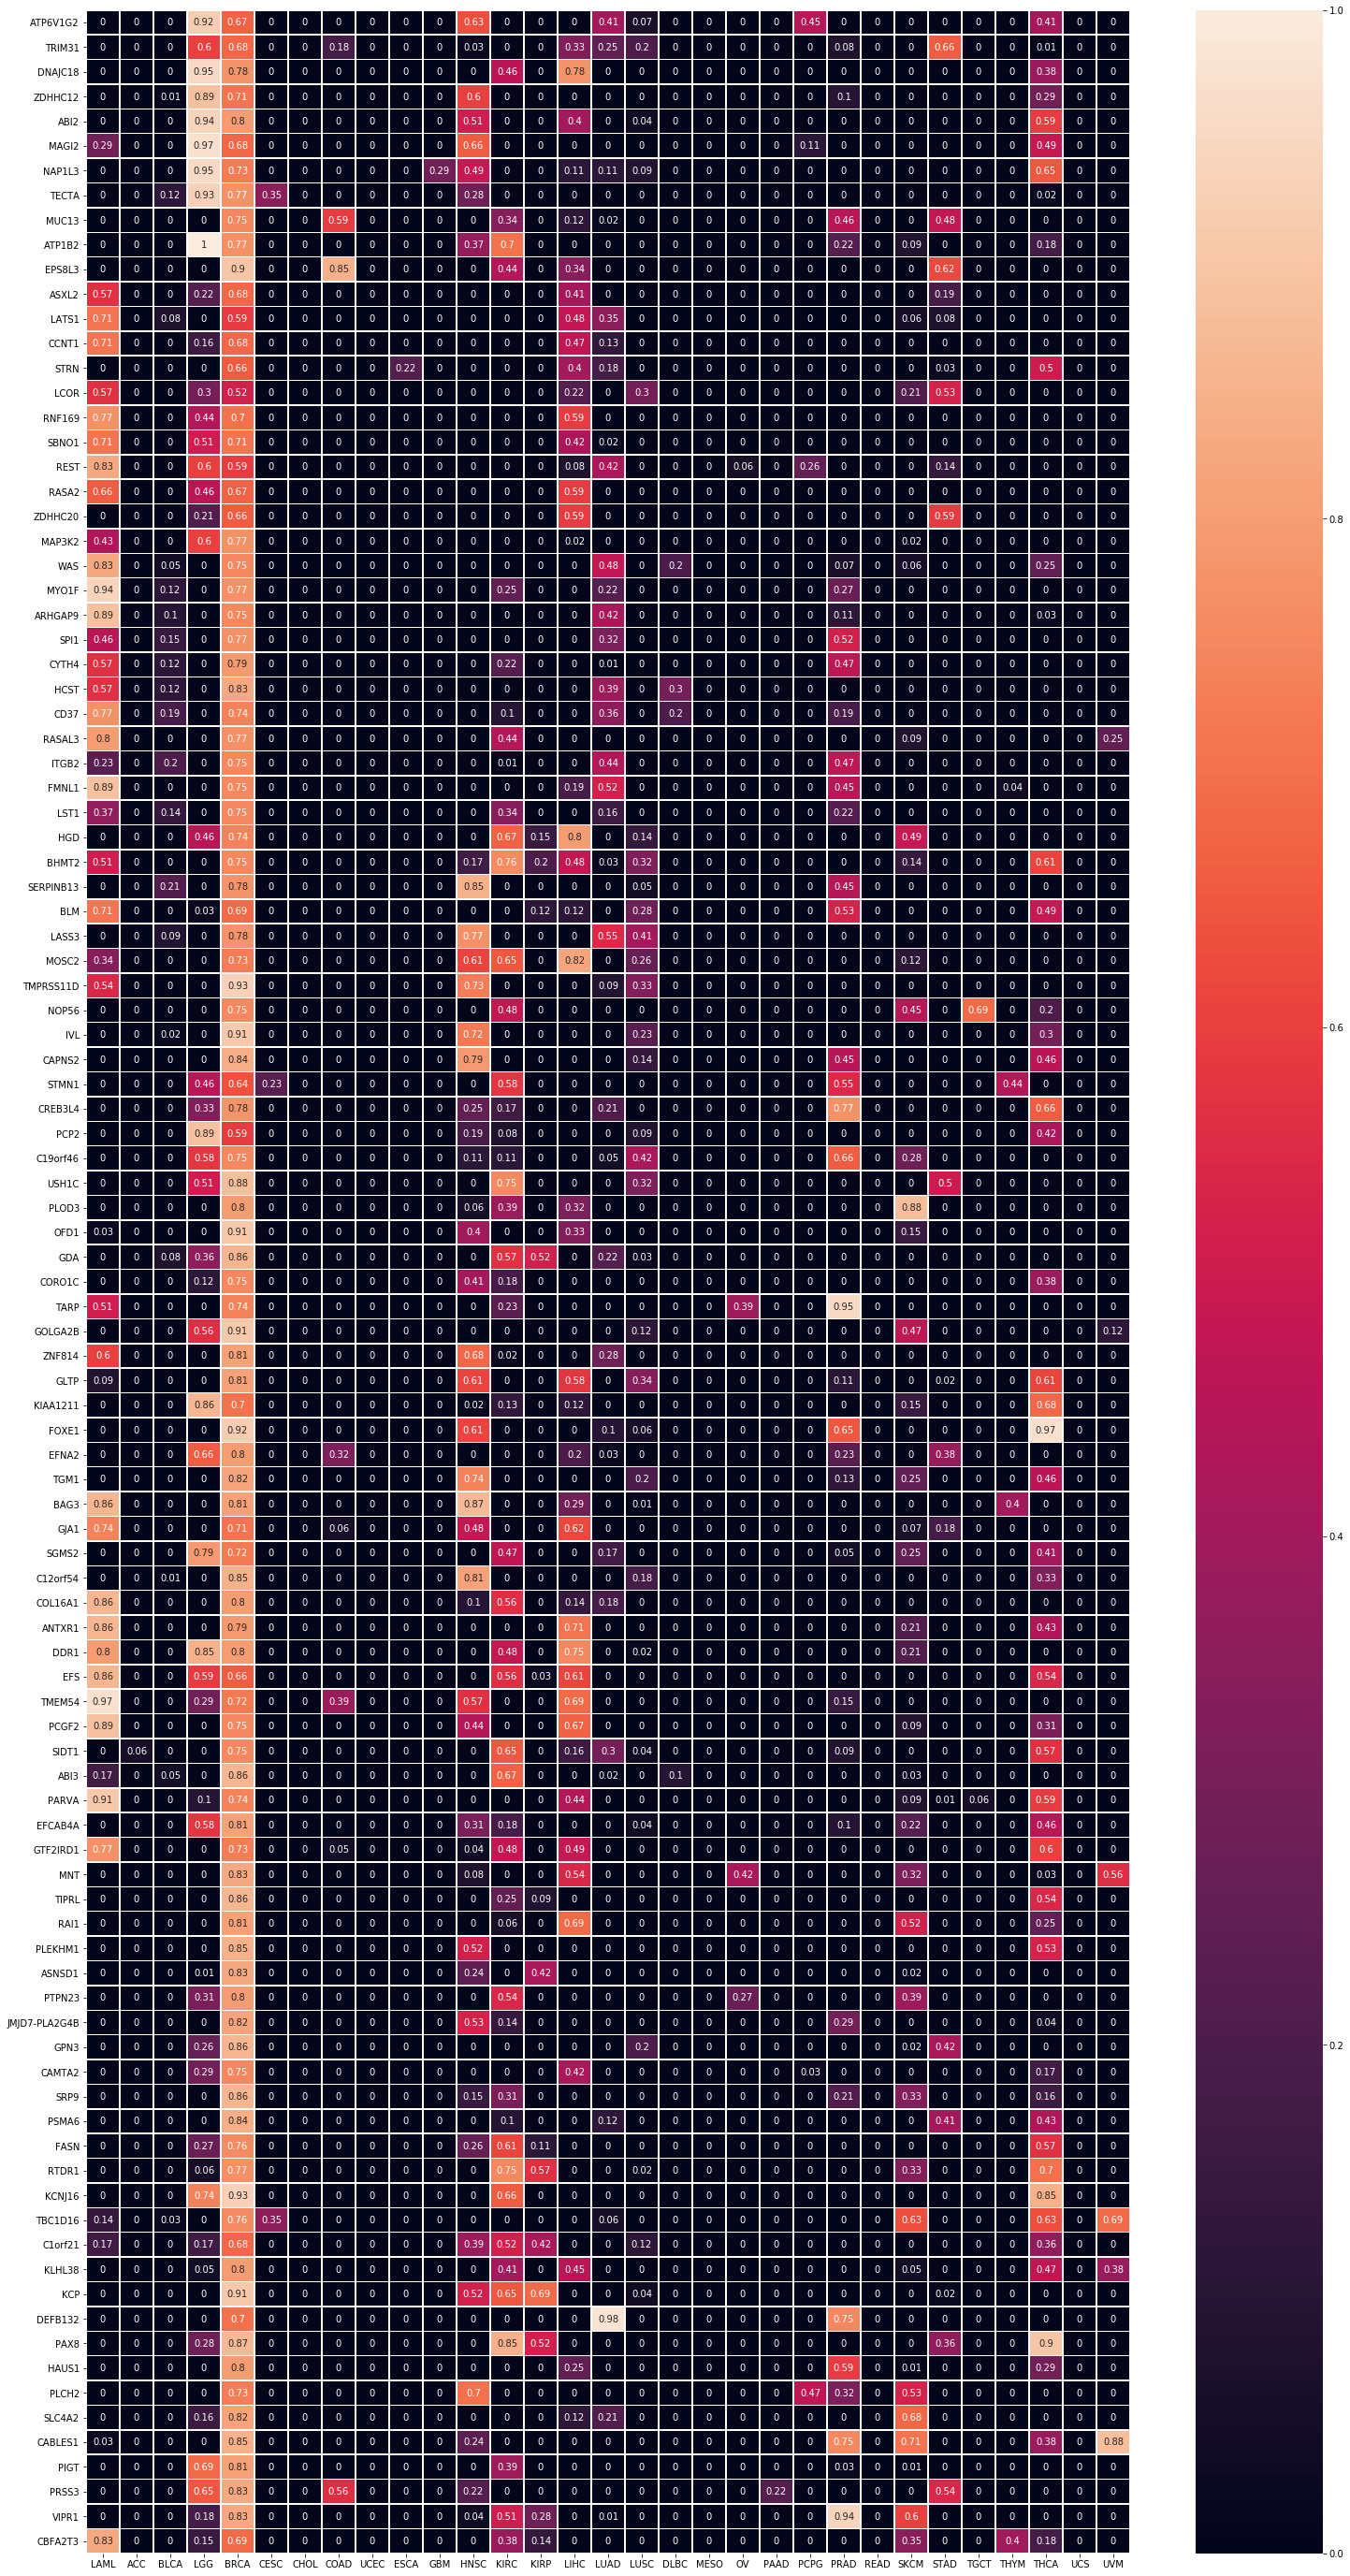

In [59]:
plt.figure(figsize=(25,50))
sns.heatmap(df_gene_wise.astype('float32').round(2),linewidths=.5,annot=True)

In [10]:
genes = list(df_pca2.columns[:-1])

In [82]:
#for i in range(1,31):
df_0 = df_pca2[df_pca2['label'] == 0]['TMEM54']
df = df_pca2[df_pca2['label'] != 0]['TMEM54']

In [39]:
import seaborn as sns

{'whiskers': [<matplotlib.lines.Line2D at 0x21ba2b3d5c0>,
 'caps': [<matplotlib.lines.Line2D at 0x21ba2b3de80>,
 'boxes': [<matplotlib.lines.Line2D at 0x21ba2b3d470>,
 'medians': [<matplotlib.lines.Line2D at 0x21ba2b486d8>,
 'fliers': [<matplotlib.lines.Line2D at 0x21ba2b48b38>,
 'means': []}

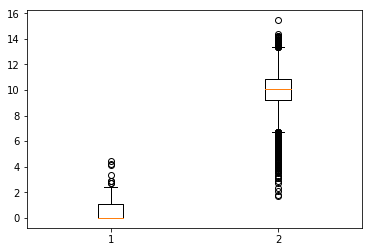

In [84]:
plt.boxplot([df_0,df],positions=[1,2])

In [232]:
dict_report_refined

{38: [[14],
  [0.8235294117647058],
  [0.8235294117647058],
  [0.8235294117647058],
  [0.8235294117647058]],
 52: [[22],
  [0.9454545454545454],
  [0.9043478260869565],
  [0.9454545454545454],
  [0.9244444444444444]],
 60: [[0],
  [0.8571428571428571],
  [0.8108108108108109],
  [0.8571428571428571],
  [0.8333333333333334]],
 65: [[0],
  [0.8571428571428571],
  [0.9090909090909091],
  [0.8571428571428571],
  [0.8823529411764706]],
 68: [[0],
  [0.9714285714285714],
  [0.918918918918919],
  [0.9714285714285714],
  [0.9444444444444445]],
 69: [[0],
  [0.8857142857142857],
  [0.96875],
  [0.8857142857142857],
  [0.9253731343283582]],
 72: [[0],
  [0.9142857142857143],
  [0.9411764705882353],
  [0.9142857142857143],
  [0.9275362318840579]],
 98: [[30], [0.875], [0.9333333333333333], [0.875], [0.9032258064516129]]}

In [97]:
df_normal = pd.read_csv('Desktop/normal_data_new.csv')

In [38]:
arr_pred_test_list[-1]

array([ 4,  0,  4, ..., 28, 24, 24], dtype=int64)

In [88]:
list_index

[0, 22, 0, 0, 0, 0, 0]

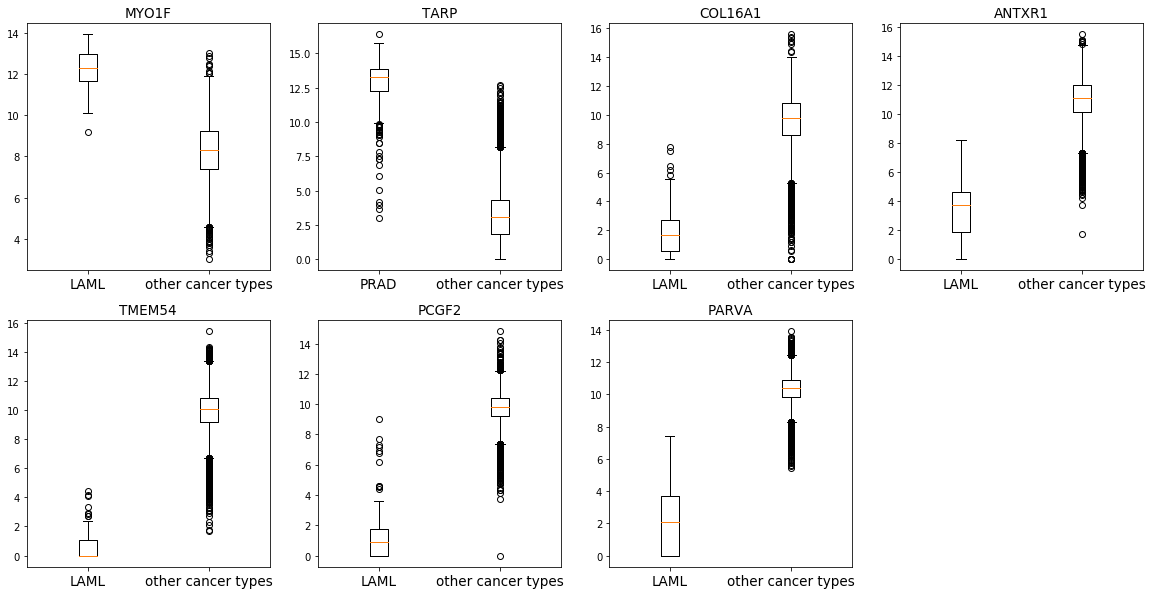

In [484]:
#list_genes = ['TMEM54','ATP1B2','KCNJ16','TMPRSS11D','EPS8L3','BAG3','PAX8','MOSC2','DEFB132','TARP','PLOD3','FOXE1','CABLES1']
#cancer_types = ['LAML','LGG','BRCA','BRCA','COAD','HNSC','KIRC','LIHC','LUAD','PRAD','SKCM','THCA','UVM']
#index = [0,3,4,4,7,11,12,14,15,22,24,28,30]
index= list_index#[14, 22, 0, 0, 0, 0, 0, 30]
list_genes = gene_list
cancer_types = l_str_label
fig = plt.figure(figsize=(20,10))
for i in range(len(index)):
    arr = df_pca2[df_pca2['label'] == index[i]][list_genes[i]]
    arr1 = df_pca2[df_pca2['label'] != index[i]][list_genes[i]]
    #if (list_genes[i] in list(df_normal.columns)) == True:
        #arr2 = df_normal[list_genes[i]]
    ax1 = fig.add_subplot(2,4,i+1)
    ax1.boxplot([arr,arr1])
    ax1.set_xticklabels([cancer_types[i],'other cancer types'],fontsize=13.5)
    ax1.set_title(list_genes[i],fontsize=13.5)
    #if (list_genes[i] in list(df_normal.columns)) == False:
        #ax = fig.add_subplot(4,2,i+1)
        #ax.boxplot([arr,arr1])
        #ax.set_xticklabels([cancer_types[i],'other cancer types'])
        #ax.set_title(list_genes[i])
fig.savefig('Desktop/paper_figures/'+str('boxplots')+'.pdf', format='pdf', dpi=1200,bbox_inches='tight')
plt.show()

In [138]:
np.mean(list(df_pca2[df_pca2['label'] == 0]['BAG3']))

5.348020809248554

In [139]:
np.mean(list(df_normal['BAG3']))

11.482750999872627

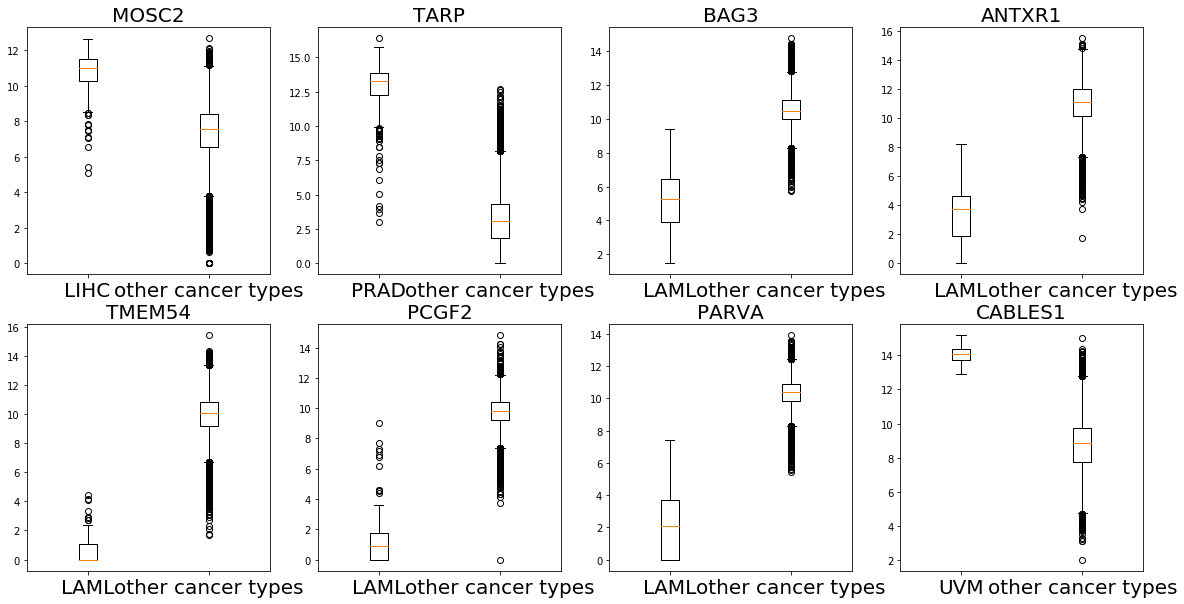

In [92]:
#list_genes = ['TMEM54','ATP1B2','KCNJ16','TMPRSS11D','EPS8L3','BAG3','PAX8','MOSC2','DEFB132','TARP','PLOD3','FOXE1','CABLES1']
#cancer_types = ['LAML','LGG','BRCA','BRCA','COAD','HNSC','KIRC','LIHC','LUAD','PRAD','SKCM','THCA','UVM']
#index = [0,3,4,4,7,11,12,14,15,22,24,28,30]
df_normal = pd.read_csv('Desktop/normal_data_new.csv')
index= [14, 22, 0, 0, 0, 0, 0, 30]
list_genes = ['MOSC2','TARP','BAG3','ANTXR1','TMEM54','PCGF2','PARVA','CABLES1']
cancer_types = ['LIHC','PRAD','LAML','LAML','LAML','LAML','LAML','UVM']
fig = plt.figure(figsize=(20,10))
for i in range(len(index)):
    arr = df_pca2[df_pca2['label'] == index[i]][list_genes[i]]
    arr1 = df_pca2[df_pca2['label'] != index[i]][list_genes[i]]
    #if (list_genes[i] in list(df_normal.columns)) == True:
        #arr2 = df_normal[list_genes[i]]
        #ax1 = fig.add_subplot(2,4,i+1)
        #ax1.boxplot([arr,arr1,arr2])
        #ax1.set_xticklabels([cancer_types[i],'other cancer types','normal']`)
        #ax1.set_title(list_genes[i],fontsize=10)
        
    #else:    
    ax1 = fig.add_subplot(2,4,i+1)
    ax1.boxplot([arr,arr1])
    ax1.set_xticklabels([cancer_types[i],'other cancer types'],fontsize=20)
    ax1.set_title(list_genes[i],fontsize=20)
    #if (list_genes[i] in list(df_normal.columns)) == False:
        #ax = fig.add_subplot(4,2,i+1)
        #ax.boxplot([arr,arr1])
        #ax.set_xticklabels([cancer_types[i],'other cancer types'])
        #ax.set_title(list_genes[i])

# Predict proba

In [204]:
np.random.seed(0)
r = np.random.randint(500)
(X_train, X_test, y_train, y_test) = split_train_test(df_pca2,r)

In [210]:
clf_log = LogisticRegression(solver='lbfgs').fit(X_train,y_train)
clf_log.score(X_test,y_test)

0.9301868239921337

In [206]:
clf_log.predict_proba(X_test)[0,:]

array([9.45201288e-01, 3.77929744e-04, 6.54181916e-10, 8.10520163e-17,
       3.17834365e-17, 2.11318094e-10, 1.67079829e-07, 2.85547483e-06,
       1.97419831e-11, 5.53698774e-06, 6.54547594e-07, 1.04487867e-03,
       2.74308902e-07, 1.50210967e-13, 1.63954697e-06, 5.29060891e-02,
       2.26170450e-04, 1.43213356e-04, 4.85009417e-10, 8.84747453e-05,
       3.77493226e-11, 1.36256648e-09, 2.42770317e-08, 9.98228528e-18,
       2.03929004e-08, 4.67855527e-07, 1.48700406e-08, 2.02018635e-07,
       9.58222988e-08, 1.30003629e-16, 3.09639273e-13])

In [207]:
list_y_train = list(y_train)
list_num_train_samples = []
for i in range(31):
    c = 0
    for j in range(len(list_y_train)):
        if list_y_train[j] == i:
            c = c+1
    list_num_train_samples.append(c)

In [208]:
y_test[y_test == 1]

219    1
189    1
173    1
220    1
240    1
212    1
190    1
191    1
221    1
197    1
236    1
247    1
226    1
248    1
183    1
217    1
Name: label, dtype: int64

In [145]:
list_acc_prob = []
prob=0.05
while(prob<1.00):
    acc = []
    counter = 0
    for i in range(31):
        y_temp = y_test[y_test == i]
        samples = len(y_temp)
        prob_temp = logits[i,counter:counter+samples]
        acc_prob = prob_temp[prob_temp >= prob]
        counter = counter+samples
        acc.append((len(list(acc_prob))/samples)*100)
    list_acc_prob.append(acc)
    print(prob)
    prob = prob+0.05

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.6
0.65
0.7000000000000001
0.7500000000000001
0.8000000000000002
0.8500000000000002
0.9000000000000002
0.9500000000000003


In [146]:
len(list_acc_prob)

19

In [149]:
acc_prob = np.array(list_acc_prob)

In [152]:
acc_prob[:,0]

array([100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        ,  94.28571429])

In [138]:
np.arange(0.05,1.00,0.05)

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

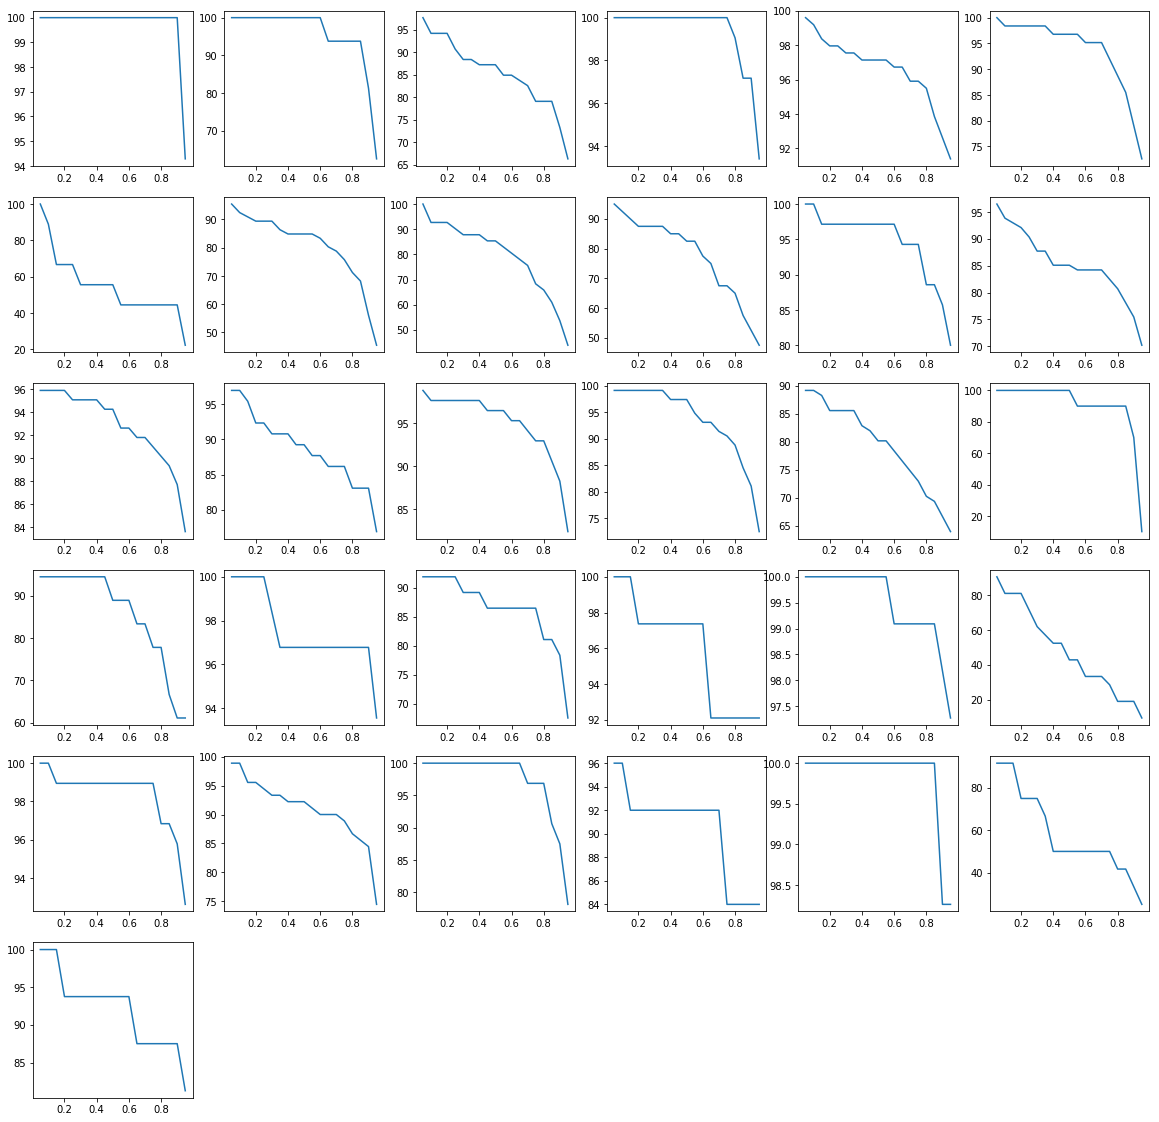

In [160]:

for i in range(31):
    ax = fig.add_subplot(6,6,i+1)
    acc_prob_sliced = acc_prob[:,i]
    arr_prob = np.arange(0.05,1.00,0.05)
    ax.plot(arr_prob,acc_prob_sliced)

In [99]:
for i in range(0.5):
    print(i)

TypeError: 'float' object cannot be interpreted as an integer

In [57]:
logits[0,0:5][logits[0,0:5] > 0.99]

array([0.99596417, 0.9901169 , 0.99368805, 0.9941754 ], dtype=float32)

In [54]:
logits[:,0]

array([9.8904538e-01, 3.1678876e-05, 4.6650621e-07, 5.5797368e-06,
       3.5977373e-05, 2.0598832e-06, 5.7339983e-04, 1.1333270e-03,
       1.4339246e-06, 7.1857916e-04, 1.1907639e-05, 1.7108321e-05,
       4.1282462e-04, 4.7730959e-05, 1.5026427e-04, 2.2943264e-03,
       2.1689995e-04, 2.0316085e-03, 4.7926433e-06, 5.9934903e-04,
       4.2107200e-07, 4.9491136e-06, 1.2861441e-04, 3.7046050e-06,
       7.0323789e-04, 1.2528175e-03, 4.0859368e-04, 1.3017988e-04,
       1.3058902e-05, 1.9526171e-07, 1.9643279e-05], dtype=float32)

In [ ]:
temp_prev = 0
list_accuracy = []
for i in range(31):
    temp = list_num_train_samples[i]
    sliced_y_pred = arr_pred_train[temp_prev:temp_prev+temp]
    sliced_y_train = y_train[temp_prev:temp_prev+temp]
    temp_prev = temp_prev+temp
    accuracy = (np.sum(sliced_y_pred == sliced_y_train) / len(sliced_y_train))*100
    list_accuracy.append(accuracy)

# Analysis of uncertainity

In [ ]:
list_y_train = list(y_train)
list_num_train_samples = []
for i in range(31):
    c = 0
    for j in range(len(list_y_train)):
        if list_y_train[j] == i:
            c = c+1
    list_num_train_samples.append(c)

In [ ]:
list_acc_prob = []
counter = 0
for i in range(0,500):
    y_temp = y_test[y_test == i]
    samples = len(y_temp)
    prob_temp = logits[i,counter:counter+samples]
    acc_prob = prob_temp[prob_temp >= prob]
    counter = counter+samples
    acc.append((len(list(acc_prob))/samples)*100)
    list_acc_prob.append(acc)
    print(prob)
    prob = prob+0.05

In [32]:
logit_array = np.array(logits)

In [58]:
logit_array.shape

(500, 31, 2034)

In [19]:
dict_prob_temp = {}
for i in range(31):
    dict_prob_temp[i] = []

In [20]:
for logit_temp in range(len(logits)):
    counter = 0
    for i in range(31):
        y_temp = y_test[y_test == i]
        samples = len(y_temp)
        prob_temp = logits[logit_temp][i,counter:counter+samples]
        dict_prob_temp[i].append(list(prob_temp))
        counter = counter+samples

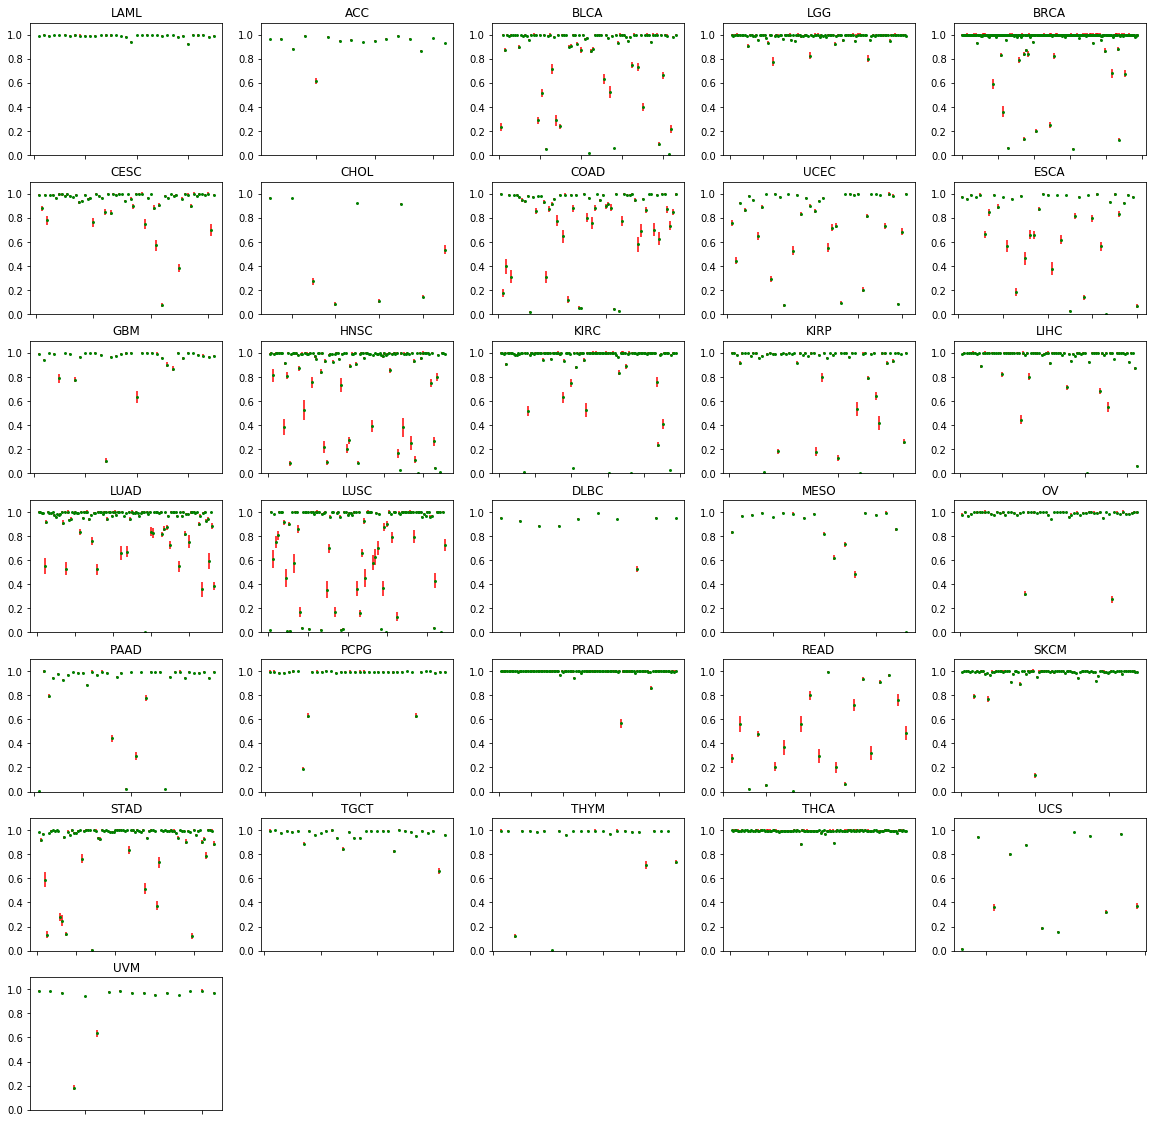

In [61]:
fig = plt.figure(figsize = (20,20))
cancer_types = ['LAML','ACC','BLCA','LGG','BRCA','CESC','CHOL','COAD','UCEC','ESCA','GBM','HNSC','KIRC','KIRP','LIHC','LUAD','LUSC','DLBC','MESO','OV','PAAD','PCPG','PRAD','READ','SKCM','STAD','TGCT','THYM','THCA','UCS','UVM']
for i in range(31):
    a = np.mean(dict_prob_temp[i],axis=0)
    b = np.std(dict_prob_temp[i],axis=0) * 1e3 * 2
    x = np.arange(1,len(dict_prob_temp[i][0])+1)
    ax = fig.add_subplot(7,5,i+1)
    plt.errorbar(x, a, b, linestyle='None',marker='.',ecolor='r',c='g',markeredgewidth=0.00001)
    ax.set_title(cancer_types[i])
    ax.set_ylim(0,1.1)
    ax.set_xticklabels('')

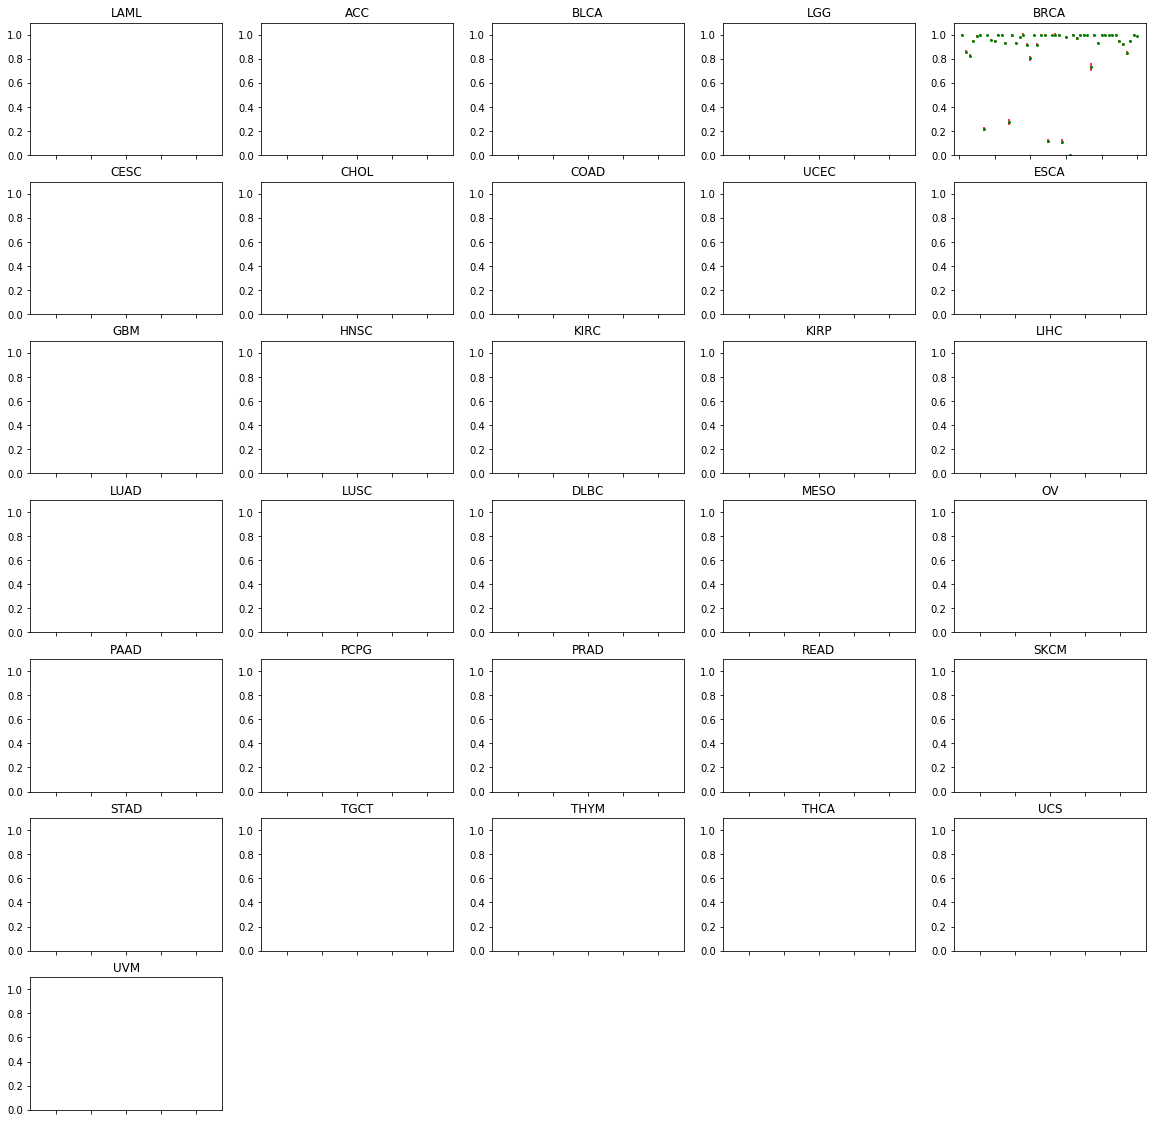

In [49]:
fig = plt.figure(figsize = (20,20))
cancer_types = ['LAML','ACC','BLCA','LGG','BRCA','CESC','CHOL','COAD','UCEC','ESCA','GBM','HNSC','KIRC','KIRP','LIHC','LUAD','LUSC','DLBC','MESO','OV','PAAD','PCPG','PRAD','READ','SKCM','STAD','TGCT','THYM','THCA','UCS','UVM']
for i in range(31):
    a = np.mean(dict_prob_temp[i],axis=0)
    b = np.std(dict_prob_temp[i],axis=0) * 1e3 * 2
    x = np.arange(1,len(dict_prob_temp[i][0])+1)
    ax = fig.add_subplot(7,5,i+1)
    plt.errorbar(x, a, b, linestyle='None',marker='.',ecolor='r',c='g',markeredgewidth=0.00001)
    ax.set_title(cancer_types[i])
    ax.set_ylim(0,1.1)
    ax.set_xticklabels('')

In [44]:
np.random.seed(0)
r = np.random.randint(500)
(X_train, X_test, y_train, y_test) = split_train_test(df_pca2,r)

In [45]:
X_test = pd.DataFrame(np.ones((1,103))*100)

In [46]:
y_test = np.ones((1,))

In [47]:
Ytrain = np.array(y_train).reshape(len(y_train),)
X_train = np.array(X_train.T.reset_index(drop=True))
Y_train = tf.Session().run(tf.one_hot(Ytrain,len(set(Ytrain)),axis=1)).reshape(len(Ytrain),len(set(Ytrain))).T
Ytest = np.array(y_test).reshape(len(y_test),)
X_test = np.array(X_test.T.reset_index(drop=True))
Y_test = tf.Session().run(tf.one_hot(Ytest,len(set(Ytest)),axis=1)).reshape(len(Ytest),len(set(Ytest))).T

In [48]:
layers_dims = [X_train.shape[0],250,95,31]
[_,_,logits,logits_train,arr_pred_test,arr_pred_train] = model(X_train=X_train,Y_train=Y_train,X_test =X_test,Y_test = Y_test, learning_rate=0.0005,num_epochs=3500,print_cost=True,layers_dims = layers_dims)

Cost after epoch 0: 100.214638
Cost after epoch 100: 98.668396
Cost after epoch 200: 97.784966
Cost after epoch 300: 97.394218
Cost after epoch 400: 97.209717
Cost after epoch 500: 97.043793
Cost after epoch 600: 96.973923
Cost after epoch 700: 96.903824
Cost after epoch 800: 96.873451
Cost after epoch 900: 94.251862
Cost after epoch 1000: 94.231339
Cost after epoch 1100: 94.145981
Cost after epoch 1200: 94.149834
Cost after epoch 1300: 94.132957
Cost after epoch 1400: 94.144089
Cost after epoch 1500: 94.114418
Cost after epoch 1600: 92.242096
Cost after epoch 1700: 92.206703
Cost after epoch 1800: 92.249779
Cost after epoch 1900: 92.191315
Cost after epoch 2000: 92.212646
Cost after epoch 2100: 90.734207
Cost after epoch 2200: 90.751938
Cost after epoch 2300: 90.727829
Cost after epoch 2400: 90.691910
Cost after epoch 2500: 89.541817
Cost after epoch 2600: 89.578423
Cost after epoch 2700: 89.524017
Cost after epoch 2800: 88.507179
Cost after epoch 2900: 88.540108
Cost after epoch 3000

In [49]:
a = logits

In [50]:
std = np.std(a,axis=0)

In [51]:
std

array([[5.0538802e-07],
       [1.6592338e-07],
       [5.7060934e-10],
       [5.7977400e-07],
       [6.3368688e-08],
       [9.0064134e-09],
       [2.5889176e-07],
       [2.9232035e-08],
       [1.7481928e-07],
       [3.3250157e-07],
       [1.3354686e-07],
       [4.8244283e-06],
       [1.6905042e-05],
       [2.7913518e-06],
       [5.4214621e-07],
       [1.4885939e-07],
       [9.5033919e-09],
       [7.9154951e-08],
       [5.3347918e-08],
       [1.9334973e-06],
       [1.6902255e-06],
       [8.2928231e-08],
       [4.5776304e-07],
       [6.7347582e-07],
       [2.4883423e-08],
       [4.9032486e-05],
       [4.5463210e-05],
       [1.9196924e-07],
       [3.8796694e-07],
       [5.8325060e-08],
       [1.4742166e-07]], dtype=float32)

In [206]:
std

array([[2.1504101e-07, 2.1504101e-07, 2.1504101e-07, ..., 2.1504101e-07,
        2.1504101e-07, 2.1504822e-07],
       [8.1051489e-08, 8.1051489e-08, 8.1051489e-08, ..., 8.1051489e-08,
        8.1051489e-08, 8.1051297e-08],
       [5.1056612e-09, 5.1056612e-09, 5.1056612e-09, ..., 5.1056612e-09,
        5.1056612e-09, 5.1057749e-09],
       ...,
       [2.2578121e-07, 2.2578121e-07, 2.2578121e-07, ..., 2.2578121e-07,
        2.2578121e-07, 2.2578276e-07],
       [1.5741643e-08, 1.5741643e-08, 1.5741643e-08, ..., 1.5741643e-08,
        1.5741643e-08, 1.5741769e-08],
       [2.7922033e-07, 2.7922033e-07, 2.7922033e-07, ..., 2.7922033e-07,
        2.7922033e-07, 2.7923480e-07]], dtype=float32)

In [197]:
a[1]

array([[0.01692498, 0.01692498, 0.01692498, ..., 0.01692498, 0.01692498,
        0.01692498],
       [0.00648731, 0.00648731, 0.00648731, ..., 0.00648731, 0.00648731,
        0.00648731],
       [0.00026863, 0.00026863, 0.00026863, ..., 0.00026863, 0.00026863,
        0.00026863],
       ...,
       [0.020173  , 0.020173  , 0.020173  , ..., 0.020173  , 0.020173  ,
        0.020173  ],
       [0.00116078, 0.00116078, 0.00116078, ..., 0.00116078, 0.00116078,
        0.00116078],
       [0.0253454 , 0.0253454 , 0.0253454 , ..., 0.0253454 , 0.0253454 ,
        0.0253454 ]], dtype=float32)

In [203]:
b

array([0.00529069, 0.00263027, 0.00401673, 0.00978104, 0.00298786,
       0.01265408, 0.00433542, 0.00345409, 0.00516897, 0.00394086,
       0.00362898, 0.0042404 , 0.00170554, 0.00150553, 0.00652646,
       0.00170042], dtype=float32)

In [194]:
for i in range(len)

array([[2.1504101e-07, 2.1504101e-07, 2.1504101e-07, ..., 2.1504101e-07,
        2.1504101e-07, 2.1504822e-07],
       [8.1051489e-08, 8.1051489e-08, 8.1051489e-08, ..., 8.1051489e-08,
        8.1051489e-08, 8.1051297e-08],
       [5.1056612e-09, 5.1056612e-09, 5.1056612e-09, ..., 5.1056612e-09,
        5.1056612e-09, 5.1057749e-09],
       ...,
       [2.2578121e-07, 2.2578121e-07, 2.2578121e-07, ..., 2.2578121e-07,
        2.2578121e-07, 2.2578276e-07],
       [1.5741643e-08, 1.5741643e-08, 1.5741643e-08, ..., 1.5741643e-08,
        1.5741643e-08, 1.5741769e-08],
       [2.7922033e-07, 2.7922033e-07, 2.7922033e-07, ..., 2.7922033e-07,
        2.7922033e-07, 2.7923480e-07]], dtype=float32)

In [ ]:
for logit_temp in range(len(logits)):
    prob_temp = logits[logit_temp][i,:]
    dict_prob_temp[i].append(list(prob_temp))
    counter = counter+samples

In [401]:
df_normal = pd.read_csv('Desktop/normal_data_new.csv')

In [402]:
df_normal

ATP6V1G2  TRIM31  DNAJC18  ZDHHC12     ABI2    MAGI2   NAP1L3   TECTA  \
0       6.9224  4.9488   9.1327  10.0547  11.5383   3.5597   1.4116  4.2678   
1       5.6379  0.0000   9.3314   7.5321  11.3601  10.6619   9.5940  6.6555   
2       7.5896  2.7150   8.9430   8.8197  11.9006   9.8769   7.0114  7.2411   
3       4.3440  4.7091   8.3496   9.9074   9.9459   7.8091   6.8355  5.1534   
4       3.5200  4.4557   7.5049  10.5161  10.3739   7.8211   5.1307  5.9962   
...        ...     ...      ...      ...      ...      ...      ...     ...   
7846    8.5659  0.0000  10.1635   7.9125  12.0682  10.3160  10.4925  7.7601   
7847    2.5579  2.5579   7.3570  10.1108   9.8540   7.0011   3.1933  3.4298   
7848    7.0320  1.1750   9.6206   8.1752  11.4134  11.1795   7.7216  7.4787   
7849   13.6287  0.0000  11.0089   6.5453  12.2430  10.4532  11.8849  8.0158   
7850    4.6595  4.3517   8.5122   9.3177  11.0093   7.7373   5.6655  5.2713   

        MUC13   ATP1B2  ...  DEFB132     PAX8   HAUS1    PLCH2   SLC4A2  \
0     10.2215   4.3286  ...      0.0   8.0502  9.8865   8.7627  11.1438   
1      1.6862   7.1816  ...      0.0   5.7008  8.1317   3.8387  11.1514   
2      2.2359   8.9899  ...      0.0  15.8387  8.0569   9.1086  12.1615   
3      0.0000   6.6218  ...      0.0   8.0677  8.3013  12.6573  11.4265   
4      7.2056   7.9335  ...      0.0   3.5200  7.9641  10.0902  13.4034   
...       ...      ...  ...      ...      ...     ...      ...      ...   
7846   2.0774  10.6219  ...      0.0   7.2361  8.2390  10.6967  10.6050   
7847   2.9103   6.0483  ...      0.0   6.3370  7.8804  12.1367  10.9569   
7848   1.8139   9.3333  ...      0.0   7.1357  8.7606   4.7770  11.1133   
7849   1.3163  14.1694  ...      0.0   5.9215  7.4419  13.8190   9.9263   
7850   1.1464   5.1285  ...      0.0   7.1481  8.1486   7.3435  12.7028   

      CABLES1     PIGT    PRSS3    VIPR1  CBFA2T3  
0     11.4011  11.0370   1.8034   3.9177  10.8174  
1      7.2089  12.0153   1.6862   7.4395   5.8189  
2      9.9538  11.5986   3.8987   9.1452   8.7558  
3     10.3510  11.8344   9.7683  10.6923   8.6161  
4      8.3340  11.3960  15.7042   6.1099  11.7095  
...       ...      ...      ...      ...      ...  
7846   8.1916  11.9327   4.3451   7.6487   8.8689  
7847   8.0137  11.1229  11.4681   8.3338   7.4674  
7848   9.0273  11.6461   2.5926   7.3400   8.1563  
7849  10.0547  10.6732  10.1562  11.3858  11.8819  
7850   8.3057  11.7112   4.4350  10.9331   9.1550  

[7851 rows x 96 columns]

In [46]:
df_normal['C19orf46'] = df_pca2['C19orf46'].mean()
df_normal['MOSC2'] = df_pca2['MOSC2'].mean()
df_normal['LASS3'] = df_pca2['LASS3'].mean()
df_normal['TARP'] = df_pca2['TARP'].mean()
df_normal['GOLGA2B'] = df_pca2['GOLGA2B'].mean()
df_normal['EFCAB4A'] = df_pca2['EFCAB4A'].mean()
df_normal['RTDR1'] = df_pca2['RTDR1'].mean()

In [47]:
df_normal = df_normal.iloc[0:2000]

In [48]:
np.random.seed(0)
r = np.random.randint(500)
(X_train, X_test, y_train, y_test) = split_train_test(df_pca2,r)

In [49]:
X_test = df_normal

In [51]:
y_test = np.zeros((len(df_normal))).reshape(len(df_normal),)

In [52]:
Ytrain = np.array(y_train).reshape(len(y_train),)
X_train = np.array(X_train.T.reset_index(drop=True))
Y_train = tf.Session().run(tf.one_hot(Ytrain,len(set(Ytrain)),axis=1)).reshape(len(Ytrain),len(set(Ytrain))).T
Ytest = np.array(y_test).reshape(len(y_test),)
X_test = np.array(X_test.T.reset_index(drop=True))
Y_test = tf.Session().run(tf.one_hot(Ytest,len(set(Ytest)),axis=1)).reshape(len(Ytest),len(set(Ytest))).T

In [53]:
layers_dims = [X_train.shape[0],250,95,31]
[_,_,logits,logits_train,arr_pred_test,arr_pred_train] = model(X_train=X_train,Y_train=Y_train,X_test =X_test,Y_test = Y_test, learning_rate=0.0005,num_epochs=3500,print_cost=True,layers_dims = layers_dims)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Cost after epoch 0: 100.182373
Cost after epoch 100: 98.636017
Cost after epoch 200: 97.752617
Cost after epoch 300: 97.361946
Cost after epoch 400: 97.177429
Cost after epoch 500: 97.010979
Cost after epoch 600: 96.941338
Cost after epoch 700: 96.871552
Cost after epoch 800: 96.841209
Cost after epoch 900: 94.200668
Cost after epoch 1000: 94.179909
Cost after epoch 1100: 94.094482
Cost after epoch 1200: 94.098351
Cost after epoch 1300: 94.081093
Cost after epoch 1400: 94.092384
Cost after epoch 1500: 94.062607
Cost after epoch 1600: 92.176903
Cost after epoch 1700: 92.174271
Cost after epoch 1800: 92.217133
Cost after epoch 1900: 92.158562
Cost after epoch 2000: 92.180191
Cost after epoch 2100: 90.691193
Cost after epoch 2200: 90.708855
Cost after epoch 2300: 90.685303
Cost after epoch 2400: 90.6

In [139]:
b = np.argmax(logits[0],axis=0)

In [140]:
b_index = np.where(b==25)

In [141]:
len(b_index[0])

294

In [148]:
c = logits[1][:,0]

In [113]:
for i in range(31):
    argmax_temp = np.argmax(logits[0],axis=0)
    arg = np.where(b==i)
    from j in range(0,len(arg[0])):
        

array([2.6791072e-03, 1.9010827e-04, 1.4048050e-05, 3.9877659e-03,
       2.7815315e-03, 2.7354997e-06, 1.1305470e-03, 5.0695318e-05,
       5.8495398e-06, 6.4929933e-03, 6.1574145e-03, 4.3832894e-02,
       8.8856049e-02, 2.7470389e-02, 6.8901328e-04, 2.4305827e-04,
       3.5324574e-05, 5.4774160e-04, 4.5133082e-04, 1.3147253e-01,
       8.9285010e-03, 6.7561115e-05, 4.1118148e-04, 4.5623546e-04,
       1.7793110e-04, 6.4287019e-01, 3.1035952e-03, 1.0089971e-04,
       2.0590873e-02, 1.1359936e-03, 5.0658425e-03], dtype=float32)

In [154]:
a = np.array(logits)[:,:,1]

In [155]:
c=np.std(a,axis=0)* 1e3 *2

In [156]:
d=np.mean(a,axis=0)

In [157]:
c

array([2.9205861e-05, 1.4824646e-04, 9.2293959e-08, 6.7743793e-04,
       4.4059993e-06, 5.4382220e-08, 2.0222047e-05, 8.3142879e-07,
       6.4608756e-08, 3.2085762e-04, 1.4723706e-04, 9.8065110e-03,
       8.5272966e-03, 1.4253266e-03, 9.3271650e-05, 1.1998067e-05,
       1.8238765e-07, 4.0154509e-06, 3.2724598e-05, 3.5520486e-04,
       6.2629138e-04, 3.9776940e-05, 1.1942667e-04, 6.7230562e-06,
       4.0671630e-06, 1.8087922e-02, 3.7127509e-05, 9.2786913e-06,
       3.3264912e-03, 5.0863810e-06, 2.1399294e-04], dtype=float32)

In [158]:
d

array([6.6279055e-04, 2.6578032e-03, 1.2600317e-06, 9.7742872e-03,
       8.1354585e-05, 6.3625953e-07, 3.5019236e-04, 1.5365300e-05,
       9.0306037e-07, 3.4887251e-03, 2.4071475e-03, 1.3877726e-01,
       1.6705184e-01, 1.7950131e-02, 1.7846879e-03, 1.8426553e-04,
       1.5338063e-06, 7.8583347e-05, 7.0603844e-04, 7.3131374e-03,
       1.0091234e-02, 8.5145951e-04, 2.2151994e-03, 1.3319451e-04,
       6.9648384e-05, 5.7150090e-01, 5.8976788e-04, 1.3886641e-04,
       5.6792915e-02, 9.2977512e-05, 4.2359242e-03], dtype=float32)

In [24]:
for i in range()
logits[0][:,]

array([3.6165977e-06, 4.5379999e-04, 2.3276205e-06, 8.4078754e-05,
       3.5623398e-05, 3.0377661e-05, 8.0285688e-05, 4.4048081e-09,
       9.5479418e-06, 1.3666930e-04, 3.3477579e-06, 1.1477362e-04,
       9.2675669e-05, 3.7931380e-04, 7.4831843e-07, 9.1103575e-05,
       6.1826713e-06, 4.1410021e-07, 3.7724756e-05, 9.7253585e-05,
       1.7026055e-04, 2.6000334e-06, 1.4578858e-04, 3.7612887e-07,
       3.8710820e-07, 8.3659080e-07, 2.1710743e-07, 2.7222064e-04,
       9.9766719e-01, 3.9696679e-05, 4.0558763e-05], dtype=float32)

In [27]:
log_0 = logits[0][0]

In [34]:
len(log_0)

2034

In [31]:
len(y_test[y_test == 0])

35

In [58]:
y_true = []
for i in range(2034):
    if i <35:
        y_true.append(1)
    if
        y_true.append(0)

In [64]:
l = log_0[0:70]

In [67]:
counter = 0
for i in range(31):
        y_temp = y_test[y_test == i]
        samples = len(y_temp)
        prob_temp = logits[0][i,counter:counter+samples]
        dict_prob_temp[i].append(list(prob_temp))
        counter = counter+samples

In [59]:
from sklearn.calibration import calibration_curve

In [65]:
calibration_curve(y_true,l)

ValueError: Found input variables with inconsistent numbers of samples: [2034, 70]

In [68]:
l = []
for i in range(31):
    l.extend(dict_prob_temp[i][0])

In [77]:
array_l = np.array(l)

In [95]:
bin_label =  np.where(array_l < 0.2) np.where(((0.1 < array_l

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

array([0.05241251, 0.01839045, 0.05593253, 0.09431779, 0.00974953,
       0.05647376, 0.04977041, 0.07587469, 0.08515526, 0.02173238,
       0.05631752, 0.05105273, 0.04070568, 0.03068291, 0.07312766,
       0.09467008, 0.08452952, 0.02934447, 0.00267039, 0.06827347,
       0.08389544, 0.09108622, 0.0900747 , 0.02421588, 0.00076495,
       0.04568503, 0.00956222, 0.01029813, 0.04246622, 0.00265589,
       0.00265516, 0.02471361, 0.01143112, 0.00018868, 0.00309784,
       0.0648687 , 0.00192823, 0.01741929, 0.01058427, 0.01558125,
       0.03825466, 0.03013579, 0.021419  , 0.0244632 , 0.02742923,
       0.02739032, 0.00112156, 0.03549903, 0.00377955, 0.00050091,
       0.00543094, 0.02556944, 0.01738166, 0.02437833, 0.05216414,
       0.00355905, 0.06144135, 0.00874343, 0.00800399, 0.01669913],
      dtype=float32)

In [98]:
array_l

array([0.1356714 , 0.19808413, 0.12809958, 0.11272824, 0.1450528 ,
       0.17649546, 0.12218031, 0.18638973, 0.14251094, 0.10407317,
       0.16742535, 0.11488418, 0.18387198, 0.17924842, 0.12942079,
       0.17211203, 0.16738433, 0.16011748, 0.13186167, 0.1915889 ,
       0.13561852, 0.13419949, 0.13928191, 0.11964226, 0.12025105,
       0.18673424, 0.15358227, 0.18262318], dtype=float32)

In [99]:
bins = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

In [112]:
confidence_list = []
accuracy_list = []
for i in range(len(bins)):
    if i == 0:
        bin_label =  np.where(array_l < bins[i])
    if i > 0:
        bin_label =  np.where((array_l > bins[i-1]) & (array_l < bins[i]))
    bin_prob = array_l[bin_label]
    bin_true = np.array(y_test)[bin_label]
    bin_pred = np.array(arr_pred_test)[bin_label]
    bin_confidence = np.mean(bin_prob)
    bin_accuracy = np.sum(bin_true == bin_pred) / len(list(bin_true))
    confidence_list.append(bin_confidence)
    accuracy_list.append(bin_accuracy)

In [113]:
accuracy_list

[0.0,
 0.0,
 0.125,
 0.3181818181818182,
 0.5833333333333334,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [115]:
confidence_list

[0.03396202,
 0.15075478,
 0.2537124,
 0.36194068,
 0.45114025,
 0.55041444,
 0.65018326,
 0.756181,
 0.8589036,
 0.98916376]

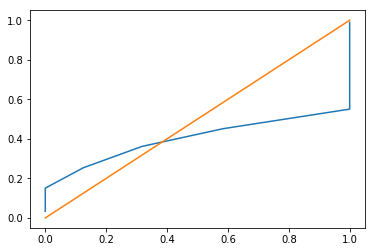

In [119]:
plt.plot(accuracy_list,confidence_list)
plt.plot([0,1],[0,1])

In [110]:
bin_true

array([ 0,  0,  0, ..., 30, 30, 30], dtype=int64)

In [111]:
np.sum(list(bin_true) == list(bin_pred))

1

In [120]:
df = pd.DataFrame()

In [122]:
df['0'] = accuracy_list

In [123]:
df['1'] = confidence_list

In [124]:
df.to_csv('Desktop/reliability_curve.csv',index=False)

In [20]:
dict_prob_temp = {}
for i in range(31):
    dict_prob_temp[i] = []

In [21]:
counter = 0
for i in range(31):
        y_temp = y_test[y_test == i]
        samples = len(y_temp)
        prob_temp = logits[0][i,counter:counter+samples]
        dict_prob_temp[i].append(list(prob_temp))
        counter = counter+samples

In [22]:
l = []
for i in range(31):
    l.extend(dict_prob_temp[i][0])

In [23]:
array_l = np.array(l)

In [24]:
bins = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

In [25]:
error = 0
confidence_list = []
accuracy_list = []
for i in range(len(bins)):
    if i == 0:
        bin_label =  np.where(array_l < bins[i])
    if i > 0:
        bin_label =  np.where((array_l > bins[i-1]) & (array_l < bins[i]))
    bin_prob = array_l[bin_label]
    bin_true = np.array(y_test)[bin_label]
    bin_pred = np.array(arr_pred_test)[bin_label]
    bin_confidence = np.mean(bin_prob)
    bin_accuracy = np.sum(bin_true == bin_pred) / len(list(bin_true))
    confidence_list.append(bin_confidence)
    accuracy_list.append(bin_accuracy)
    error = error + len(list(bin_true)) * abs(bin_confidence-bin_accuracy)
error = error/len(y_test)

In [26]:
error

0.03818014992314923

In [46]:
counter = 0
for i in range(31):
    y_temp = y_test[y_test == i]
    samples = len(y_temp)
    if i == 4:
        prob_temp = logits[0][:,counter:counter+samples]
    #dict_prob_temp[i].append(list(prob_temp))
    counter = counter+samples

In [47]:
prob_temp.shape

(31, 244)

In [48]:
entropy_list_test = []
for i in range(prob_temp.shape[1]):
    entropy = np.sum(-1 * np.multiply(prob_temp[:,i],np.log2(prob_temp[:,i])))
    entropy_list_test.append(entropy)

In [49]:
np.mean(np.array(entropy_list_test))

0.14386068

In [58]:
counter = 0
for i in range(31):
    y_temp = y_train[y_train == i]
    samples = len(y_temp)
    if i == 4:
        prob_temp = logits_train[0][:,counter:counter+samples]
    #dict_prob_temp[i].append(list(prob_temp))
    counter = counter+samples

In [59]:
entropy_list_train = []
for i in range(prob_temp.shape[1]):
    entropy = np.sum(-1 * np.multiply(prob_temp[:,i],np.log2(prob_temp[:,i])))
    entropy_list_train.append(entropy)

In [60]:
np.mean(np.array(entropy_list_train))

0.060811583

In [57]:
prob_temp.shape

(31, 244)

In [ ]:
def uncertainty_calculation(logits,y_test,arr_pred_test,type_uncer,t,t_l,image_name):
    
        aleo_list = []
        for j in range(len(logits)):
            prob_list = []
            for i in range(logits[j].shape[1]):
                arg = np.argmax(logits[j][:,i])
                prob = logits[j][:,i][arg]
                prob_list.append(prob)
            aleo = list(np.array(prob_list) - np.square(np.array(prob_list)))
            aleo_list.append(aleo)
            
        epi_list = []
        for j in range(len(logits)):
            prob_list = []
            for i in range(logits[j].shape[1]):
                arg = np.argmax(logits[j][:,i])
                prob = logits[j][:,i][arg]
                prob_list.append(prob)
            epi_list.append(np.array(prob_list))
        epistemic_uncertainty = np.mean(np.square((np.array(epi_list)-np.mean(np.array(epi_list),axis=0))),axis=0)
        aleoteric_uncertainty = np.mean(np.array(aleo_list),axis=0)
        
        uncorrect = []
        for i in range(len(list(arr_pred_test))):
            if (arr_pred_test[i] != np.array(y_test)[i]):
                uncorrect.append(i)
                
        list_aleoteric_correct = []
        list_aleoteric_incorrect = []
        for i in range(len(aleoteric_uncertainty)):
            if (i in uncorrect) == True:
                list_aleoteric_incorrect.append(aleoteric_uncertainty[i])
            if (i in uncorrect) == False:
                list_aleoteric_correct.append(aleoteric_uncertainty[i])
                
        list_epistemic_correct = []
        list_epistemic_incorrect = []
        for i in range(len(epistemic_uncertainty)):
            if (i in uncorrect) == True:
                list_epistemic_incorrect.append(epistemic_uncertainty[i])
            if (i in uncorrect) == False:
                list_epistemic_correct.append(epistemic_uncertainty[i])
                
        corr = np.mean(np.array(list_aleoteric_correct))
        uncorr = np.mean(np.array(list_aleoteric_incorrect))
        corr_epistemic = np.mean(np.array(list_epistemic_correct))
        uncorr_epistemic = np.mean(np.array(list_epistemic_incorrect))
        
        if type_uncer == 'Aleatoric':
            fig = plt.figure()
            bar_list = plt.bar(np.arange(0,len(aleoteric_uncertainty)),aleoteric_uncertainty,label='Correct Predictions')
            for i in range(len(uncorrect)):
                if (i == len(uncorrect)-1):
                    bar_list[uncorrect[i]].set_color('r')
                    bar_list[uncorrect[i]].set_label('Incorrect Predictions')
                else:
                    bar_list[uncorrect[i]].set_color('r')
            plt.xticks([])
   
            if t == 'Train':
                plt.axhline(y=corr,c= 'y')
                plt.axhline(y=uncorr, c = 'm')
            #plt.axhline(y=corr, c = 'y')
            
            if t == 'Validation':
                plt.axhline(y=corr,c= 'g',label='Mean uncertainty for correct predictions')
                plt.axhline(y=uncorr, c = 'm',label='Mean uncertainty for incorrect predictions')
                plt.legend(bbox_to_anchor=(1,1),prop={'size':10})
   
            if t== 'Test':
                plt.axhline(y=corr, c = 'y')
                plt.axhline(y=uncorr,c= 'm')
                plt.axhline(y=t_l, c = 'g')
   
            plt.ylabel('Aleatoric Uncertainty',fontsize = 15)
            plt.xlabel('Samples',fontsize=15)
            fig.savefig('Desktop/paper_figures/'+str(image_name)+'.pdf', format='pdf', dpi=fig.dpi)
            plt.show()
            return [aleoteric_uncertainty,corr,uncorr]

        if type_uncer == 'Epistemic':
            fig = plt.figure()
            bar_list = plt.bar(np.arange(0,len(epistemic_uncertainty)),epistemic_uncertainty*1e9)
            for i in range(len(uncorrect)):
                bar_list[uncorrect[i]].set_color('r')
            plt.xticks([])
   
            if t == 'Train':
                plt.axhline(y=corr_epistemic*1e9, c = 'g')
                plt.axhline(y=uncorr_epistemic*1e9,c= 'm')
                #plt.axhline(y=corr, c = 'y')
   
            if t== 'Test':
                plt.axhline(y=corr_epistemic*1e9, c = 'y')
                plt.axhline(y=uncorr_epistemic*1e9,c= 'm')
                plt.axhline(y=t_l*1e9, c = 'g')
   
            #plt.axhline(y=corr_epistemic, c = 'g')
            #plt.axhline(y=uncorr_epistemic,c= 'm')
            plt.ylabel('Epistemic Uncertainty (x '+str(r'$10^{-9}$')+')',fontsize = 15)
            plt.xlabel('Samples',fontsize=15)
            fig.savefig('Desktop/paper_figures/'+str(image_name)+'.pdf', format='pdf', dpi=fig.dpi)
            plt.show()
            return [epistemic_uncertainty,corr_epistemic,uncorr_epistemic]